In [1]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42) 

# Optional: Import albumentations for advanced data augmentation
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# Load the COCO annotations JSON file
import json
import pandas as pd

# Load JSON data
with open('instances.json') as f:
    coco_data = json.load(f)

# Create DataFrames using explicit COCO structure
# 1. Categories
categories_df = pd.DataFrame(coco_data['categories']).set_index('id')

# 2. Images
images_df = pd.DataFrame(coco_data['images']).set_index('id')

# 3. Annotations
annotations_df = pd.json_normalize(coco_data['annotations']).rename(columns={
    'image_id': 'image_id',
    'bbox': 'bbox',
    'category_id': 'category_id',
    'segmentation': 'segmentation'
})

# Merge annotations with image info
annotation_df = pd.merge(
    annotations_df,
    images_df,
    left_on='image_id',
    right_index=True
)

# Add category names
annotation_df['label'] = annotation_df['category_id'].map(categories_df['name'])

# Group by image
grouped_df = annotation_df.groupby('file_name').agg({
    'segmentation': list,
    'label': list,
    'bbox': list,
    'height': 'first',
    'width': 'first'
}).rename(columns={
    'segmentation': 'segmentations',
    'label': 'labels',
    'bbox': 'bboxes'
})

# Reset index to get image_id as column
annotation_df = grouped_df.reset_index().set_index('file_name')

print(annotation_df.head())

                                               segmentations  \
file_name                                                      
1.jpg      [[[1450, 526, 1463, 709, 1470, 782, 1468, 820,...   
10.jpg     [[[1445, 568, 1461, 666, 1483, 777, 1488, 868,...   
100.jpg    [[[1451, 633, 1459, 722, 1474, 824, 1466, 862,...   
101.jpg    [[[1311, 585, 1343, 663, 1359, 718, 1368, 753,...   
102.jpg    [[[1291, 554, 1318, 727, 1326, 762, 1332, 842,...   

                                                      labels  \
file_name                                                      
1.jpg      [11 - Central Incisor, 12 - Lateral Incisor, 1...   
10.jpg     [11 - Central Incisor, 12 - Lateral Incisor, 1...   
100.jpg    [11 - Central Incisor, 12 - Lateral Incisor, 1...   
101.jpg    [11 - Central Incisor, 12 - Lateral Incisor, 1...   
102.jpg    [11 - Central Incisor, 12 - Lateral Incisor, 1...   

                                                      bboxes  height  width  
file_name               

In [2]:
with open('instances_tufts.json') as f:
    coco_data_tufts = json.load(f)

# Create DataFrames using explicit COCO structure
# 1. Categories
categories_df_tufts = pd.DataFrame(coco_data_tufts['categories']).set_index('id')

# 2. Images
images_df_tufts = pd.DataFrame(coco_data_tufts['images']).set_index('id')

# 3. Annotations
annotations_df_tufts = pd.json_normalize(coco_data_tufts['annotations']).rename(columns={
    'image_id': 'image_id',
    'bbox': 'bbox',
    'category_id': 'category_id',
    'segmentation': 'segmentation'
})

# Merge annotations with image info
annotation_df_tufts = pd.merge(
    annotations_df_tufts,
    images_df_tufts,
    left_on='image_id',
    right_index=True
)

# Add category names
annotation_df_tufts['label'] = annotation_df_tufts['category_id'].map(categories_df_tufts['name'])

# Group by image
grouped_df_tufts = annotation_df_tufts.groupby('file_name').agg({
    'segmentation': list,
    'label': list,
    'bbox': list,
    'height': 'first',
    'width': 'first'
}).rename(columns={
    'segmentation': 'segmentations',
    'label': 'labels',
    'bbox': 'bboxes'
})

# Reset index to get image_id as column
annotation_df_tufts = grouped_df_tufts.reset_index().set_index('file_name')
print(annotation_df_tufts.head())

                                               segmentations  \
file_name                                                      
1.jpg      [[[638, 376, 639, 379, 634, 381, 632, 378, 632...   
100.jpg    [[[794, 288, 795, 295, 792, 293, 792, 303, 788...   
1000.jpg   [[[778, 216, 776, 232, 768, 233, 769, 249, 764...   
1001.jpg   [[[692, 464, 689, 468, 688, 466, 689, 472, 686...   
1002.jpg   [[[769, 280, 767, 289, 760, 288, 760, 291, 766...   

                                                      labels  \
file_name                                                      
1.jpg      [14 - 1st Premolar, 23 - Canine, 24 - 1st Prem...   
100.jpg    [11 - Central Incisor, 12 - Lateral Incisor, 1...   
1000.jpg   [11 - Central Incisor, 12 - Lateral Incisor, 1...   
1001.jpg   [43 - Canine, 44 - 1st Premolar, 45 - 2nd Prem...   
1002.jpg   [11 - Central Incisor, 12 - Lateral Incisor, 1...   

                                                      bboxes  height  width  
file_name               

In [3]:

class DentalSemanticSegmentationDataset(Dataset):
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, image_transforms=None, spatial_transforms=None,img_size=(512, 512)):
        super(DentalSemanticSegmentationDataset, self).__init__()
        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self.image_transforms = image_transforms
        self.spatial_transforms = spatial_transforms
        self.img_size = img_size  # Target image size (H, W)

    def __len__(self):
        return len(self._img_keys)

    def __getitem__(self, index):
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, mask = self._load_image_and_mask(annotation)
        image = transforms.Resize(self.img_size)(image)
        mask = transforms.Resize(self.img_size, interpolation=transforms.InterpolationMode.NEAREST)(mask)
        # Convert PIL images to tensors
        image_tensor = transforms.ToTensor()(image)  # Shape: (3, H, W)
        mask_tensor = torch.tensor(np.array(mask), dtype=torch.long)
        mask_tensor = mask_tensor.unsqueeze(0)


        # Apply spatial transforms to both image and mask
        if self.spatial_transforms:
            # Stack image and mask into a single tensor
            stacked = torch.cat([image_tensor, mask_tensor.float()], dim=0)  # Shape: (4, H, W)
            
            # Apply spatial transforms
            stacked = self.spatial_transforms(stacked)
            
            # Split back into image and mask
            image_tensor = stacked[:3, :, :]  # First 3 channels are the image
            mask_tensor = stacked[3:, :, :]   # Last channel is the mask

        # Apply image-specific transforms
        if self.image_transforms:
            image_tensor = self.image_transforms(image_tensor)
        

        # Apply mask-specific transforms
       

        return image_tensor, mask_tensor.squeeze(0)  # Remove channel dim from mask

    # def _load_image_and_mask(self, annotation):
    #     # Load the image
    #     filepath = self._img_dict[annotation.name]
    #     image = Image.open(filepath).convert('RGB')

    #     # Initialize an empty mask
    #     mask = Image.new('L', image.size, 0)  # Background is class 0

    #     # Process the segmentation data
    #     segmentations = annotation['segmentations']
    #     labels = annotation['labels']

    #     # Draw each polygon on the mask with its corresponding class label
    #     for segmentation, label in zip(segmentations, labels):
    #         class_idx = self._class_to_idx[label]  # Convert label to class index
    #         for polygon_points in segmentation:  # Handle multiple polygons per instance
    #             polygon_mask = create_polygon_mask(image.size, polygon_points, class_idx)
    #             # Combine the masks using the maximum value (overwrite background)
    #             mask = Image.fromarray(np.maximum(np.array(mask), np.array(polygon_mask)))

    #     return image, mask
    def _load_image_and_mask(self, annotation):
        # Load the image
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        # Initialize an empty mask
        mask = Image.new('L', image.size, 0)  # Background is class 0

        # Process the segmentation data
        segmentations = annotation['segmentations']
        labels = annotation['labels']

        # Filter out labels beyond the first 36 classes
        filtered_data = [
            (seg, label) for seg, label in zip(segmentations, labels) 
            if self._class_to_idx.get(label, float('inf')) < 37
        ]

        # If no valid classes remain, return image with zero mask
        if not filtered_data:
            return image, mask

        # Unpack filtered segmentations and labels
        filtered_segmentations, filtered_labels = zip(*filtered_data)

        # Draw each polygon on the mask with its corresponding class label
        for segmentation, label in zip(filtered_segmentations, filtered_labels):
            class_idx = self._class_to_idx[label]  # Convert label to class index
            for polygon_points in segmentation:  # Handle multiple polygons per instance
                polygon_mask = create_polygon_mask(image.size, polygon_points, class_idx)
                # Combine the masks using the maximum value (overwrite background)
                mask = Image.fromarray(np.maximum(np.array(mask), np.array(polygon_mask)))

        return image, mask
# Helper function to create a mask from polygon points
def create_polygon_mask(image_size, polygon_points, label):
    """
    Helper function to create a mask from polygon points for a specific class.
    
    :param image_size: Tuple (width, height)
    :param polygon_points: List of points defining the polygon (x, y)
    :param label: Class label (integer)
    :return: PIL Image with the mask
    """
    mask = Image.new('L', image_size, 0)  # Create a blank mask (black)
    draw = ImageDraw.Draw(mask)
    draw.polygon(polygon_points, outline=label, fill=label)  # Fill the polygon with the class label
    return mask

In [4]:

image_transforms = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.5, 1.0)),  # Mild blur
    transforms.Lambda(lambda img: img + 0.02 * torch.randn_like(img)),
   
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize
])

# Spatial transforms (applied to both image and mask)
spatial_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Small rotation (avoids unnatural angles)
  # Gaussian noise
])


# Create class_to_idx mapping
class_names = categories_df['name'].to_list()

# Add the background class
class_names = ['background'] + class_names

# Create class_to_idx using the updated class_names list
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}


# Create a dictionary mapping image keys to file paths
img_dict = {img_key: f'./AKUDENTALlast/{img_key}' for img_key in annotation_df.index}
img_dict_tufts = {img_key: f'./tufts_palmer/{img_key}' for img_key in annotation_df_tufts.index}

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_keys, val_keys = train_test_split(annotation_df.index.tolist(), test_size=0.2, random_state=42)

# Create datasets
train_dataset = DentalSemanticSegmentationDataset(train_keys, annotation_df, img_dict, class_to_idx,spatial_transforms=spatial_transforms,image_transforms=image_transforms)
val_dataset = DentalSemanticSegmentationDataset(val_keys, annotation_df, img_dict, class_to_idx)




# Create DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 266
Validation samples: 67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


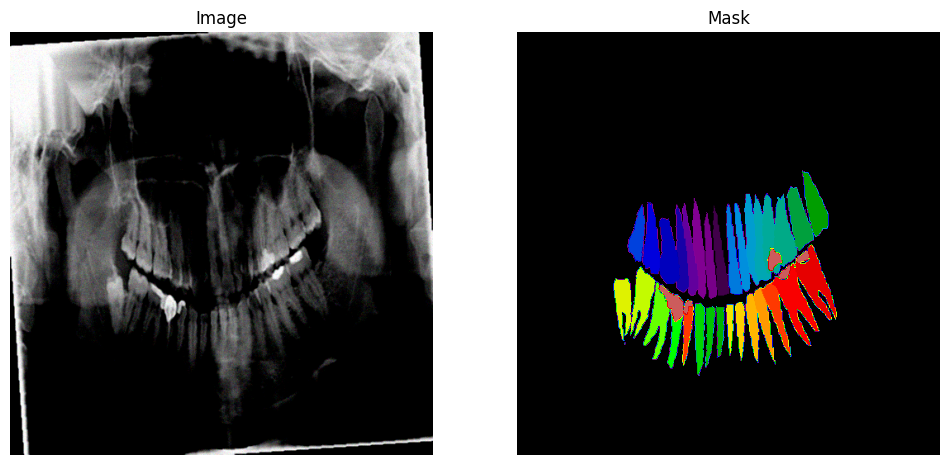

In [5]:
# Visualize a sample from the dataset
  # Remove the extra channel dimension
def plot_sample(image, mask):
    """
    Plots an image and its corresponding mask.
    
    :param image: PIL Image or tensor
    :param mask: Tensor of shape (H, W)
    """
    # Convert image to numpy array if it's a tensor
    
    if isinstance(image, torch.Tensor):
        
        
        image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    
    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")
    
    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="nipy_spectral", vmin=0, vmax=len(class_to_idx) - 1)
    plt.title("Mask")
    plt.axis("off")
    
    plt.show()

# Get a sample from the training dataset
image, mask = train_dataset[2]

# Plot the sample
plot_sample(image, mask)

In [6]:
# # Import segmentation models from torchvision or segmentation_models_pytorch
# import torch.nn as nn
# import torchvision.models.segmentation as segmentation_models

# # Define the model (DeepLabV3+ with a ResNet50 backbone)
# model = segmentation_models.deeplabv3_resnet50(
#     num_classes=len(class_to_idx),  # Number of classes (including background)
#     pretrained_backbone=True  # Use a pretrained ResNet50 backbone
# )

# # Move the model to the appropriate device (GPU if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Print the model architecture
# print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:

from sklearn.model_selection import KFold
import numpy as np
import torchvision.models.segmentation 
import segmentation_models_pytorch as smp


# Define a list of models
# Define models (example list)
# Define models (example list)
models = {
    # TorchVision models
    #"DeepLabV3_ResNet50": torchvision.models.segmentation.deeplabv3_resnet50(num_classes=len(class_to_idx)),
   #"FCN_ResNet50": torchvision.models.segmentation.fcn_resnet50(num_classes=len(class_to_idx)),
    
    # U-Net variants with different backbonesUPerNet
  #  "UPerNet_ResNet50": smp.UPerNet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
   # "MANet_VGG19": smp.MAnet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
   "DeepLabV3Plus_ResNet50": smp.DeepLabV3Plus(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
   # "UNet_VGG16": smp.Unet(encoder_name='vgg16', encoder_weights='imagenet', classes=len(class_to_idx)),
  #  "UNet_VGG19": smp.Unet(encoder_name='vgg19', encoder_weights='imagenet', classes=len(class_to_idx)),
    "UNet_ResNet50": smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
    
#     # # Advanced architectures
#      "PSPNet_ResNet50": smp.PSPNet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
#      "FPN_ResNet50": smp.FPN(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
   
#     #"MANet_VGG19": smp.MAnet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)),
 }
# Convert dataset keys to a list for KFold splitting
img_keys = np.array(annotation_df.index.tolist())
img_key_tufts = np.array(annotation_df_tufts.index.tolist())

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=7)
# Define loss function (CrossEntropyLoss for semantic segmentation)
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer (Adam with learning rate scheduling)


# Optional: Learning rate scheduler


# Optional: Class weights for imbalanced datasets (adjust based on your data)
# Example: class_weights = torch.tensor([1.0, 5.0, 3.0, ...], device=device)
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
def log_results(file_path, epoch, train_loss, val_loss, metrics):
    """
    Log training and validation results to a text file.
    
    :param file_path: Path to the log file
    :param epoch: Current epoch number
    :param train_loss: Training loss
    :param val_loss: Validation loss
    :param metrics: Dictionary of metrics (e.g., mIoU, precision, recall, accuracy)
    """
    with open(file_path, "a") as f:
        f.write(f"Epoch {epoch + 1}\n")
        f.write(f"Train Loss: {train_loss:.4f}\n")
        f.write(f"Val Loss: {val_loss:.4f}\n")
        f.write(f"Metrics: mIoU={metrics['miou']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, Accuracy={metrics['accuracy']:.4f}\n")
        f.write("--------------------------\n")

In [8]:
def compute_metrics(pred_mask, true_mask, num_classes):
    """
    Compute IoU, Dice, precision, recall, and accuracy.
    
    :param pred_mask: Predicted mask tensor of shape (H, W)
    :param true_mask: Ground truth mask tensor of shape (H, W)
    :param num_classes: Number of classes
    :return: Dictionary of metrics
    """
    metrics = {
        "iou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "present_classes": []
    }
    
    total_correct = 0
    total_pixels = pred_mask.numel()
    
    for class_idx in range(num_classes):
        pred_class = (pred_mask == class_idx)
        true_class = (true_mask == class_idx)
        
        # Check if class exists in this image
        class_exists_in_true = true_class.sum().item() > 0
        class_exists_in_pred = pred_class.sum().item() > 0
        class_exists = class_exists_in_true or class_exists_in_pred
        
        # Only calculate metrics if the class exists in either prediction or ground truth
        if class_exists:
            metrics["present_classes"].append(class_idx)
            
            # Intersection and Union
            intersection = torch.logical_and(pred_class, true_class).sum().item()
            union = torch.logical_or(pred_class, true_class).sum().item()
            
            # True Positives, False Positives, False Negatives
            tp = intersection
            fp = pred_class.sum().item() - tp
            fn = true_class.sum().item() - tp
            tn = total_pixels - (tp + fp + fn)
            
            # IoU
            iou = tp / union if union > 0 else 0.0
            
            # Dice coefficient
            dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
            
            # Precision
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            
            # Recall
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            
            # Class-specific accuracy
            accuracy = (tp + tn) / total_pixels
            
            metrics["iou"].append(iou)
            metrics["dice"].append(dice)
            metrics["precision"].append(precision)
            metrics["recall"].append(recall)
            metrics["accuracy"].append(accuracy)
            
            # Count correct predictions for global accuracy
            total_correct += (pred_class == true_class).sum().item()
    
    # Calculate mean metrics only for classes that are present
    if len(metrics["present_classes"]) > 0:
        metrics["miou"] = sum(metrics["iou"]) / len(metrics["iou"])
        metrics["dice_mean"] = sum(metrics["dice"]) / len(metrics["dice"])
        metrics["precision_mean"] = sum(metrics["precision"]) / len(metrics["precision"])
        metrics["recall_mean"] = sum(metrics["recall"]) / len(metrics["recall"])
        metrics["accuracy_mean"] = sum(metrics["accuracy"]) / len(metrics["accuracy"])
        metrics["global_accuracy"] = total_correct / total_pixels
    else:
        metrics["miou"] = 0.0
        metrics["dice_mean"] = 0.0
        metrics["precision_mean"] = 0.0
        metrics["recall_mean"] = 0.0
        metrics["accuracy_mean"] = 0.0
        metrics["global_accuracy"] = 0.0
    
    return metrics

In [9]:
import csv
import os
import torch
import copy
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from IPython.display import clear_output
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split

# Assume compute_metrics, DentalSemanticSegmentationDataset, models, img_keys, annotation_df, img_dict, class_to_idx, 
# spatial_transforms, and image_transforms are defined elsewhere

def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

def should_skip_fold(model_name, fold_idx, base_save_dir="cross_validation_checkpoints_testonly_fixed_last", min_size_kb=34):
    model_save_dir = os.path.join(base_save_dir, model_name)
    fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
    log_file = os.path.join(fold_save_dir, "training_log.csv")
    if os.path.exists(log_file):
        file_size_kb = os.path.getsize(log_file) / 1024
        if file_size_kb >= min_size_kb:
            print(f"Skipping fold {fold_idx + 1} for {model_name}, training_log.csv is {file_size_kb:.2f} KB")
            return True
        else:
            print(f"Continuing fold {fold_idx + 1} for {model_name}, training_log.csv is {file_size_kb:.2f} KB")
    return False

# Set deterministic behavior
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA Version: {torch.version.cuda}")
torch.set_num_threads(1)

# Base directory for checkpoints
base_save_dir = "cross_validation_checkpoints_testonly_fixed_last"
os.makedirs(base_save_dir, exist_ok=True)

# Training parameters
num_epochs = 150
save_epochs_ranges = [(0, 50), (50, 100), (100, 150)]
batch_size = 4
use_test_split = True

# Initialize gradient scaler
scaler = GradScaler()
drop_last = False

# Store initial state for each model (ensure on CPU)
initial_model_states = {name: copy.deepcopy(model.state_dict()) for name, model in models.items()}
# Explicitly move initial states to CPU to avoid device mismatches
for name in initial_model_states:
    for key in initial_model_states[name]:
        initial_model_states[name][key] = initial_model_states[name][key].cpu()

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation loop
for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(img_keys)):
    print(f"\nStarting Fold {fold_idx + 1}/5")
    print(f"Memory status before fold {fold_idx + 1}:")
    print_gpu_memory()
    
    # Get training keys
    train_keys = img_keys[train_idx]
    
    # Handle validation/test split
    if use_test_split:
        val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)
        val_keys = img_keys[val_idx]
        test_keys = img_keys[test_idx]
        print(f"Split sizes - Train: {len(train_keys)}, Validation: {len(val_keys)}, Test: {len(test_keys)}")
    else:
        val_keys = img_keys[val_test_idx]
        test_keys = []
        print(f"Split sizes - Train: {len(train_keys)}, Validation: {len(val_keys)}")
    
    # Create datasets
    train_dataset = DentalSemanticSegmentationDataset(
        train_keys, annotation_df, img_dict, class_to_idx,
        spatial_transforms=spatial_transforms,
        image_transforms=image_transforms
    )
    val_dataset = DentalSemanticSegmentationDataset(val_keys, annotation_df, img_dict, class_to_idx)
    
    # Loop through models sequentially (DeepLab, then UNet)
    for model_name, model in models.items():
        print(f"\nTraining {model_name} for Fold {fold_idx + 1}")
        
        if should_skip_fold(model_name, fold_idx):
            continue
        
        drop_last = fold_idx in [3, 4]
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, drop_last=drop_last)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=drop_last)
        
        if use_test_split:
            test_dataset = DentalSemanticSegmentationDataset(test_keys, annotation_df, img_dict, class_to_idx)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=drop_last)
        
        # Extra precaution: Reinitialize model to clear any buffers or states
     
        model = models[model_name]  # Fallback to original instance
        
        # Load initial weights (ensure CPU to avoid device mismatch)
       
        model = model.to(device)  # Move to GPU after loading
        
        # Verify weight reset (move current state to CPU for comparison)
        current_state = {k: v.cpu() for k, v in model.state_dict().items()}
        for key in initial_model_states[model_name]:
            if not torch.equal(current_state[key], initial_model_states[model_name][key]):
                raise RuntimeError(f"Weight reset failed for {model_name} in fold {fold_idx + 1}, key: {key}")
        print(f"Verified weight reset for {model_name} in fold {fold_idx + 1}")
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
        scheduler = plateau_scheduler
        
        # Create folder for this model and fold
        model_save_dir = os.path.join(base_save_dir, model_name)
        os.makedirs(model_save_dir, exist_ok=True)
        fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
        os.makedirs(fold_save_dir, exist_ok=True)
        
        # Initialize CSV for logging
        csv_file = os.path.join(fold_save_dir, "training_log.csv")
        if not os.path.exists(csv_file):
            with open(csv_file, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "Epoch",
                    "Train Loss", "Train mIoU", "Train Dice", "Train Precision", "Train Recall", "Train Accuracy",
                    "Val Loss", "Val mIoU", "Val Dice", "Val Precision", "Val Recall", "Val Accuracy",
                    "LR"
                ])
        
        # Best model initialization
        best_val_loss_100 = float('inf')
        best_val_loss_150 = float('inf')
        best_val_loss_200 = float('inf')
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            train_metrics = []
            
            for images, masks in tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Train]", ascii=True, miniters=10):
                images = images.to(device)
                masks = masks.to(device).long()
                
                with autocast():
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    loss = loss_fn(outputs, masks)
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                epoch_train_loss += loss.item() * images.size(0)
                
                with torch.no_grad():
                    pred_masks = torch.argmax(outputs, dim=1)
                    batch_metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    train_metrics.append(batch_metrics)
            
            avg_train_metrics = {
                "miou": np.nanmean([m["miou"] for m in train_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in train_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in train_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in train_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in train_metrics])
            }
            epoch_train_loss /= len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            epoch_val_loss = 0.0
            val_metrics = []
            
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Val]", ascii=True, miniters=10):
                    images = images.to(device)
                    masks = masks.to(device).long()
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    pred_masks = torch.argmax(outputs, dim=1)
                    metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    val_metrics.append(metrics)
                    loss = loss_fn(outputs, masks)
                    epoch_val_loss += loss.item() * images.size(0)
            
            avg_val_metrics = {
                "miou": np.nanmean([m["miou"] for m in val_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in val_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in val_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in val_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in val_metrics])
            }
            epoch_val_loss /= len(val_loader.dataset)
            
            # Step scheduler
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
            
            if epoch % 20 == 0:
                clear_output(wait=True)
                print(f"Cleared output after epoch {epoch} for {model_name}")
                print_gpu_memory()
            
            # Save best models
            if 0 <= epoch + 1 < 50:
                if epoch_val_loss < best_val_loss_100:
                    best_val_loss_100 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_100.pth")
                    torch.save({k: v.cpu() for k, v in model.state_dict().items()}, checkpoint_path)  # Save to CPU
                    print(f"Saved best model between epoch 0-50 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")
            elif 50 <= epoch + 1 < 100:
                if epoch_val_loss < best_val_loss_150:
                    best_val_loss_150 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_150.pth")
                    torch.save({k: v.cpu() for k, v in model.state_dict().items()}, checkpoint_path)  # Save to CPU
                    print(f"Saved best model between epoch 50-100 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")
            elif 100 <= epoch + 1 < 150:
                if epoch_val_loss < best_val_loss_200:
                    best_val_loss_200 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_200.pth")
                    torch.save({k: v.cpu() for k, v in model.state_dict().items()}, checkpoint_path)  # Save to CPU
                    print(f"Saved best model between epoch 100-150 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")
            
            # Log results
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch + 1,
                    epoch_train_loss,
                    avg_train_metrics["miou"],
                    avg_train_metrics["dice_mean"],
                    avg_train_metrics["precision_mean"],
                    avg_train_metrics["recall_mean"],
                    avg_train_metrics["accuracy_mean"],
                    epoch_val_loss,
                    avg_val_metrics["miou"],
                    avg_val_metrics["dice_mean"],
                    avg_val_metrics["precision_mean"],
                    avg_val_metrics["recall_mean"],
                    avg_val_metrics["accuracy_mean"],
                    optimizer.param_groups[0]['lr']
                ])
            
            # Progress reporting
            print(f"{model_name} Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("[Train] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_train_metrics["miou"],
                avg_train_metrics["dice_mean"],
                avg_train_metrics["precision_mean"],
                avg_train_metrics["recall_mean"],
                avg_train_metrics["accuracy_mean"]
            ))
            print("[Val] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_val_metrics["miou"],
                avg_val_metrics["dice_mean"],
                avg_val_metrics["precision_mean"],
                avg_val_metrics["recall_mean"],
                avg_val_metrics["accuracy_mean"]
            ))
            print("--------------------------")
        
        print(f"Finished training {model_name} for Fold {fold_idx + 1}.\n")
        
        # Clear GPU memory before next model
        model = None
        optimizer = None
        torch.cuda.empty_cache()
        print(f"Memory status after {model_name} in fold {fold_idx + 1}:")
        print_gpu_memory()
    
    print(f"Finished Fold {fold_idx + 1}/5.\n")

print("Finished cross-validation.\n")

Cleared output after epoch 140 for UNet_ResNet50
GPU Memory: 0.75 GB / 24.00 GB
UNet_ResNet50 Epoch 141/150
Train Loss: 0.0293 | Val Loss: 0.1021
Learning Rate: 0.000004
[Train] mIoU: 0.8695, Dice: 0.9265, Precision: 0.9270, Recall: 0.9271, Accuracy: 0.9993
[Val] mIoU: 0.6818, Dice: 0.7667, Precision: 0.8012, Recall: 0.7565, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 142/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 142/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 142/150
Train Loss: 0.0293 | Val Loss: 0.1016
Learning Rate: 0.000004
[Train] mIoU: 0.8682, Dice: 0.9254, Precision: 0.9262, Recall: 0.9256, Accuracy: 0.9993
[Val] mIoU: 0.6849, Dice: 0.7694, Precision: 0.8054, Recall: 0.7576, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 143/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 143/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 143/150
Train Loss: 0.0292 | Val Loss: 0.1028
Learning Rate: 0.000004
[Train] mIoU: 0.8695, Dice: 0.9264, Precision: 0.9270, Recall: 0.9268, Accuracy: 0.9993
[Val] mIoU: 0.6833, Dice: 0.7682, Precision: 0.8050, Recall: 0.7561, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 144/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 144/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 144/150
Train Loss: 0.0292 | Val Loss: 0.1006
Learning Rate: 0.000002
[Train] mIoU: 0.8686, Dice: 0.9257, Precision: 0.9262, Recall: 0.9262, Accuracy: 0.9993
[Val] mIoU: 0.6858, Dice: 0.7702, Precision: 0.8037, Recall: 0.7603, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 145/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 145/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 145/150
Train Loss: 0.0292 | Val Loss: 0.1012
Learning Rate: 0.000002
[Train] mIoU: 0.8704, Dice: 0.9272, Precision: 0.9280, Recall: 0.9274, Accuracy: 0.9993
[Val] mIoU: 0.6860, Dice: 0.7704, Precision: 0.8051, Recall: 0.7590, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 146/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 146/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 146/150
Train Loss: 0.0292 | Val Loss: 0.1034
Learning Rate: 0.000002
[Train] mIoU: 0.8688, Dice: 0.9258, Precision: 0.9266, Recall: 0.9260, Accuracy: 0.9993
[Val] mIoU: 0.6813, Dice: 0.7663, Precision: 0.8037, Recall: 0.7536, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 147/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 147/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 147/150
Train Loss: 0.0292 | Val Loss: 0.1018
Learning Rate: 0.000002
[Train] mIoU: 0.8692, Dice: 0.9260, Precision: 0.9262, Recall: 0.9267, Accuracy: 0.9993
[Val] mIoU: 0.6848, Dice: 0.7692, Precision: 0.8043, Recall: 0.7583, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 148/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 148/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 148/150
Train Loss: 0.0294 | Val Loss: 0.1033
Learning Rate: 0.000002
[Train] mIoU: 0.8685, Dice: 0.9259, Precision: 0.9266, Recall: 0.9263, Accuracy: 0.9993
[Val] mIoU: 0.6817, Dice: 0.7673, Precision: 0.8044, Recall: 0.7547, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 149/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 149/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 149/150
Train Loss: 0.0293 | Val Loss: 0.1018
Learning Rate: 0.000002
[Train] mIoU: 0.8687, Dice: 0.9259, Precision: 0.9265, Recall: 0.9263, Accuracy: 0.9993
[Val] mIoU: 0.6831, Dice: 0.7680, Precision: 0.8055, Recall: 0.7547, Accuracy: 0.9983
--------------------------


UNet_ResNet50 Epoch 150/150 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 150/150 [Val]:   0%|          | 0/33 [00:00<?, ?it/s]

UNet_ResNet50 Epoch 150/150
Train Loss: 0.0293 | Val Loss: 0.1021
Learning Rate: 0.000002
[Train] mIoU: 0.8689, Dice: 0.9260, Precision: 0.9265, Recall: 0.9266, Accuracy: 0.9993
[Val] mIoU: 0.6826, Dice: 0.7674, Precision: 0.8056, Recall: 0.7545, Accuracy: 0.9983
--------------------------
Finished training UNet_ResNet50 for Fold 5.

Memory status after UNet_ResNet50 in fold 5:
GPU Memory: 0.75 GB / 24.00 GB
Finished Fold 5/5.

Finished cross-validation.



In [10]:
import csv
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.cuda.amp import GradScaler, autocast

def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

def evaluate_model(model, data_loader, device, loss_fn, num_classes):
    """
    Evaluate model on given dataset
    """
    model.eval()
    total_loss = 0.0
    all_metrics = []
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating", ascii=True):
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            
            loss = loss_fn(outputs, masks)
            total_loss += loss.item() * images.size(0)
            
            pred_masks = torch.argmax(outputs, dim=1)
            metrics = compute_metrics(pred_masks, masks, num_classes=num_classes)
            all_metrics.append(metrics)
    
    # Calculate average metrics
    avg_metrics = {
        "loss": total_loss / len(data_loader.dataset),
        "miou": np.nanmean([m["miou"] for m in all_metrics]),
        "dice_mean": np.nanmean([m["dice_mean"] for m in all_metrics]),
        "precision_mean": np.nanmean([m["precision_mean"] for m in all_metrics]),
        "recall_mean": np.nanmean([m["recall_mean"] for m in all_metrics]),
        "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in all_metrics])
    }
    
    return avg_metrics

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# Setup device and loss function
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA Version: {torch.version.cuda}")
torch.set_num_threads(1)

# Base directory to save model checkpoints
base_save_dir = "model_training_results_tufts_Segmentation"
os.makedirs(base_save_dir, exist_ok=True)

# Training parameters
num_epochs = 150
batch_size = 2  # Reduced batch size for better convergence on small datasets
val_split_ratio = 0.5  # Split test set into validation and final test sets

# Initialize gradient scaler for mixed precision
scaler = GradScaler()

# Training loop for each model
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    
    # Create directories for saving results
    model_save_dir = os.path.join(base_save_dir, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    
    # Split test keys into validation and final test sets
    val_keys, final_test_keys = train_test_split(
        img_key_tufts, 
        test_size=val_split_ratio, 
        random_state=42
    )
    
    # Create datasets
    train_dataset = DentalSemanticSegmentationDataset(
        img_keys,  # Your training image keys
        annotation_df, 
        img_dict, 
        class_to_idx, 
        spatial_transforms=spatial_transforms, 
        image_transforms=image_transforms
    )
    
    val_dataset = DentalSemanticSegmentationDataset(
        val_keys,  # Validation image keys
        annotation_df_tufts, 
        img_dict_tufts, 
        class_to_idx
    )
    
    final_test_dataset = DentalSemanticSegmentationDataset(
        final_test_keys,  # Final test image keys
        annotation_df_tufts, 
        img_dict_tufts, 
        class_to_idx
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
    final_test_loader = DataLoader(final_test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
    
    # Initialize model
    model = model.to(device)
    
    # Optimizer and Learning Rate Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=10, 
        factor=0.5, 
        verbose=True
    )
    
    # Training log file
    csv_file = os.path.join(model_save_dir, "training_log.csv")
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Epoch", 
            "Train Loss", "Train mIoU", "Train Dice", "Train Precision", "Train Recall", "Train Accuracy",
            "Val Loss", "Val mIoU", "Val Dice", "Val Precision", "Val Recall", "Val Accuracy",
            "LR"
        ])
    
    # Best model tracking
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        train_metrics = []
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", ascii=True):
            images = images.to(device)
            masks = masks.to(device).long()
            
            # Forward pass with mixed precision
            with autocast():
                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']
                loss = loss_fn(outputs, masks)
            
            # Backward pass with gradient scaling
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            epoch_train_loss += loss.item() * images.size(0)
            
            # Calculate training metrics
            with torch.no_grad():
                pred_masks = torch.argmax(outputs, dim=1)
                batch_metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                train_metrics.append(batch_metrics)
        
        # Calculate average training metrics
        avg_train_metrics = {
            "miou": np.nanmean([m["miou"] for m in train_metrics]),
            "dice_mean": np.nanmean([m["dice_mean"] for m in train_metrics]),
            "precision_mean": np.nanmean([m["precision_mean"] for m in train_metrics]),
            "recall_mean": np.nanmean([m["recall_mean"] for m in train_metrics]),
            "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in train_metrics])
        }
        epoch_train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        val_metrics = []
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", ascii=True):
                images = images.to(device)
                masks = masks.to(device).long()
                
                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Compute metrics
                metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                val_metrics.append(metrics)
                
                # Compute validation loss
                loss = loss_fn(outputs, masks)
                epoch_val_loss += loss.item() * images.size(0)
        
        # Calculate average validation metrics
        avg_val_metrics = {
            "miou": np.nanmean([m["miou"] for m in val_metrics]),
            "dice_mean": np.nanmean([m["dice_mean"] for m in val_metrics]),
            "precision_mean": np.nanmean([m["precision_mean"] for m in val_metrics]),
            "recall_mean": np.nanmean([m["recall_mean"] for m in val_metrics]),
            "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in val_metrics])
        }
        epoch_val_loss /= len(val_loader.dataset)
        
        # Step the scheduler
        scheduler.step(epoch_val_loss)
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            checkpoint_path = os.path.join(model_save_dir, "best_model.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved best model at epoch {epoch + 1} with validation loss: {epoch_val_loss:.4f}")
        
        # Log results to CSV
        with open(csv_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                # Training metrics
                epoch_train_loss,
                avg_train_metrics["miou"],
                avg_train_metrics["dice_mean"],
                avg_train_metrics["precision_mean"],
                avg_train_metrics["recall_mean"],
                avg_train_metrics["accuracy_mean"],
                # Validation metrics
                epoch_val_loss,
                avg_val_metrics["miou"],
                avg_val_metrics["dice_mean"],
                avg_val_metrics["precision_mean"],
                avg_val_metrics["recall_mean"],
                avg_val_metrics["accuracy_mean"],
                # Learning rate
                optimizer.param_groups[0]['lr']
            ])
        
        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("[Train] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
            avg_train_metrics["miou"],
            avg_train_metrics["dice_mean"],
            avg_train_metrics["precision_mean"],
            avg_train_metrics["recall_mean"],
            avg_train_metrics["accuracy_mean"]
        ))
        print("[Val] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
            avg_val_metrics["miou"],
            avg_val_metrics["dice_mean"],
            avg_val_metrics["precision_mean"],
            avg_val_metrics["recall_mean"],
            avg_val_metrics["accuracy_mean"]
        ))
        print("--------------------------")
    
    # Final model evaluation on test set
    print(f"\nPerforming final evaluation for {model_name}...")
    
    # Load best model
    best_model_path = os.path.join(model_save_dir, "best_model.pth")
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    
    # Evaluate on final test set
    final_test_metrics = evaluate_model(model, final_test_loader, device, loss_fn, len(class_to_idx))
    
    # Save final test results
    final_results_file = os.path.join(model_save_dir, "final_test_results.csv")
    with open(final_results_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Test Loss", "Test mIoU", "Test Dice", 
            "Test Precision", "Test Recall", "Test Accuracy"
        ])
        writer.writerow([
            final_test_metrics["loss"],
            final_test_metrics["miou"],
            final_test_metrics["dice_mean"],
            final_test_metrics["precision_mean"],
            final_test_metrics["recall_mean"],
            final_test_metrics["accuracy_mean"]
        ])
    
    print("Final Test Results:")
    print(f"Test Loss: {final_test_metrics['loss']:.4f}")
    print(f"Test mIoU: {final_test_metrics['miou']:.4f}")
    print(f"Test Dice: {final_test_metrics['dice_mean']:.4f}")
    print(f"Test Precision: {final_test_metrics['precision_mean']:.4f}")
    print(f"Test Recall: {final_test_metrics['recall_mean']:.4f}")
    print(f"Test Accuracy: {final_test_metrics['accuracy_mean']:.4f}")

print("Training and evaluation completed.")

Using device: cuda
CUDA Version: 11.8
Training model: DeepLabV3Plus_ResNet50


Epoch 1/150 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
import csv
import os
import torch
import copy
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from IPython.display import clear_output
from torch.cuda.amp import GradScaler, autocast

def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

def should_skip_fold(model_name, fold_idx, base_save_dir="cross_validation_checkpoints_testonly_fixed", min_size_kb=34):
    model_save_dir = os.path.join(base_save_dir, model_name)
    fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
    log_file = os.path.join(fold_save_dir, "training_log.csv")

    if os.path.exists(log_file):
        file_size_kb = os.path.getsize(log_file) / 1024  # Convert bytes to KB
        if file_size_kb >= min_size_kb:
            print(f"Skipping fold {fold_idx + 1}, training_log.csv is {file_size_kb:.2f} KB")
            return True  # Skip this fold
        else:
            print(f"Continuing fold {fold_idx + 1}, training_log.csv is {file_size_kb:.2f} KB")
    return False  # Continue training

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA Version: {torch.version.cuda}")
torch.set_num_threads(1)

# Base directory to save model checkpoints
base_save_dir = "cross_validation_checkpoints_testonly_fixed"
os.makedirs(base_save_dir, exist_ok=True)

# Training parameters
num_epochs = 150
save_epochs_ranges = [(0, 50), (50, 100), (100, 150)]  # Define ranges
batch_size = 4  # Reduced batch size for better convergence on small datasets
use_test_split = True  # Set this to False to use all data for validation (no test split)

# Initialize gradient scaler for mixed precision
scaler = GradScaler()
drop_last=False
# Cross-validation loop for each model
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    initial_model_state = {name: model.state_dict() for name, model in models.items()}

    # Create a folder for the current model
    model_save_dir = os.path.join(base_save_dir, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    
    # Initialize KFold for the current model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation loop
    for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(img_keys)):
        print(f"Memory status before fold {fold_idx + 1}:")
        print_gpu_memory()
        
        if should_skip_fold(model_name, fold_idx):
            continue  # Skip this fold
   
        print(f"Training Fold {fold_idx + 1}/5 for {model_name}...")
        if fold_idx in [3,4]:
            drop_last=True
        # Get training keys
        train_keys = img_keys[train_idx]
        
        # Handle validation/test split based on configuration
        if use_test_split:
            # Split the validation/test indices into validation and test (50% each)
            val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)
            val_keys = img_keys[val_idx]
            test_keys = img_keys[test_idx]
            print(f"Split sizes - Train: {len(train_keys)}, Validation: {len(val_keys)}, Test: {len(test_keys)}")
        else:
            # Use all validation/test data as validation
            val_keys = img_keys[val_test_idx]
            test_keys = []  # Empty list, no test split
            print(f"Split sizes - Train: {len(train_keys)}, Validation: {len(val_keys)}")
        
        # Create datasets and dataloaders
        train_dataset = DentalSemanticSegmentationDataset(train_keys, annotation_df, img_dict, class_to_idx, 
                                                         spatial_transforms=spatial_transforms, 
                                                         image_transforms=image_transforms)
        val_dataset = DentalSemanticSegmentationDataset(val_keys, annotation_df, img_dict, class_to_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, drop_last=drop_last)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=drop_last)
        
        # Create test loader only if using test split
        if use_test_split:
            test_dataset = DentalSemanticSegmentationDataset(test_keys, annotation_df, img_dict, class_to_idx)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=drop_last)
        
        # Initialize model, optimizer, and scheduler
        model.load_state_dict(initial_model_state[model_name])  # Reset weights
        model = model.to(device)
        
        # Use weight decay for regularization with small datasets
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        # Create both schedulers for flexibility
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
        
        # Choose which scheduler to use (uncomment one)
        scheduler = plateau_scheduler
        # scheduler = cosine_scheduler
        
        # Create folder for the current fold
        fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
        os.makedirs(fold_save_dir, exist_ok=True)

        # Initialize CSV file for logging
        csv_file = os.path.join(fold_save_dir, "training_log.csv")
        if not os.path.exists(csv_file):  # Write header only if file doesn't exist
            with open(csv_file, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "Epoch", 
                    "Train Loss", "Train mIoU", "Train Dice", "Train Precision", "Train Recall", "Train Accuracy",
                    "Val Loss", "Val mIoU", "Val Dice", "Val Precision", "Val Recall", "Val Accuracy",
                    "LR"
                ])

        # Best model initialization for each range
        best_val_loss_100 = float('inf')
        best_val_loss_150 = float('inf')
        best_val_loss_200 = float('inf')

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            train_metrics = []  # To collect training metrics
            
            # Training phase
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", ascii=True, miniters=10):
                images = images.to(device)
                masks = masks.to(device).long()
                
                # Forward pass with mixed precision
                with autocast():
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    loss = loss_fn(outputs, masks)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                
                epoch_train_loss += loss.item() * images.size(0)
                
                # Calculate training metrics (outside of autocast scope)
                with torch.no_grad():
                    pred_masks = torch.argmax(outputs, dim=1)
                    batch_metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    train_metrics.append(batch_metrics)
            
            # Calculate average training metrics
            avg_train_metrics = {
                "miou": np.nanmean([m["miou"] for m in train_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in train_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in train_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in train_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in train_metrics])
            }
            epoch_train_loss /= len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            epoch_val_loss = 0.0
            val_metrics = []
            
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", ascii=True, miniters=10):
                    images = images.to(device)
                    masks = masks.to(device).long()  # Added .long() for consistency
                    
                    # No need for autocast in validation as we're not computing gradients
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    pred_masks = torch.argmax(outputs, dim=1)
                    
                    # Compute metrics
                    metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    val_metrics.append(metrics)
                    
                    # Compute validation loss
                    loss = loss_fn(outputs, masks)
                    epoch_val_loss += loss.item() * images.size(0)
            
            # Calculate average validation metrics
            avg_val_metrics = {
                "miou": np.nanmean([m["miou"] for m in val_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in val_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in val_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in val_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in val_metrics])
            }
            epoch_val_loss /= len(val_loader.dataset)
            
            # Step the scheduler - critical step that was missing!
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
            
            if epoch % 20 == 0:
                clear_output(wait=True)
                print(f"Cleared output after epoch {epoch}")
                print_gpu_memory()  # Monitor GPU memory usage
                
            # Save best models for different ranges
            if 0 <= epoch + 1 < 50:
                if epoch_val_loss < best_val_loss_100:
                    best_val_loss_100 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_100.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 0-50 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")

            elif 50 <= epoch + 1 < 100:
                if epoch_val_loss < best_val_loss_150:
                    best_val_loss_150 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_150.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 50-100 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")

            elif 100 <= epoch + 1 < 150:
                if epoch_val_loss < best_val_loss_200:
                    best_val_loss_200 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_200.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 100-150 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")
            
            # Log results to CSV
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch + 1,
                    # Training metrics
                    epoch_train_loss,
                    avg_train_metrics["miou"],
                    avg_train_metrics["dice_mean"],
                    avg_train_metrics["precision_mean"],
                    avg_train_metrics["recall_mean"],
                    avg_train_metrics["accuracy_mean"],
                    # Validation metrics
                    epoch_val_loss,
                    avg_val_metrics["miou"],
                    avg_val_metrics["dice_mean"],
                    avg_val_metrics["precision_mean"],
                    avg_val_metrics["recall_mean"],
                    avg_val_metrics["accuracy_mean"],
                    # Learning rate
                    optimizer.param_groups[0]['lr']
                ])

            # Enhanced progress reporting
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("[Train] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_train_metrics["miou"],
                avg_train_metrics["dice_mean"],
                avg_train_metrics["precision_mean"],
                avg_train_metrics["recall_mean"],
                avg_train_metrics["accuracy_mean"]
            ))
            print("[Val] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_val_metrics["miou"],
                avg_val_metrics["dice_mean"],
                avg_val_metrics["precision_mean"],
                avg_val_metrics["recall_mean"],
                avg_val_metrics["accuracy_mean"]
            ))
            print("--------------------------")
        
        print(f"Finished training Fold {fold_idx + 1} for {model_name}.\n")
        # Clean up GPU memory after each fold
        torch.cuda.empty_cache()
    
    print(f"Finished training {model_name}.\n")

Using device: cuda
CUDA Version: 11.8
Training model: DeepLabV3Plus_ResNet50
Memory status before fold 1:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 1, training_log.csv is 35.80 KB
Memory status before fold 2:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 2, training_log.csv is 35.87 KB
Memory status before fold 3:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 3, training_log.csv is 35.91 KB
Memory status before fold 4:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 4, training_log.csv is 35.66 KB
Memory status before fold 5:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 5, training_log.csv is 38.02 KB
Finished training DeepLabV3Plus_ResNet50.

Training model: UNet_ResNet50
Memory status before fold 1:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 1, training_log.csv is 35.66 KB
Memory status before fold 2:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 2, training_log.csv is 35.70 KB
Memory status before fold 3:
GPU Memory: 0.15 GB / 24.00 GB
Skipping fold 3, training_log.csv is 35.67 KB
Me

In [10]:
import csv
import os
import torch
import copy
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from IPython.display import clear_output
from torch.cuda.amp import GradScaler, autocast

def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

def should_skip_fold(model_name, fold_idx, base_save_dir="cross_validation_checkpoints_test", min_size_kb=34):
    model_save_dir = os.path.join(base_save_dir, model_name)
    fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
    log_file = os.path.join(fold_save_dir, "training_log.csv")

    if os.path.exists(log_file):
        file_size_kb = os.path.getsize(log_file) / 1024  # Convert bytes to KB
        if file_size_kb >= min_size_kb:
            print(f"Skipping fold {fold_idx + 1}, training_log.csv is {file_size_kb:.2f} KB")
            return True  # Skip this fold
        else:
            print(f"Continuing fold {fold_idx + 1}, training_log.csv is {file_size_kb:.2f} KB")
    return False  # Continue training

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA Version: {torch.version.cuda}")
torch.set_num_threads(1)

# Base directory to save model checkpoints
base_save_dir = "cross_validation_checkpoints_test"
os.makedirs(base_save_dir, exist_ok=True)

# Training parameters
num_epochs = 150
save_epochs_ranges = [(0, 50), (50, 100), (100, 150)]  # Define ranges
batch_size = 4  # Reduced batch size for better convergence on small datasets

# Initialize gradient scaler for mixed precision
scaler = GradScaler()

# Cross-validation loop for each model
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    initial_model_state = {name: model.state_dict() for name, model in models.items()}

    # Create a folder for the current model
    model_save_dir = os.path.join(base_save_dir, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    
    # Initialize KFold for the current model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation loop
    for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(img_keys)):
        print(f"Memory status before fold {fold_idx + 1}:")
        print_gpu_memory()
        
        if should_skip_fold(model_name, fold_idx):
            continue  # Skip this fold
   
        print(f"Training Fold {fold_idx + 1}/5 for {model_name}...")

        # Split the validation/test indices into validation and test (50% each)
        val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)
        
        # Get the keys for each split
        train_keys = img_keys[train_idx]
        val_keys = img_keys[val_idx]
        test_keys = img_keys[test_idx]
        
        print(f"Split sizes - Train: {len(train_keys)}, Validation: {len(val_keys)}, Test: {len(test_keys)}")
        
        # Create datasets and dataloaders
        train_dataset = DentalSemanticSegmentationDataset(train_keys, annotation_df, img_dict, class_to_idx, 
                                                         spatial_transforms=spatial_transforms, 
                                                         image_transforms=image_transforms)
        val_dataset = DentalSemanticSegmentationDataset(val_keys, annotation_df, img_dict, class_to_idx)
        test_dataset = DentalSemanticSegmentationDataset(test_keys, annotation_df, img_dict, class_to_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, drop_last=False)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
        # Initialize model, optimizer, and scheduler
        model.load_state_dict(initial_model_state[model_name])  # Reset weights
        model = model.to(device)
        
        # Use weight decay for regularization with small datasets
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        # Create both schedulers for flexibility
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
        
        # Choose which scheduler to use (uncomment one)
        scheduler = plateau_scheduler
        # scheduler = cosine_scheduler
        
        # Create folder for the current fold
        fold_save_dir = os.path.join(model_save_dir, f"fold_{fold_idx + 1}")
        os.makedirs(fold_save_dir, exist_ok=True)

        # Initialize CSV file for logging
        csv_file = os.path.join(fold_save_dir, "training_log.csv")
        if not os.path.exists(csv_file):  # Write header only if file doesn't exist
            with open(csv_file, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "Epoch", 
                    "Train Loss", "Train mIoU", "Train Dice", "Train Precision", "Train Recall", "Train Accuracy",
                    "Val Loss", "Val mIoU", "Val Dice", "Val Precision", "Val Recall", "Val Accuracy",
                    "LR"
                ])

        # Best model initialization for each range
        best_val_loss_100 = float('inf')
        best_val_loss_150 = float('inf')
        best_val_loss_200 = float('inf')

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            train_metrics = []  # To collect training metrics
            
            # Training phase
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", ascii=True, miniters=10):
                images = images.to(device)
                masks = masks.to(device).long()
                
                # Forward pass with mixed precision
                with autocast():
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    loss = loss_fn(outputs, masks)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                
                epoch_train_loss += loss.item() * images.size(0)
                
                # Calculate training metrics (outside of autocast scope)
                with torch.no_grad():
                    pred_masks = torch.argmax(outputs, dim=1)
                    batch_metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    train_metrics.append(batch_metrics)
            
            # Calculate average training metrics
            avg_train_metrics = {
                "miou": np.nanmean([m["miou"] for m in train_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in train_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in train_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in train_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in train_metrics])
            }
            epoch_train_loss /= len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            epoch_val_loss = 0.0
            val_metrics = []
            
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", ascii=True, miniters=10):
                    images = images.to(device)
                    masks = masks.to(device).long()  # Added .long() for consistency
                    
                    # No need for autocast in validation as we're not computing gradients
                    outputs = model(images)
                    if isinstance(outputs, dict):
                        outputs = outputs['out']
                    pred_masks = torch.argmax(outputs, dim=1)
                    
                    # Compute metrics
                    metrics = compute_metrics(pred_masks, masks, num_classes=len(class_to_idx))
                    val_metrics.append(metrics)
                    
                    # Compute validation loss
                    loss = loss_fn(outputs, masks)
                    epoch_val_loss += loss.item() * images.size(0)
            
            # Calculate average validation metrics
            avg_val_metrics = {
                "miou": np.nanmean([m["miou"] for m in val_metrics]),
                "dice_mean": np.nanmean([m["dice_mean"] for m in val_metrics]),
                "precision_mean": np.nanmean([m["precision_mean"] for m in val_metrics]),
                "recall_mean": np.nanmean([m["recall_mean"] for m in val_metrics]),
                "accuracy_mean": np.nanmean([m["accuracy_mean"] for m in val_metrics])
            }
            epoch_val_loss /= len(val_loader.dataset)
            
            # Step the scheduler - critical step that was missing!
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
            
            if epoch % 20 == 0:
                clear_output(wait=True)
                print(f"Cleared output after epoch {epoch}")
                print_gpu_memory()  # Monitor GPU memory usage
                
            # Save best models for different ranges
            if 0 <= epoch + 1 < 50:
                if epoch_val_loss < best_val_loss_100:
                    best_val_loss_100 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_100.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 0-50 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")

            elif 50 <= epoch + 1 < 100:
                if epoch_val_loss < best_val_loss_150:
                    best_val_loss_150 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_150.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 50-100 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")

            elif 100 <= epoch + 1 < 150:
                if epoch_val_loss < best_val_loss_200:
                    best_val_loss_200 = epoch_val_loss
                    checkpoint_path = os.path.join(fold_save_dir, f"best_model_200.pth")
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f"Saved best model between epoch 100-150 at epoch {epoch + 1} with val loss: {epoch_val_loss:.4f}")
            
            # Log results to CSV
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch + 1,
                    # Training metrics
                    epoch_train_loss,
                    avg_train_metrics["miou"],
                    avg_train_metrics["dice_mean"],
                    avg_train_metrics["precision_mean"],
                    avg_train_metrics["recall_mean"],
                    avg_train_metrics["accuracy_mean"],
                    # Validation metrics
                    epoch_val_loss,
                    avg_val_metrics["miou"],
                    avg_val_metrics["dice_mean"],
                    avg_val_metrics["precision_mean"],
                    avg_val_metrics["recall_mean"],
                    avg_val_metrics["accuracy_mean"],
                    # Learning rate
                    optimizer.param_groups[0]['lr']
                ])

            # Enhanced progress reporting
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print("[Train] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_train_metrics["miou"],
                avg_train_metrics["dice_mean"],
                avg_train_metrics["precision_mean"],
                avg_train_metrics["recall_mean"],
                avg_train_metrics["accuracy_mean"]
            ))
            print("[Val] mIoU: {:.4f}, Dice: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(
                avg_val_metrics["miou"],
                avg_val_metrics["dice_mean"],
                avg_val_metrics["precision_mean"],
                avg_val_metrics["recall_mean"],
                avg_val_metrics["accuracy_mean"]
            ))
            print("--------------------------")
        
        print(f"Finished training Fold {fold_idx + 1} for {model_name}.\n")
        # Clean up GPU memory after each fold
        torch.cuda.empty_cache()
    
    print(f"Finished training {model_name}.\n")

Using device: cuda
CUDA Version: 11.8
Training model: DeepLabV3Plus_ResNet50
Memory status before fold 1:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 1, training_log.csv is 35.76 KB
Memory status before fold 2:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 2, training_log.csv is 35.69 KB
Memory status before fold 3:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 3, training_log.csv is 35.72 KB
Memory status before fold 4:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 4, training_log.csv is 41.49 KB
Memory status before fold 5:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 5, training_log.csv is 35.64 KB
Finished training DeepLabV3Plus_ResNet50.

Training model: UNet_ResNet50
Memory status before fold 1:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 1, training_log.csv is 35.76 KB
Memory status before fold 2:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 2, training_log.csv is 35.61 KB
Memory status before fold 3:
GPU Memory: 0.00 GB / 24.00 GB
Skipping fold 3, training_log.csv is 35.49 KB
Me

No valid k-fold splits file provided. Generating 5-fold splits with random_state=42...
Generated k-fold splits saved to: cross_validation_checkpoints_testonly_fixed_last\generated_kfold_splits.json
Processing fold 1...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_1\best_model_200.pth
Evaluating on validation set (67 samples)...


C:\Users\Haydar\AppData\Local\Temp\ipykernel_12640\313826311.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


Validation fold 1:   0%|          | 0/67 [00:00<?, ?it/s]

Fold 1 - Validation Dice: 0.7220
Processing fold 2...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_2\best_model_200.pth
Evaluating on validation set (67 samples)...


Validation fold 2:   0%|          | 0/67 [00:00<?, ?it/s]

Fold 2 - Validation Dice: 0.7532
Processing fold 3...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_3\best_model_200.pth
Evaluating on validation set (67 samples)...


Validation fold 3:   0%|          | 0/67 [00:00<?, ?it/s]

Fold 3 - Validation Dice: 0.7504
Processing fold 4...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_4\best_model_200.pth
Evaluating on validation set (66 samples)...


Validation fold 4:   0%|          | 0/66 [00:00<?, ?it/s]

Fold 4 - Validation Dice: 0.7342
Processing fold 5...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_5\best_model_200.pth
Evaluating on validation set (66 samples)...


Validation fold 5:   0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

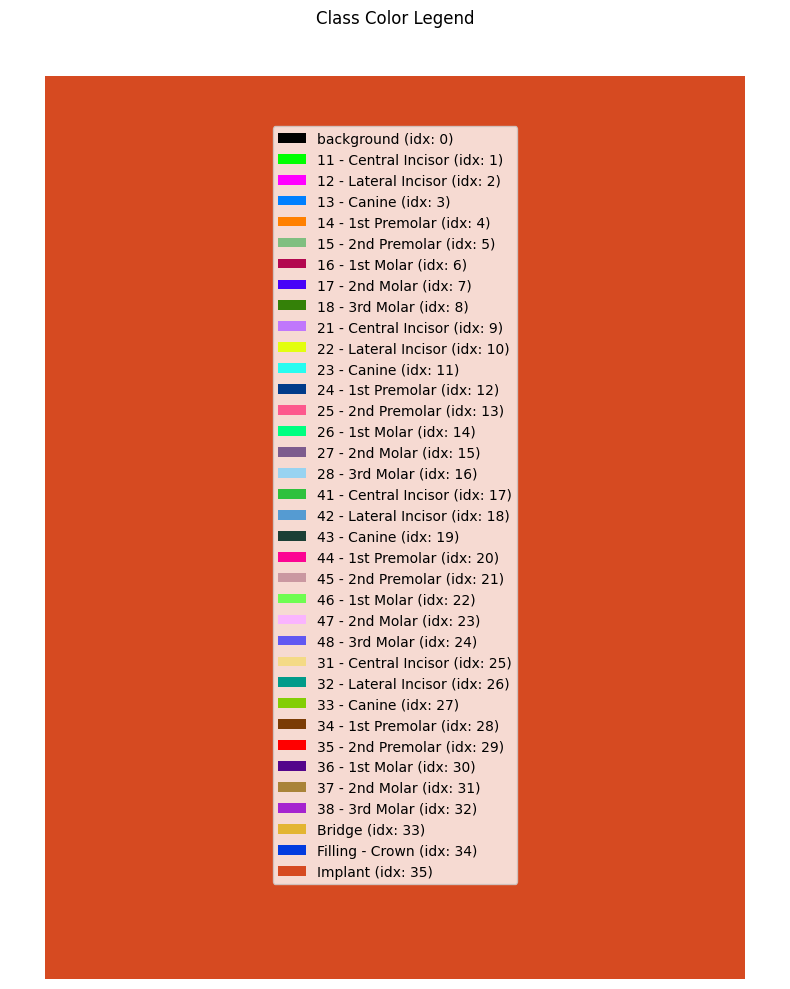

In [12]:
def evaluate_models_with_kfold(model_name, kfold_json_path=None, 
                              base_dataset=None, models=None,
                              base_save_dir="cross_validation_checkpoints", 
                              class_to_idx=None, 
                              device="cuda", test_dataset=None,
                              color_mapping_path=None,
                              correct_quadrants=False,
                              n_splits=5,
                              random_state=42):
    """
    Evaluates models trained with KFold cross-validation using both fold information and test set
    
    Args:
        model_name: Name of the model to evaluate
        kfold_json_path: Path to the kfold_splits.json file containing fold definitions. 
                        If None, generates k-fold splits automatically
        base_dataset: Instance of DentalSemanticSegmentationDataset with all data
        models: Dictionary mapping model names to model classes
        base_save_dir: Directory where checkpoints are saved
        class_to_idx: Dictionary mapping class names to indices
        device: Device to run evaluation on
        test_dataset: Optional test dataset
        color_mapping_path: Path to JSON file with color mapping
        correct_quadrants: Whether to correct quadrant labels
        n_splits: Number of folds to generate if kfold_json_path is None (default: 5)
        random_state: Random seed for k-fold generation (default: 42)
    """
    import os
    import json
    import torch
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from tqdm.auto import tqdm
    from torch.utils.data import DataLoader, Subset
    
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            # Check if this is a tooth class that needs correction
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                # Swap 3rd and 4th quadrant tooth labels
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        
        # Use the corrected mapping
        class_to_idx = corrected_class_to_idx
    
    # Get inverse mapping from class index to name
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    # Create a color map for visualization
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    # Create directories for evaluation results
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    
    # Create directories for organizing images
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    # Set up CSVs to store metrics
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    
    # Set up CSVs for per-image metrics
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    # Prepare data containers for metrics
    val_csv_data = []  # For validation results
    test_csv_data = []  # For test results
    val_per_image_data = []  # For per-image validation results
    test_per_image_data = []  # For per-image test results
    
    # Check if we need to generate k-fold splits
    if kfold_json_path is None or not os.path.exists(kfold_json_path):
        print(f"No valid k-fold splits file provided. Generating {n_splits}-fold splits with random_state={random_state}...")
        
        # Import sklearn for KFold
        from sklearn.model_selection import KFold
        
        # Generate indices for all samples in the dataset
        all_indices = list(range(1, len(base_dataset) + 1))  # 1-based indexing for consistency
        
        # Initialize KFold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        # Generate fold splits
        kfold_splits = []
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
            kfold_splits.append({
                "fold": fold_idx + 1,
                "train_ids": [all_indices[i] for i in train_idx],
                "val_ids": [all_indices[i] for i in val_idx]
            })
        
        # Save the generated splits to a JSON file
        generated_json_path = os.path.join(base_save_dir, "generated_kfold_splits.json")
        with open(generated_json_path, 'w') as f:
            json.dump(kfold_splits, f, indent=4)
        
        print(f"Generated k-fold splits saved to: {generated_json_path}")
        
        # Use the generated splits
        kfold_splits = kfold_splits
    else:
        # Load KFold configuration from provided file
        print(f"Loading k-fold splits from: {kfold_json_path}")
        with open(kfold_json_path, 'r') as f:
            kfold_splits = json.load(f)
    
    # Process each fold
    for fold_idx, fold in enumerate(kfold_splits):
        fold_num = fold_idx + 1
        print(f"Processing fold {fold_num}...")
        
        # Find the best model for this fold
        fold_dir = os.path.join(base_save_dir, model_name, f"fold_{fold_num}")
        
        if not os.path.exists(fold_dir):
            print(f"Directory not found: {fold_dir}")
            continue
        
        # Find all model files and get the best one (highest epoch)
        model_files = [f for f in os.listdir(fold_dir) if f.startswith("best_model_") and f.endswith(".pth")]
        if not model_files:
            print(f"No model files found in {fold_dir}")
            continue
        
        # Sort by epoch number and get the latest
        model_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
        best_model_file = model_files[-1]
        epoch = int(best_model_file.split("_")[2].split(".")[0])
        
        # Load the model
        model_path = os.path.join(fold_dir, best_model_file)
        model = models[model_name].to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        print(f"Loaded model: {model_path}")
        
        # Create directories for this fold
        fold_images_dir = os.path.join(images_dir, f"fold_{fold_num}")
        os.makedirs(os.path.join(fold_images_dir, "validation"), exist_ok=True)
        if test_dataset:
            os.makedirs(os.path.join(fold_images_dir, "test"), exist_ok=True)
        
        # 1. Evaluate on validation set
        val_indices = fold["val_ids"]
        # Map the val_ids to actual dataset indices
        
        # Create validation dataset as a subset
        val_keys = [base_dataset._img_keys[i-1] for i in val_indices]  # Adjust for 0-based indexing if needed
        
        # Create a new dataset with only validation keys
        val_dataset = DentalSemanticSegmentationDataset(
            img_keys=val_keys,
            annotation_df=base_dataset._annotation_df,
            img_dict=base_dataset._img_dict,
            class_to_idx=base_dataset._class_to_idx,
            image_transforms=base_dataset.image_transforms,
            spatial_transforms=base_dataset.spatial_transforms,
            img_size=base_dataset.img_size
        )
        
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
        
        print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
        
        # Track metrics
        val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": [],
            "dice": [],
            "precision": [],
            "recall": [],
            "accuracy": [],
            "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
        }
        
        # Process each validation image
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Validation fold {fold_num}")):
                image = image.to(device)
                mask = mask.to(device).long()
                
                # Get image key/identifier
                img_key = val_keys[i]
                
                # Extract the image name from the key (assuming key contains file path)
                img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"
                
                # Generate prediction
                output = model(image)
                if isinstance(output, dict):
                    output = output['out']
                pred_mask = torch.argmax(output, dim=1)
                
                # Calculate metrics
                metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                
                # Store metrics
                val_metrics["miou"].append(metrics["miou"])
                val_metrics["dice"].append(metrics["dice_mean"])
                val_metrics["precision"].append(metrics["precision_mean"])
                val_metrics["recall"].append(metrics["recall_mean"])
                val_metrics["accuracy"].append(metrics["accuracy_mean"])
                
                # Store per-class metrics
                for cls_idx in range(num_classes):
                    if cls_idx < len(metrics["class_dice"]):
                        val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                
                # Save per-image metrics to CSV data
                per_image_metrics = {
                    "fold": fold_num,
                    "epoch": epoch,
                    "image_key": img_key,
                    "image_name": img_name,
                    "miou": metrics["miou"],
                    "dice": metrics["dice_mean"],
                    "precision": metrics["precision_mean"],
                    "recall": metrics["recall_mean"],
                    "accuracy": metrics["accuracy_mean"]
                }
                
                # Add per-class dice scores for each image
                for cls_idx in range(num_classes):
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    if cls_idx < len(metrics["class_dice"]):
                        per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                    else:
                        per_image_metrics[f"dice_{class_name}"] = np.nan
                
                val_per_image_data.append(per_image_metrics)
                
                # Save visualization for all samples with image name in filename
                # Use a safe filename by removing any special characters
                safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                sample_dir = os.path.join(fold_images_dir, "validation", f"{safe_img_name}")
                
                save_prediction_images(
                    image, mask, pred_mask, metrics, 
                    sample_dir,
                    colors, num_classes,
                    img_name=img_name,
                    color_mapping=color_mapping,
                    class_to_idx=class_to_idx
                )
                
        # Calculate average validation metrics
        avg_val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": np.nanmean(val_metrics["miou"]),
            "dice": np.nanmean(val_metrics["dice"]),
            "precision": np.nanmean(val_metrics["precision"]),
            "recall": np.nanmean(val_metrics["recall"]),
            "accuracy": np.nanmean(val_metrics["accuracy"])
        }
        
        # Add per-class dice scores
        for cls_idx in range(num_classes):
            class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
            avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
        
        # Add to CSV data
        val_csv_data.append(avg_val_metrics)
        
        # Save class performance visualization for validation
        create_class_performance_plot(
            avg_val_metrics, idx_to_class, num_classes,
            os.path.join(fold_images_dir, "validation", "class_performance.png"),
            f"Fold {fold_num} Validation - Dice Score per Class"
        )
        
        print(f"Fold {fold_num} - Validation Dice: {avg_val_metrics['dice']:.4f}")
        
        # 2. Evaluate on test set if available
        if test_dataset:
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
            
            print(f"Evaluating on test set ({len(test_dataset)} samples)...")
            
            # Track metrics
            test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": [],
                "dice": [],
                "precision": [],
                "recall": [],
                "accuracy": [],
                "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
            }
            
            # Process each test image
            with torch.no_grad():
                for i, (image, mask) in enumerate(tqdm(test_loader, desc=f"Test fold {fold_num}")):
                    image = image.to(device)
                    mask = mask.to(device).long()
                    
                    # Get image key/identifier (if available, otherwise use index)
                    img_key = test_dataset._img_keys[i] if hasattr(test_dataset, '_img_keys') else f"test_image_{i}"
                    
                    # Extract the image name from the key
                    img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"
                    
                    # Generate prediction
                    output = model(image)
                    if isinstance(output, dict):
                        output = output['out']
                    pred_mask = torch.argmax(output, dim=1)
                    
                    # Calculate metrics
                    metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                    
                    # Store metrics
                    test_metrics["miou"].append(metrics["miou"])
                    test_metrics["dice"].append(metrics["dice_mean"])
                    test_metrics["precision"].append(metrics["precision_mean"])
                    test_metrics["recall"].append(metrics["recall_mean"])
                    test_metrics["accuracy"].append(metrics["accuracy_mean"])
                    
                    # Store per-class metrics
                    for cls_idx in range(num_classes):
                        if cls_idx < len(metrics["class_dice"]):
                            test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                    
                    # Save per-image metrics to CSV data
                    per_image_metrics = {
                        "fold": fold_num,
                        "epoch": epoch,
                        "image_key": img_key,
                        "image_name": img_name,
                        "miou": metrics["miou"],
                        "dice": metrics["dice_mean"],
                        "precision": metrics["precision_mean"],
                        "recall": metrics["recall_mean"],
                        "accuracy": metrics["accuracy_mean"]
                    }
                    
                    # Add per-class dice scores for each image
                    for cls_idx in range(num_classes):
                        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                        if cls_idx < len(metrics["class_dice"]):
                            per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                        else:
                            per_image_metrics[f"dice_{class_name}"] = np.nan
                    
                    test_per_image_data.append(per_image_metrics)
                    
                    # Save visualization with image name in filename
                    # Use a safe filename by removing any special characters
                    safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                    sample_dir = os.path.join(fold_images_dir, "test", f"{safe_img_name}")
                    
                    save_prediction_images(
                        image, mask, pred_mask, metrics, 
                        sample_dir,
                        colors, num_classes,
                        img_name=img_name,
                        color_mapping=color_mapping,
                        class_to_idx=class_to_idx
                    )
                    
            # Calculate average test metrics
            avg_test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": np.nanmean(test_metrics["miou"]),
                "dice": np.nanmean(test_metrics["dice"]),
                "precision": np.nanmean(test_metrics["precision"]),
                "recall": np.nanmean(test_metrics["recall"]),
                "accuracy": np.nanmean(test_metrics["accuracy"])
            }
            
            # Add per-class dice scores
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
            
            # Add to CSV data
            test_csv_data.append(avg_test_metrics)
            
            # Save class performance visualization for test
            create_class_performance_plot(
                avg_test_metrics, idx_to_class, num_classes,
                os.path.join(fold_images_dir, "test", "class_performance.png"),
                f"Fold {fold_num} Test - Dice Score per Class"
            )
            
            print(f"Fold {fold_num} - Test Dice: {avg_test_metrics['dice']:.4f}")
    
    # Save validation metrics to CSV
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        create_fold_comparison_plots(val_df, results_dir, "validation")
    
    # Save test metrics to CSV
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        create_fold_comparison_plots(test_df, results_dir, "test")
    
    # Save per-image metrics to CSV
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    print(f"Evaluation complete.")
    if val_csv_data:
        print(f"Validation results saved to: {val_csv_path}")
    if test_csv_data:
        print(f"Test results saved to: {test_csv_path}")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path if val_csv_data else None, test_csv_path if test_csv_data else None, val_per_image_csv_path if val_per_image_data else None, test_per_image_csv_path if test_per_image_data else None


def save_prediction_images(image, mask, pred_mask, metrics, output_dir, colors, num_classes, img_name=None, color_mapping=None, class_to_idx=None):
    """Helper function to save prediction visualizations with distinct class colors"""
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import to_rgb
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert tensors to numpy for visualization
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    mask_np = mask[0].cpu().numpy()
    pred_np = pred_mask[0].cpu().numpy()
    
    # Initialize visualization arrays with a neutral gray background
    mask_vis = np.full((*mask_np.shape, 3), 0.5)  # Gray background
    pred_vis = np.full((*mask_np.shape, 3), 0.5)  # Gray background
    error_map = np.full((*mask_np.shape, 3), 0.5)  # Gray background
    
    # Create idx_to_class mapping if class_to_idx is provided
    idx_to_class = {v: k for k, v in class_to_idx.items()} if class_to_idx else {}
    
    # Log for debugging

    
    # Check for background class
    background_idx = None
    # Find if there's a background class by name
    for idx, class_name in idx_to_class.items():
        if "background" in class_name.lower():
            background_idx = idx
            
            break
    
    # If no explicit background class was found, we need to handle this differently
    # We'll check if there are any pixels with value 0 that don't correspond to a valid class
    if background_idx is None:
        min_class_idx = min(idx_to_class.keys()) if idx_to_class else 0
        if min_class_idx > 0 and (0 in np.unique(mask_np) or 0 in np.unique(pred_np)):
            background_idx = 0
            print(f"Using value 0 as implicit background since smallest class index is {min_class_idx}")
    
    # Apply colors for each class
    for cls_idx in range(num_classes):
        # Skip if the class isn't in idx_to_class
        if cls_idx not in idx_to_class and cls_idx != background_idx:
            continue
            
        # Get class name from index, or use a default
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        
        # Define color for this class
        if color_mapping and class_name in color_mapping:
            # Use color from mapping
            color = to_rgb(color_mapping[class_name])
        else:
            # Use colormap
            color = colors(cls_idx % num_classes)[:3]  # Use modulo to avoid index errors
        
        # Apply the color to ground truth and prediction
        mask_vis[mask_np == cls_idx] = color
        pred_vis[pred_np == cls_idx] = color
    
    # Save ground truth and prediction images
    plt.imsave(os.path.join(output_dir, "ground_truth.png"), mask_vis)
    plt.imsave(os.path.join(output_dir, "prediction.png"), pred_vis)
    
    # Create error map - START MODIFICATIONS HERE
    # Initialize error map with all black
    error_map = np.zeros((*mask_np.shape, 3))
    
    # Get all possible classes from both ground truth and prediction
    all_classes = set(np.unique(mask_np)) | set(np.unique(pred_np))
    
    # Mark true positives for non-background classes in green
    true_pos = (pred_np == mask_np) & (mask_np != background_idx)
    error_map[true_pos] = [0, 1, 0]  # Green for correct non-background predictions
    
    # For each pixel that's misclassified:
    misclassified = (pred_np != mask_np)
    
    # Let's determine what kind of error each misclassified pixel is
    for x in range(mask_np.shape[0]):
        for y in range(mask_np.shape[1]):
            if misclassified[x, y]:
                true_class = mask_np[x, y]
                pred_class = pred_np[x, y]
                
                # If we have a background class, use it to define FP and FN
                if background_idx is not None:
                    if true_class == background_idx and pred_class != background_idx:
                        # False positive: predicted a class when it should be background
                        error_map[x, y] = [1, 0, 0]  # Red
                    elif true_class != background_idx and pred_class == background_idx:
                        # False negative: predicted background when it should be a class
                        error_map[x, y] = [0, 0, 1]  # Blue
                    else:
                        # Misclassification between two non-background classes
                        error_map[x, y] = [1, 0.5, 0]  # Orange for class confusion
                else:
                    # Without a background class, we'll use a simpler scheme
                    # Just mark all misclassifications as orange
                    error_map[x, y] = [1, 0.5, 0]  # Orange
    
    plt.imsave(os.path.join(output_dir, "error_map.png"), error_map)
    
    # Save comparison visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='white')
    fig.patch.set_facecolor('white')
    
    title_suffix = f" - {img_name}" if img_name else ""
    
    axes[0].imshow(img_np, cmap='gray')  # Ensure grayscale for X-ray
    axes[0].set_title(f"Original Image{title_suffix}")
    axes[0].axis('off')
    
    axes[1].imshow(mask_vis)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    axes[2].imshow(pred_vis)
    axes[2].set_title(f"Prediction (Dice: {metrics['dice_mean']:.4f})")
    axes[2].axis('off')
    
    axes[3].imshow(error_map)
    if background_idx is not None:
        axes[3].set_title("Error Map (G=TP, R=FP, B=FN, Black=Background)")
    else:
        axes[3].set_title("Error Map (G=Correct, O=Misclassified, Black=Background)")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "comparison.png"), dpi=150, bbox_inches='tight', facecolor='white')
    plt.close(fig)
    
    # Create a legend showing class names and their colors
    if idx_to_class:
        plt.figure(figsize=(8, min(10, num_classes * 0.4)), facecolor='white')
        
        # Sort class indices for consistent legend
        class_indices = sorted(idx_to_class.keys())
        
        # Create a color patch for each class
        for i, cls_idx in enumerate(class_indices):
            class_name = idx_to_class[cls_idx]
            
            if color_mapping and class_name in color_mapping:
                color = color_mapping[class_name]
            else:
                color = colors(cls_idx % num_classes)
                
            plt.bar(0, 1, color=color, label=f"{class_name} (idx: {cls_idx})")
        
        plt.axis('off')
        plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5))
        plt.title("Class Color Legend")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=150, bbox_inches='tight', facecolor='white')
        plt.close()
def create_class_performance_plot(metrics, idx_to_class, num_classes, output_path, title):
    """Helper function to create and save class performance plots"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(10, 6), facecolor='white')
    class_names = [idx_to_class.get(cls_idx, f"Class {cls_idx}") for cls_idx in range(num_classes)]
    class_dice_values = [metrics[f"dice_{idx_to_class.get(cls_idx, f'class_{cls_idx}')}"] for cls_idx in range(num_classes)]
    
    plt.bar(class_names, class_dice_values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.close()


def create_fold_comparison_plots(df, results_dir, dataset_type):
    """Helper function to create comparison plots across folds"""
    import matplotlib.pyplot as plt
    import os
    
    # Create comparison visualizations across folds
    plt.figure(figsize=(12, 6), facecolor='white')
    metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
    
    for i, metric_name in enumerate(metric_names):
        plt.subplot(1, 5, i+1)
        plt.bar(df["fold"], df[metric_name])
        plt.title(metric_name.capitalize())
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"{dataset_type}_fold_comparison.png"), dpi=150, bbox_inches='tight', facecolor='white')
    plt.close()
    
    # Create per-class comparison across folds
    class_metric_cols = [col for col in df.columns if col.startswith("dice_")]
    if class_metric_cols:
        plt.figure(figsize=(14, 8), facecolor='white')
        
        for i, col in enumerate(class_metric_cols):
            class_name = col.split("_", 1)[1]
            plt.subplot(2, (len(class_metric_cols) + 1) // 2, i+1)
            plt.bar(df["fold"], df[col])
            plt.title(f"Class: {class_name}")
            plt.xlabel("Fold")
            plt.ylabel("Dice Score")
            plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{dataset_type}_class_comparison_across_folds.png"), dpi=150, bbox_inches='tight', facecolor='white')
        plt.close()


def compute_metrics(pred_masks, true_masks, num_classes):
    import torch
    import numpy as np
    
    if isinstance(pred_masks, torch.Tensor):
        pred_masks = pred_masks.detach().cpu().numpy()
    if isinstance(true_masks, torch.Tensor):
        true_masks = true_masks.detach().cpu().numpy()
    
    metrics = {
        "miou": 0.0,
        "dice_mean": 0.0,
        "precision_mean": 0.0,
        "recall_mean": 0.0,
        "accuracy_mean": 0.0,
        "class_iou": np.zeros(num_classes),
        "class_dice": np.zeros(num_classes),
        "class_precision": np.zeros(num_classes),
        "class_recall": np.zeros(num_classes)
    }
    
    # Get classes present in the ground truth
    gt_classes = np.unique(true_masks)
    gt_classes = gt_classes[gt_classes < num_classes]  # Remove any classes that are out of range
    
    # Get classes present in the prediction
    pred_classes = np.unique(pred_masks)
    pred_classes = pred_classes[pred_classes < num_classes]  # Remove any classes that are out of range
    
    # Combine both sets to get all classes that need evaluation
    all_relevant_classes = np.unique(np.concatenate([gt_classes, pred_classes]))
    
    # Initialize arrays with NaN values for proper mean calculation later
    metrics["class_iou"] = np.full(num_classes, np.nan)
    metrics["class_dice"] = np.full(num_classes, np.nan)
    metrics["class_precision"] = np.full(num_classes, np.nan)
    metrics["class_recall"] = np.full(num_classes, np.nan)
    
    # Handle special case: if no relevant classes (empty mask or only background)
    if len(all_relevant_classes) == 0 or (len(all_relevant_classes) == 1 and all_relevant_classes[0] == 0):
        # If both masks are empty (only background), consider it perfect
        if np.all(true_masks == 0) and np.all(pred_masks == 0):
            metrics["miou"] = 1.0
            metrics["dice_mean"] = 1.0
            metrics["precision_mean"] = 1.0
            metrics["recall_mean"] = 1.0
            metrics["accuracy_mean"] = 1.0
            # For background class
            metrics["class_iou"][0] = 1.0
            metrics["class_dice"][0] = 1.0
            metrics["class_precision"][0] = 1.0
            metrics["class_recall"][0] = 1.0
        return metrics
    
    # Evaluate all classes that appear in either ground truth or prediction
    for cls in all_relevant_classes:
        pred_binary = (pred_masks == cls).astype(np.int32)
        true_binary = (true_masks == cls).astype(np.int32)
        
        intersection = np.logical_and(pred_binary, true_binary).sum()
        union = np.logical_or(pred_binary, true_binary).sum()
        
        # IoU
        if union > 0:
            iou = intersection / union
        else:
            # If this class is not in both GT and prediction, it's a perfect match
            iou = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        
        metrics["class_iou"][cls] = iou
        
        # Dice
        dice_denominator = pred_binary.sum() + true_binary.sum()
        if dice_denominator > 0:
            dice = (2 * intersection) / dice_denominator
        else:
            # If this class is not in both GT and prediction, it's a perfect match
            dice = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        
        metrics["class_dice"][cls] = dice
        
        # Precision and Recall
        true_positive = intersection
        false_positive = pred_binary.sum() - true_positive
        false_negative = true_binary.sum() - true_positive
        
        if (true_positive + false_positive) > 0:
            precision = true_positive / (true_positive + false_positive)
        else:
            # If no positive predictions, precision is perfect when GT has no positives
            precision = 1.0 if not np.any(true_binary) else 0.0
        
        if (true_positive + false_negative) > 0:
            recall = true_positive / (true_positive + false_negative)
        else:
            # If no positive ground truth, recall is perfect when no false positives
            recall = 1.0 if not np.any(pred_binary) else 0.0
        
        metrics["class_precision"][cls] = precision
        metrics["class_recall"][cls] = recall
    
    # Use nanmean to compute means only for classes that have values
    metrics["miou"] = np.nanmean(metrics["class_iou"])
    metrics["dice_mean"] = np.nanmean(metrics["class_dice"])
    metrics["precision_mean"] = np.nanmean(metrics["class_precision"])
    metrics["recall_mean"] = np.nanmean(metrics["class_recall"])
    
    # Accuracy is the percentage of pixels correctly classified
    metrics["accuracy_mean"] = (pred_masks == true_masks).sum() / true_masks.size
    
    return metrics
val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_with_kfold(
    model_name="DeepLabV3Plus_ResNet50",
    kfold_json_path=None,
    base_dataset=DentalSemanticSegmentationDataset(img_keys, annotation_df, img_dict, class_to_idx, 
                                                   spatial_transforms=None, 
                                                   image_transforms=None),
    models=models,
    base_save_dir="cross_validation_checkpoints_testonly_fixed_last",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="color_mapping.json",  # Add this parameter
    correct_quadrants=False  # Set to True if you need to correct quadrant labels
)


In [11]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def evaluate_models_single_split(
    model_name,
    base_dataset,
    models,
    base_save_dir="cross_validation_checkpoints",
    class_to_idx=None,
    device="cuda",
    color_mapping_path=None,
    correct_quadrants=False,
    val_split_ratio=0.5,
    random_state=42,
    model_path=None
):
    """
    Evaluates a pre-trained model on a separate dataset split into validation and test sets.
    
    Args:
        model_name (str): Name of the model (e.g., "DeepLabV3Plus_ResNet50").
        base_dataset (DentalSemanticSegmentationDataset): Dataset with all data.
        models (dict): Dictionary mapping model names to model classes.
        base_save_dir (str): Directory for saving results.
        class_to_idx (dict): Mapping of class names to indices.
        device (str): Device for evaluation (e.g., "cuda").
        color_mapping_path (str): Path to color mapping JSON.
        correct_quadrants (bool): Whether to correct quadrant labels.
        val_split_ratio (float): Proportion of dataset for test set (rest for validation).
        random_state (int): Random seed for split.
        model_path (str): Path to pre-trained model file (e.g., "best_model.pth").
    Returns:
        tuple: Paths to validation and test CSV files (metrics and per-image).
    """
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    # Create directories for evaluation results
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(os.path.join(images_dir, "validation"), exist_ok=True)
    os.makedirs(os.path.join(images_dir, "test"), exist_ok=True)
    
    # Set up CSVs
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []
    
    # Split dataset into validation and test
    img_key_tufts = base_dataset._img_keys
    val_keys, final_test_keys = train_test_split(
        img_key_tufts,
        test_size=val_split_ratio,
        random_state=random_state
    )
    print(f"Split dataset: {len(val_keys)} validation samples, {len(final_test_keys)} test samples")
    
    # Load model
    if model_path is None:
        model_dir = os.path.join(base_save_dir, model_name)
        model_files = [f for f in os.listdir(model_dir) if f.startswith("best_model") and f.endswith(".pth")]
        if not model_files:
            raise FileNotFoundError(f"No model files found in {model_dir}")
        
        model_path = os.path.join(model_dir, model_files[0])
    
    model = models[model_name].to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Loaded model: {model_path}")
    
    # Validation dataset
    val_dataset = DentalSemanticSegmentationDataset(
        img_keys=val_keys,
        annotation_df=base_dataset._annotation_df,
        img_dict=base_dataset._img_dict,
        class_to_idx=base_dataset._class_to_idx,
        image_transforms=base_dataset.image_transforms,
        spatial_transforms=base_dataset.spatial_transforms,
        img_size=base_dataset.img_size
    )
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
    
    val_metrics = {
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(val_loader, desc="Validation")):
            image = image.to(device)
            mask = mask.to(device).long()
            img_key = val_keys[i]
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"
            
            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)
            
            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
            
            val_metrics["miou"].append(metrics["miou"])
            val_metrics["dice"].append(metrics["dice_mean"])
            val_metrics["precision"].append(metrics["precision_mean"])
            val_metrics["recall"].append(metrics["recall_mean"])
            val_metrics["accuracy"].append(metrics["accuracy_mean"])
            
            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
            
            per_image_metrics = {
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            val_per_image_data.append(per_image_metrics)
            
            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(images_dir, "validation", f"{safe_img_name}")
            
            save_prediction_images(
                image, mask, pred_mask, metrics,
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx
            )
    
    avg_val_metrics = {
        "miou": np.nanmean(val_metrics["miou"]),
        "dice": np.nanmean(val_metrics["dice"]),
        "precision": np.nanmean(val_metrics["precision"]),
        "recall": np.nanmean(val_metrics["recall"]),
        "accuracy": np.nanmean(val_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
    val_csv_data.append(avg_val_metrics)
    
    create_class_performance_plot(
        avg_val_metrics, idx_to_class, num_classes,
        os.path.join(images_dir, "validation", "class_performance.png"),
        "Validation - Dice Score per Class"
    )
    print(f"Validation Dice: {avg_val_metrics['dice']:.4f}")
    
    # Test dataset
    test_dataset = DentalSemanticSegmentationDataset(
        img_keys=final_test_keys,
        annotation_df=base_dataset._annotation_df,
        img_dict=base_dataset._img_dict,
        class_to_idx=base_dataset._class_to_idx,
        image_transforms=base_dataset.image_transforms,
        spatial_transforms=base_dataset.spatial_transforms,
        img_size=base_dataset.img_size
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print(f"Evaluating on test set ({len(test_dataset)} samples)...")
    
    test_metrics = {
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(test_loader, desc="Test")):
            image = image.to(device)
            mask = mask.to(device).long()
            img_key = final_test_keys[i]
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"
            
            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)
            
            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
            
            test_metrics["miou"].append(metrics["miou"])
            test_metrics["dice"].append(metrics["dice_mean"])
            test_metrics["precision"].append(metrics["precision_mean"])
            test_metrics["recall"].append(metrics["recall_mean"])
            test_metrics["accuracy"].append(metrics["accuracy_mean"])
            
            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
            
            per_image_metrics = {
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            test_per_image_data.append(per_image_metrics)
            
            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(images_dir, "test", f"{safe_img_name}")
            
            save_prediction_images(
                image, mask, pred_mask, metrics,
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx
            )
    
    avg_test_metrics = {
        "miou": np.nanmean(test_metrics["miou"]),
        "dice": np.nanmean(test_metrics["dice"]),
        "precision": np.nanmean(test_metrics["precision"]),
        "recall": np.nanmean(test_metrics["recall"]),
        "accuracy": np.nanmean(test_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
    test_csv_data.append(avg_test_metrics)
    
    create_class_performance_plot(
        avg_test_metrics, idx_to_class, num_classes,
        os.path.join(images_dir, "test", "class_performance.png"),
        "Test - Dice Score per Class"
    )
    print(f"Test Dice: {avg_test_metrics['dice']:.4f}")
    
    # Save metrics to CSV
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        print(f"Validation metrics saved to: {val_csv_path}")
    
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        print(f"Test metrics saved to: {test_csv_path}")
    
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    # Create validation vs. test comparison plot
    if val_csv_data and test_csv_data:
        create_val_test_comparison_plot(val_df, test_df, results_dir)
    
    print(f"Evaluation complete.")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path

def create_val_test_comparison_plot(val_df, test_df, results_dir):
    """Create a plot comparing validation and test Dice scores."""
    import matplotlib.pyplot as plt
    import os
    
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.bar(['Validation', 'Test'], [val_df['dice'].iloc[0], test_df['dice'].iloc[0]],
            color=['#1f77b4', '#ff7f0e'], edgecolor='black', alpha=0.8)
    
    # Add values on top of bars
    for i, value in enumerate([val_df['dice'].iloc[0], test_df['dice'].iloc[0]]):
        plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.title("Validation vs. Test Dice Score")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1.15)
    plt.tight_layout()
    for fmt in ["png", "pdf"]:
        plt.savefig(os.path.join(results_dir, f"val_vs_test_dice_comparison.{fmt}"),
                    dpi=300 if fmt == "png" else None, bbox_inches='tight', facecolor='white')
    plt.close()

val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_single_split(
    model_name="DeepLabV3Plus_ResNet50",
    base_dataset=DentalSemanticSegmentationDataset(
        img_keys=img_key_tufts,
        annotation_df=annotation_df_tufts,
        img_dict=img_dict_tufts,
        class_to_idx=class_to_idx,
        spatial_transforms=None,
        image_transforms=None
    ),
    models=models,
    base_save_dir="model_training_results_tufts_Segmentation",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="color_mapping.json",
    correct_quadrants=False,
    val_split_ratio=0.5,
    random_state=42,
    model_path=None  # Set to specific path if known, e.g., "path/to/best_model.pth"
)

C:\Users\Haydar\AppData\Local\Temp\ipykernel_35952\2924252452.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


Split dataset: 484 validation samples, 484 test samples
Loaded model: model_training_results_tufts_Segmentation\DeepLabV3Plus_ResNet50\best_model.pth
Evaluating on validation set (484 samples)...


Validation:   0%|          | 0/484 [00:00<?, ?it/s]

KeyError: 'class_dice'

In [11]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T

def evaluate_models_with_kfold(model_name, kfold_json_path=None, 
                              base_dataset=None, models=None,
                              base_save_dir="cross_validation_checkpoints", 
                              class_to_idx=None, 
                              device="cuda", test_dataset=None,
                              color_mapping_path=None,
                              correct_quadrants=False,
                              n_splits=5,
                              random_state=42):
    """
    Evaluates models trained with KFold cross-validation, splitting validation into val and test sets.
    Saves error maps in original dimensions using images from D:\dental\AKUDENTALlast.
    
    Args:
        model_name: Name of the model to evaluate
        kfold_json_path: Path to kfold_splits.json file. If None, generates splits
        base_dataset: DentalSemanticSegmentationDataset with all data
        models: Dictionary mapping model names to model classes
        base_save_dir: Directory for checkpoints
        class_to_idx: Dictionary mapping class names to indices
        device: Device for evaluation
        test_dataset: Ignored since we split val into val/test
        color_mapping_path: Path to color mapping JSON
        correct_quadrants: Whether to correct quadrant labels
        n_splits: Number of folds if generating splits
        random_state: Random seed for splits
    """
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    # Create directories for evaluation results
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    # Set up CSVs
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []
    
    # Base directory for original images and masks
    original_data_dir = r"D:\dental\AKUDENTALlast"
    image_subdir = os.path.join(original_data_dir, "images")
    mask_subdir = os.path.join(original_data_dir, "masks")
    
    # Generate or load k-fold splits
    if kfold_json_path is None or not os.path.exists(kfold_json_path):
        print(f"Generating {n_splits}-fold splits with random_state={random_state}...")
        from sklearn.model_selection import KFold
        
        all_indices = list(range(1, len(base_dataset) + 1))
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        kfold_splits = []
        for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(all_indices)):
            val_idx, test_idx = train_test_split(
                val_test_idx, test_size=0.5, random_state=random_state
            )
            kfold_splits.append({
                "fold": fold_idx + 1,
                "train_ids": [all_indices[i] for i in train_idx],
                "val_ids": [all_indices[i] for i in val_idx],
                "test_ids": [all_indices[i] for i in test_idx]
            })
        
        generated_json_path = os.path.join(base_save_dir, "generated_kfold_splits.json")
        with open(generated_json_path, 'w') as f:
            json.dump(kfold_splits, f, indent=4)
        print(f"Generated splits saved to: {generated_json_path}")
    else:
        print(f"Loading k-fold splits from: {kfold_json_path}")
        with open(kfold_json_path, 'r') as f:
            kfold_splits = json.load(f)
        for fold in kfold_splits:
            if "test_ids" not in fold:
                val_idx, test_idx = train_test_split(
                    fold["val_ids"], test_size=0.5, random_state=random_state
                )
                fold["val_ids"] = val_idx
                fold["test_ids"] = test_idx
                print(f"Split val_ids into val and test for fold {fold['fold']}")
        with open(kfold_json_path, 'w') as f:
            json.dump(kfold_splits, f, indent=4)
    
    # Process each fold
    for fold_idx, fold in enumerate(kfold_splits):
        fold_num = fold_idx + 1
        print(f"Processing fold {fold_num}...")
        
        fold_dir = os.path.join(base_save_dir, model_name, f"fold_{fold_num}")
        if not os.path.exists(fold_dir):
            print(f"Directory not found: {fold_dir}")
            continue
        
        model_files = [f for f in os.listdir(fold_dir) if f.startswith("best_model_") and f.endswith(".pth")]
        if not model_files:
            print(f"No model files found in {fold_dir}")
            continue
        
        model_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
        best_model_file = model_files[-1]
        epoch = int(best_model_file.split("_")[2].split(".")[0])
        
        model_path = os.path.join(fold_dir, best_model_file)
        model = models[model_name].to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print(f"Loaded model: {model_path}")
        
        fold_images_dir = os.path.join(images_dir, f"fold_{fold_num}")
        os.makedirs(os.path.join(fold_images_dir, "validation"), exist_ok=True)
        os.makedirs(os.path.join(fold_images_dir, "test"), exist_ok=True)
        
        # Validation dataset
        val_indices = fold["val_ids"]
        val_keys = [base_dataset._img_keys[i-1] for i in val_indices]
        val_dataset = base_dataset  # Use base_dataset directly, filter by indices
        val_loader = DataLoader(Subset(val_dataset, [i-1 for i in val_indices]), 
                               batch_size=1, shuffle=False, num_workers=0)
        
        print(f"Evaluating on validation set ({len(val_loader)} samples)...")
        
        val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": [],
            "dice": [],
            "precision": [],
            "recall": [],
            "accuracy": [],
            "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
        }
        
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Validation fold {fold_num}")):
                image = image.to(device)
                mask = mask.to(device).long()
                img_key = val_keys[i]
                img_name = os.path.basename(str(img_key)) if isinstance(img_key, (str, int)) else f"image_{i}"
                
                # Load original image and mask
                orig_image, orig_mask = None, None
                try:
                    # Try img_key as filename or index
                    for key in [str(img_key), str(int(img_key) + 1), str(int(img_key) - 1)]:
                        img_path = os.path.join(image_subdir, f"image_{key}.png")
                        mask_path = os.path.join(mask_subdir, f"mask_{key}.png")
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            orig_image = Image.open(img_path).convert("RGB")
                            orig_mask = Image.open(mask_path)  # Assume class index map
                            break
                    if orig_image is None or orig_mask is None:
                        print(f"Warning: Could not load original image/mask for key {img_key}")
                except (ValueError, FileNotFoundError) as e:
                    print(f"Error loading original image/mask for key {img_key}: {e}")
                
                output = model(image)
                if isinstance(output, dict):
                    output = output['out']
                pred_mask = torch.argmax(output, dim=1)
                
                metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                
                # Validate metrics
                required_keys = ["miou", "dice_mean", "precision_mean", "recall_mean", "accuracy_mean"]
                if not all(key in metrics for key in required_keys):
                    print(f"Warning: Missing required metrics for image {img_name}. Got metrics: {metrics.keys()}")
                    continue
                
                val_metrics["miou"].append(metrics["miou"])
                val_metrics["dice"].append(metrics["dice_mean"])
                val_metrics["precision"].append(metrics["precision_mean"])
                val_metrics["recall"].append(metrics["recall_mean"])
                val_metrics["accuracy"].append(metrics["accuracy_mean"])
                
                # Handle class_dice safely
                if "class_dice" in metrics:
                    for cls_idx in range(num_classes):
                        if cls_idx < len(metrics["class_dice"]):
                            val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                        else:
                            val_metrics["class_dice"][cls_idx].append(np.nan)
                else:
                    print(f"Warning: 'class_dice' not found in metrics for image {img_name}. Setting to NaN.")
                    for cls_idx in range(num_classes):
                        val_metrics["class_dice"][cls_idx].append(np.nan)
                
                per_image_metrics = {
                    "fold": fold_num,
                    "epoch": epoch,
                    "image_key": img_key,
                    "image_name": img_name,
                    "miou": metrics["miou"],
                    "dice": metrics["dice_mean"],
                    "precision": metrics["precision_mean"],
                    "recall": metrics["recall_mean"],
                    "accuracy": metrics["accuracy_mean"]
                }
                for cls_idx in range(num_classes):
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    per_image_metrics[f"dice_{class_name}"] = (
                        metrics["class_dice"][cls_idx] if "class_dice" in metrics and cls_idx < len(metrics["class_dice"]) else np.nan
                    )
                val_per_image_data.append(per_image_metrics)
                
                safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                sample_dir = os.path.join(fold_images_dir, "validation", f"{safe_img_name}")
                
                save_prediction_images(
                    image, mask, pred_mask, metrics, 
                    sample_dir,
                    colors, num_classes,
                    img_name=img_name,
                    color_mapping=color_mapping,
                    class_to_idx=class_to_idx,
                    orig_image=orig_image,
                    orig_mask=orig_mask
                )
        
        avg_val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": np.nanmean(val_metrics["miou"]),
            "dice": np.nanmean(val_metrics["dice"]),
            "precision": np.nanmean(val_metrics["precision"]),
            "recall": np.nanmean(val_metrics["recall"]),
            "accuracy": np.nanmean(val_metrics["accuracy"])
        }
        for cls_idx in range(num_classes):
            class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
            avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
        val_csv_data.append(avg_val_metrics)
        
        create_class_performance_plot(
            avg_val_metrics, idx_to_class, num_classes,
            os.path.join(fold_images_dir, "validation", "class_performance.png"),
            f"Fold {fold_num} Validation - Dice Score per Class"
        )
        print(f"Fold {fold_num} - Validation Dice: {avg_val_metrics['dice']:.4f}")
        
        # Test dataset
        test_indices = fold["test_ids"]
        test_keys = [base_dataset._img_keys[i-1] for i in test_indices]
        test_loader = DataLoader(Subset(val_dataset, [i-1 for i in test_indices]), 
                                batch_size=1, shuffle=False, num_workers=0)
        
        print(f"Evaluating on test set ({len(test_loader)} samples)...")
        
        test_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": [],
            "dice": [],
            "precision": [],
            "recall": [],
            "accuracy": [],
            "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
        }
        
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(test_loader, desc=f"Test fold {fold_num}")):
                image = image.to(device)
                mask = mask.to(device).long()
                img_key = test_keys[i]
                img_name = os.path.basename(str(img_key)) if isinstance(img_key, (str, int)) else f"test_image_{i}"
                
                # Load original image and mask
                orig_image, orig_mask = None, None
                try:
                    for key in [str(img_key), str(int(img_key) + 1), str(int(img_key) - 1)]:
                        img_path = os.path.join(image_subdir, f"image_{key}.png")
                        mask_path = os.path.join(mask_subdir, f"mask_{key}.png")
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            orig_image = Image.open(img_path).convert("RGB")
                            orig_mask = Image.open(mask_path)
                            break
                    if orig_image is None or orig_mask is None:
                        print(f"Warning: Could not load original image/mask for key {img_key}")
                except (ValueError, FileNotFoundError) as e:
                    print(f"Error loading original image/mask for key {img_key}: {e}")
                
                output = model(image)
                if isinstance(output, dict):
                    output = output['out']
                pred_mask = torch.argmax(output, dim=1)
                
                metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                
                if not all(key in metrics for key in ["miou", "dice_mean", "precision_mean", "recall_mean", "accuracy_mean"]):
                    print(f"Warning: Missing required metrics for image {img_name}. Got metrics: {metrics.keys()}")
                    continue
                
                test_metrics["miou"].append(metrics["miou"])
                test_metrics["dice"].append(metrics["dice_mean"])
                test_metrics["precision"].append(metrics["precision_mean"])
                test_metrics["recall"].append(metrics["recall_mean"])
                test_metrics["accuracy"].append(metrics["accuracy_mean"])
                
                if "class_dice" in metrics:
                    for cls_idx in range(num_classes):
                        if cls_idx < len(metrics["class_dice"]):
                            test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                        else:
                            test_metrics["class_dice"][cls_idx].append(np.nan)
                else:
                    print(f"Warning: 'class_dice' not found in metrics for image {img_name}. Setting to NaN.")
                    for cls_idx in range(num_classes):
                        test_metrics["class_dice"][cls_idx].append(np.nan)
                
                per_image_metrics = {
                    "fold": fold_num,
                    "epoch": epoch,
                    "image_key": img_key,
                    "image_name": img_name,
                    "miou": metrics["miou"],
                    "dice": metrics["dice_mean"],
                    "precision": metrics["precision_mean"],
                    "recall": metrics["recall_mean"],
                    "accuracy": metrics["accuracy_mean"]
                }
                for cls_idx in range(num_classes):
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    per_image_metrics[f"dice_{class_name}"] = (
                        metrics["class_dice"][cls_idx] if "class_dice" in metrics and cls_idx < len(metrics["class_dice"]) else np.nan
                    )
                test_per_image_data.append(per_image_metrics)
                
                safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                sample_dir = os.path.join(fold_images_dir, "test", f"{safe_img_name}")
                
                save_prediction_images(
                    image, mask, pred_mask, metrics, 
                    sample_dir,
                    colors, num_classes,
                    img_name=img_name,
                    color_mapping=color_mapping,
                    class_to_idx=class_to_idx,
                    orig_image=orig_image,
                    orig_mask=orig_mask
                )
        
        avg_test_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": np.nanmean(test_metrics["miou"]),
            "dice": np.nanmean(test_metrics["dice"]),
            "precision": np.nanmean(test_metrics["precision"]),
            "recall": np.nanmean(test_metrics["recall"]),
            "accuracy": np.nanmean(test_metrics["accuracy"])
        }
        for cls_idx in range(num_classes):
            class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
            avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
        test_csv_data.append(avg_test_metrics)
        
        create_class_performance_plot(
            avg_test_metrics, idx_to_class, num_classes,
            os.path.join(fold_images_dir, "test", "class_performance.png"),
            f"Fold {fold_num} Test - Dice Score per Class"
        )
        print(f"Fold {fold_num} - Test Dice: {avg_test_metrics['dice']:.4f}")
    
    # Save metrics to CSV
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        create_fold_comparison_plots(val_df, results_dir, "validation")
    
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        create_fold_comparison_plots(test_df, results_dir, "test")
    
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    # Create combined validation vs. test plot
    if val_csv_data and test_csv_data:
        create_val_test_comparison_plot(val_df, test_df, results_dir)
    
    print(f"Evaluation complete.")
    if val_csv_data:
        print(f"Validation results saved to: {val_csv_path}")
    if test_csv_data:
        print(f"Test results saved to: {test_csv_path}")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path

def save_prediction_images(image, mask, pred_mask, metrics, sample_dir, colors, num_classes, 
                          img_name, color_mapping=None, class_to_idx=None, 
                          orig_image=None, orig_mask=None):
    """
    Save visualization images: input, ground truth mask, predicted mask, and error map.
    
    Args:
        image: Tensor [C, H, W] (resized)
        mask: Tensor [H, W] (resized ground truth)
        pred_mask: Tensor [H, W] (resized prediction)
        metrics: Dictionary of metrics
        sample_dir: Directory to save images
        colors: Colormap for classes
        num_classes: Number of classes
        img_name: Name of the image
        color_mapping: Optional color mapping for visualization
        class_to_idx: Mapping of class names to indices
        orig_image: PIL Image (original size)
        orig_mask: PIL Image (original size)
    """
    os.makedirs(sample_dir, exist_ok=True)
    
    # Convert tensors to numpy
    image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  # [H, W, C]
    mask_np = mask.cpu().squeeze().numpy()  # [H, W]
    pred_mask_np = pred_mask.cpu().squeeze().numpy()  # [H, W]
    
    # Normalize image for visualization
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # Create colored masks
    mask_colored = np.zeros((mask_np.shape[0], mask_np.shape[1], 3))
    pred_mask_colored = np.zeros_like(mask_colored)
    
    for cls_idx in range(num_classes):
        color = colors(cls_idx)[:3] if not color_mapping else np.array(color_mapping.get(str(cls_idx), [1, 1, 1]))
        mask_colored[mask_np == cls_idx] = color
        pred_mask_colored[pred_mask_np == cls_idx] = color
    
    # Save input image
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"Input: {img_name}")
    plt.savefig(os.path.join(sample_dir, "input.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Save ground truth mask
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(mask_colored)
    plt.axis('off')
    plt.title("Ground Truth Mask")
    plt.savefig(os.path.join(sample_dir, "ground_truth.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Save predicted mask
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(pred_mask_colored)
    plt.axis('off')
    plt.title("Predicted Mask")
    plt.savefig(os.path.join(sample_dir, "predicted.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Generate and save error map (in original dimensions if available)
    if orig_image is not None and orig_mask is not None:
        # Convert orig_mask to numpy
        orig_mask_np = np.array(orig_mask)
        
        # Resize pred_mask to original dimensions
        pred_mask_pil = Image.fromarray(pred_mask_np.astype(np.uint8))
        pred_mask_resized = pred_mask_pil.resize(orig_mask.size, resample=Image.NEAREST)
        pred_mask_resized_np = np.array(pred_mask_resized)
        
        # Compute error map (1 where pred != gt, 0 otherwise)
        error_map = (pred_mask_resized_np != orig_mask_np).astype(np.uint8)
        
        # Create colored error map (red for errors, transparent for correct)
        error_map_colored = np.zeros((error_map.shape[0], error_map.shape[1], 3))
        error_map_colored[error_map == 1] = [1, 0, 0]  # Red for errors
        
        # Overlay error map on original image
        orig_image_np = np.array(orig_image) / 255.0
        alpha = 0.5  # Transparency for error overlay
        error_overlay = orig_image_np * (1 - alpha) + error_map_colored * alpha
        
        # Save error map
        plt.figure(figsize=(6, 6), facecolor='white')
        plt.imshow(error_overlay)
        plt.axis('off')
        plt.title("Error Map (Red = Errors)")
        plt.savefig(os.path.join(sample_dir, "error_map.png"), dpi=150, bbox_inches='tight')
        plt.close()
    
    # Save metrics
    with open(os.path.join(sample_dir, "metrics.txt"), 'w') as f:
        for key, value in metrics.items():
            if key != "class_dice":
                f.write(f"{key}: {value:.4f}\n")
            else:
                f.write("class_dice:\n")
                for cls_idx, dice in enumerate(value if "class_dice" in metrics else [np.nan] * num_classes):
                    class_name = class_to_idx.get(cls_idx, f"class_{cls_idx}")
                    f.write(f"  {class_name}: {dice:.4f}\n")

def create_fold_comparison_plots(df, results_dir, dataset_type):
    """Create comparison plots across folds with distinct colors."""
    # Use tab10 colormap for distinct fold colors
    colors = plt.cm.get_cmap('tab10', len(df))
    
    plt.figure(figsize=(12, 6), facecolor='white')
    metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
    
    for i, metric_name in enumerate(metric_names):
        plt.subplot(1, 5, i+1)
        for fold_idx, row in df.iterrows():
            plt.bar(fold_idx + 1, row[metric_name], color=colors(fold_idx), label=f"Fold {row['fold']}")
        plt.title(metric_name.capitalize())
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.ylim(0, 1)
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"{dataset_type}_fold_comparison.png"), dpi=150, bbox_inches='tight', facecolor='white')
    plt.close()
    
    # Per-class comparison
    class_metric_cols = [col for col in df.columns if col.startswith("dice_")]
    if class_metric_cols:
        plt.figure(figsize=(14, 8), facecolor='white')
        for i, col in enumerate(class_metric_cols):
            class_name = col.split("_", 1)[1]
            plt.subplot(2, (len(class_metric_cols) + 1) // 2, i+1)
            for fold_idx, row in df.iterrows():
                plt.bar(fold_idx + 1, row[col], color=colors(fold_idx), label=f"Fold {row['fold']}")
            plt.title(f"Class: {class_name}")
            plt.xlabel("Fold")
            plt.ylabel("Dice Score")
            plt.ylim(0, 1)
            if i == 0:
                plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{dataset_type}_class_comparison_across_folds.png"), dpi=150, bbox_inches='tight', facecolor='white')
        plt.close()

def create_val_test_comparison_plot(val_df, test_df, results_dir):
    """Create a plot comparing validation and test Dice scores across folds."""
    colors = plt.cm.get_cmap('tab10', len(val_df))
    
    plt.figure(figsize=(8, 6), facecolor='white')
    for fold_idx, (val_row, test_row) in enumerate(zip(val_df.itertuples(), test_df.itertuples())):
        fold_num = val_row.fold
        plt.plot(['Validation', 'Test'], [val_row.dice, test_row.dice], 
                 marker='o', color=colors(fold_idx), label=f"Fold {fold_num}")
    
    plt.title("Validation vs. Test Dice Score Across Folds")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "val_vs_test_dice_comparison.png"), dpi=150, bbox_inches='tight', facecolor='white')
    plt.close()

def create_class_performance_plot(metrics, idx_to_class, num_classes, output_path, title):
    """Create a bar plot of Dice scores per class."""
    plt.figure(figsize=(14, 6), facecolor='white')
    class_names = [idx_to_class.get(i, f"class_{i}") for i in range(num_classes)]
    dice_values = [metrics.get(f"dice_{idx_to_class.get(i, f'class_{i}')}", np.nan) for i in range(num_classes)]
    
    bars = plt.bar(class_names, dice_values, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", 
                     ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.close()

val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_with_kfold(
    model_name="DeepLabV3Plus_ResNet50",
    kfold_json_path=None,
    base_dataset=DentalSemanticSegmentationDataset(img_keys, annotation_df, img_dict, class_to_idx, 
                                                   spatial_transforms=None, 
                                                   image_transforms=None),
    models=models,
    base_save_dir="cross_validation_checkpoints_testonly_fixed_last",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="color_mapping.json",
    correct_quadrants=False
)



C:\Users\Haydar\AppData\Local\Temp\ipykernel_12640\2089194107.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


Generating 5-fold splits with random_state=42...
Generated splits saved to: cross_validation_checkpoints_testonly_fixed_last\generated_kfold_splits.json
Processing fold 1...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\DeepLabV3Plus_ResNet50\fold_1\best_model_200.pth
Evaluating on validation set (33 samples)...


Validation fold 1:   0%|          | 0/33 [00:00<?, ?it/s]

Error loading original image/mask for key 90.jpg: invalid literal for int() with base 10: '90.jpg'


TypeError: unsupported format string passed to list.__format__

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_class_performance_plots(
    model_name,
    base_save_dir="cross_validation_checkpoints",
    class_to_idx=None,
    save_formats=["png", "pdf"],
    figsize_class=(12, 6),
    figsize_metrics=(12, 6),
    font_scale=1.2
):
    """
    Generate plots for average class performance (sorted, 2-digit numbers) and general metrics averages.
    
    Args:
        model_name (str): Name of the model (e.g., "DeepLabV3Plus_ResNet50").
        base_save_dir (str): Directory containing evaluation results.
        class_to_idx (dict): Mapping of class names to indices.
        save_formats (list): Formats to save plots ("png", "pdf").
        figsize_class (tuple): Figure size for class average plots.
        figsize_metrics (tuple): Figure size for metrics average plots.
        font_scale (float): Scaling factor for font sizes.
    """
    # Format model name
    display_model_name = model_name.replace("DeepLabV3Plus", "DeepLabV3+").replace("_", " ")
    
    # Set up results directory
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    if not os.path.exists(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    
    # Load CSV files
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    
    if not os.path.exists(val_csv_path) or not os.path.exists(test_csv_path):
        raise FileNotFoundError("Validation or test metrics CSV not found")
    
    val_df = pd.read_csv(val_csv_path)
    test_df = pd.read_csv(test_csv_path)
    
    # Get class names, excluding background
    idx_to_class = {v: k for k, v in class_to_idx.items()} if class_to_idx else {}
    class_columns = [col for col in val_df.columns if col.startswith("dice_")]
    class_names = []
    for col in class_columns:
        class_name = col.replace("dice_", "")
        if "background" not in class_name.lower():
            class_names.append(class_name)
    
    if not class_names:
        print("No non-background classes found in metrics")
        return
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=font_scale)
    
    # Get number of folds and assign colors
    n_folds = len(val_df)
    colors = plt.cm.get_cmap('tab10', n_folds)
    
    # Process validation and test datasets
    for dataset_type, df in [("validation", val_df), ("test", test_df)]:
        # 1. Average Class Performance Plot (Sorted, 2-Digit Numbers)
        plt.figure(figsize=figsize_class, facecolor='white')
        
        # Calculate average score for each class
        avg_scores = []
        for class_name in class_names:
            col_name = f"dice_{class_name}"
            if col_name in df.columns:
                avg_score = df[col_name].mean()
                avg_scores.append((class_name, avg_score))
        
        # Sort by average score in decreasing order
        avg_scores.sort(key=lambda x: x[1], reverse=True)
        sorted_class_names, sorted_scores = zip(*avg_scores)
        
        # Plot average scores
        bars = plt.bar(
            range(len(sorted_class_names)),
            sorted_scores,
            color=sns.color_palette("muted", 1)[0],
            edgecolor='black',
            alpha=0.8
        )
        
        # Add 2-digit values on top of bars
        for bar, value in zip(bars, sorted_scores):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )
        
        # Customize plot
        plt.title(f"{display_model_name} {dataset_type.capitalize()} Average Class Performance", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Average Score", fontsize=12)
        plt.ylim(0, 1.15)  # Extra space for text
        plt.xticks(range(len(sorted_class_names)), sorted_class_names, rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
        
        plt.tight_layout()
        
        # Save class average plot
        for fmt in save_formats:
            output_path = os.path.join(results_dir, f"{dataset_type}_class_avg_performance.{fmt}")
            plt.savefig(
                output_path,
                format=fmt,
                dpi=300 if fmt == "png" else None,
                bbox_inches='tight',
                facecolor='white'
            )
            print(f"Saved {dataset_type} class average plot to: {output_path}")
        
        plt.close()
        
        # 2. General Metrics Average Plot
        plt.figure(figsize=figsize_metrics, facecolor='white')
        
        # Metrics to plot
        metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
        n_metrics = len(metric_names)
        
        for i, metric_name in enumerate(metric_names):
            if metric_name not in df.columns:
                continue
                
            plt.subplot(1, n_metrics, i + 1)
            
            # Plot bars for each fold
            bar_positions = np.arange(n_folds)
            bars = plt.bar(
                bar_positions,
                df[metric_name],
                color=[colors(j) for j in range(n_folds)],
                edgecolor='black',
                alpha=0.8
            )
            
            # Add values on top of bars
            for bar, value, fold in zip(bars, df[metric_name], df["fold"]):
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height(),
                    f"{value:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    fontweight='bold'
                )
            
            # Customize subplot
            plt.title(metric_name.capitalize(), fontsize=12)
            plt.xlabel("Fold", fontsize=10)
            plt.ylabel("Score", fontsize=10)
            plt.ylim(0, 1.15)
            plt.xticks(bar_positions, df["fold"], fontsize=9)
            plt.yticks(fontsize=9)
            
            # Add legend to first subplot
            if i == 0:
                plt.legend(
                    bars,
                    [f"Fold {f}" for f in df["fold"]],
                    title="Folds",
                    loc="upper left",
                    bbox_to_anchor=(0, 1),
                    fontsize=9
                )
        
        # Adjust layout
        plt.suptitle(f"{display_model_name} {dataset_type.capitalize()} Metrics Average", fontsize=16, y=1.05)
        plt.tight_layout()
        
        # Save metrics average plot
        for fmt in save_formats:
            output_path = os.path.join(results_dir, f"{dataset_type}_metrics_avg.{fmt}")
            plt.savefig(
                output_path,
                format=fmt,
                dpi=300 if fmt == "png" else None,
                bbox_inches='tight',
                facecolor='white'
            )
            print(f"Saved {dataset_type} metrics average plot to: {output_path}")
        
        plt.close()

# Example usage
class_to_idx = {
    "11": 1,
    "12": 2,
    "13": 3,
    "14": 4,
    "15": 5,
    "16": 6,
    "17": 7,
    "18": 8,
    "21": 9,
    "22": 10,
    "23": 11,
    "24": 12,
    "25": 13,
    "26": 14,
    "27": 15,
    "28": 16,
    "41": 17,
    "42": 18,
    "43": 19,
    "44": 20,
    "45": 21,
    "46": 22,
    "47": 23,
    "48": 24,
    "31": 25,
    "32": 26,
    "33": 27,
    "34": 28,
    "35": 29,
    "36": 30,
    "37": 31,
    "38": 32,
    "Bridge": 33,
    "Filling - Crown": 34,
    "Implant": 35
}

generate_class_performance_plots(
    model_name="UNet_ResNet50",
    base_save_dir="model_training_results_tufts_Segmentation",
    class_to_idx=class_to_idx,
    save_formats=["png", "pdf"]
)




FileNotFoundError: Results directory not found: model_training_results_tufts_Segmentation\UNet_ResNet50_evaluation_results

In [ ]:
model = smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(class_to_idx)).to(device)
import hashlib
def tensor_hash(tensor):
    """Create a hash for tensor contents."""
    return hashlib.md5(tensor.cpu().detach().numpy().tobytes()).hexdigest()

model.load_state_dict(torch.load('best_model_200.pth'))
for name, param in model.named_parameters():
    print(name, tensor_hash(param.data))

In [ ]:
image1, mask1 = val_dataset[0]
print("Image hash:", tensor_hash(image1))
print("Mask hash:", tensor_hash(mask1))

Image hash: d5d05b7ff9fd2034464d16279974b2de
Mask hash: 3f2a86c78b695e3f9649750b18aa46f4


In [ ]:
import torch
import torchvision
import PIL


print("Torchvision version:", torchvision.__version__)
print("PIL version:", PIL.__version__)
print("PIL version:", matplotlib.__version__)

Torch version: 2.2.1+cu118
Torchvision version: 0.17.1+cu118
PIL version: 10.2.0


In [ ]:
def compare_tensors(tensor1, tensor2, tolerance=1e-5):
    """Compare two tensors with a tolerance."""
    tensor1 = tensor1.float().cpu()
    tensor2 = tensor2.float().cpu()
    return torch.allclose(tensor1, tensor2, atol=tolerance)

# Example usage
images1, masks1 = next(iter(val_loader))
images2, masks2 = next(iter(val_loader))  # On the second machine
print("Images match:", compare_tensors(images1, images2))
print("Masks match:", compare_tensors(masks1, masks2))

Images match: True
Masks match: True


In [ ]:
import pkg_resources

# List of packages to check
packages = ["matplotlib", "pip", "tqdm","segmentation_models_pytorch"]

# Get versions
for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package}: Not installed")

matplotlib: 3.8.3
pip: 23.3.1
tqdm: 4.66.2
segmentation_models_pytorch: 0.4.0


In [15]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import seaborn as sns
from PIL import Image, ImageDraw

def create_polygon_mask(image_size, polygon_points, label):
    """
    Helper function to create a mask from polygon points for a specific class.
    
    :param image_size: Tuple (width, height)
    :param polygon_points: List of points defining the polygon (x, y)
    :param label: Class label (integer)
    :return: PIL Image with the mask
    """
    mask = Image.new('L', image_size, 0)  # Create a blank mask (black)
    draw = ImageDraw.Draw(mask)
    draw.polygon(polygon_points, outline=label, fill=label)  # Fill the polygon with the class label
    return mask

def compute_metrics(pred_mask, gt_mask, num_classes):
    """
    Placeholder for compute_metrics. Computes segmentation metrics.
    
    Args:
        pred_mask (torch.Tensor): Predicted mask [H, W].
        gt_mask (torch.Tensor): Ground truth mask [H, W].
        num_classes (int): Number of classes.
    Returns:
        dict: Metrics including mIoU, Dice, precision, recall, accuracy, and per-class Dice.
    """
    pred_mask = pred_mask.cpu().numpy()
    gt_mask = gt_mask.cpu().numpy()
    
    iou = []
    dice = []
    precision = []
    recall = []
    accuracy = []
    class_dice = [0] * num_classes
    
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        gt_cls = (gt_mask == cls)
        
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        true_pos = intersection
        pred_pos = pred_cls.sum()
        gt_pos = gt_cls.sum()
        
        if union > 0:
            iou.append(intersection / union)
        
        if (true_pos + pred_pos + gt_pos) > 0:
            class_dice[cls] = 2 * true_pos / (2 * true_pos + pred_pos + gt_pos - true_pos)
        
        if pred_pos > 0:
            precision.append(true_pos / pred_pos)
        
        if gt_pos > 0:
            recall.append(true_pos / gt_pos)
        
        correct = (pred_cls == gt_cls).sum()
        total = pred_cls.size
        if total > 0:
            accuracy.append(correct / total)
    
    metrics = {
        "miou": np.mean(iou) if iou else 0.0,
        "dice_mean": np.mean(class_dice) if class_dice else 0.0,
        "precision_mean": np.mean(precision) if precision else 0.0,
        "recall_mean": np.mean(recall) if recall else 0.0,
        "accuracy_mean": np.mean(accuracy) if accuracy else 0.0,
        "class_dice": class_dice
    }
    
    return metrics

def save_prediction_images(
    image, gt_mask, pred_mask, metrics, save_dir, colors, num_classes,
    img_name, color_mapping=None, class_to_idx=None, original_image=None, original_mask=None
):
    """
    Save visualization images: input, ground truth, prediction, and error map at original size.
    
    Args:
        image (torch.Tensor): Normalized input image [3, H, W].
        gt_mask (torch.Tensor): Ground truth mask [H, W].
        pred_mask (torch.Tensor): Predicted mask [1, H, W].
        metrics (dict): Computed metrics.
        save_dir (str): Directory to save images.
        colors (matplotlib colormap): Colormap for visualization.
        num_classes (int): Number of classes.
        img_name (str): Image name for saving.
        color_mapping (dict): Optional color mapping for classes.
        class_to_idx (dict): Class-to-index mapping.
        original_image (PIL.Image): Original-sized RGB image.
        original_mask (PIL.Image): Original-sized mask (mode='L').
    """
    from PIL import Image
    import numpy as np
    import os

    os.makedirs(save_dir, exist_ok=True)
    
    # Denormalize image for visualization
    image = image.cpu().squeeze(0)  # [3, H, W]
    image = image * 0.5 + 0.5  # Reverse normalization (adjust if training used different mean/std)
    image = image.clamp(0, 1).permute(1, 2, 0).numpy()  # [H, W, 3]
    vis_image = Image.fromarray((image * 255).astype(np.uint8))
    
    # Use original mask if provided, else fall back to resized
    if original_mask is not None:
        vis_gt_mask = np.array(original_mask)  # [H_orig, W_orig]
    else:
        vis_gt_mask = gt_mask.cpu().numpy()  # [H, W] (e.g., 512x512)
    
    # Squeeze pred_mask and resize to match ground truth
    pred_mask_np = pred_mask.cpu().squeeze(0).numpy()  # [1, H, W] -> [H, W]
    if original_mask is not None:
        pred_mask_pil = Image.fromarray(pred_mask_np.astype(np.uint8), mode='L')
        pred_mask_pil = pred_mask_pil.resize(original_mask.size, resample=Image.NEAREST)
        vis_pred_mask = np.array(pred_mask_pil)  # [H_orig, W_orig]
    else:
        vis_pred_mask = pred_mask_np  # [H, W]
    
    # Save input image
    vis_image.save(os.path.join(save_dir, f"{img_name}_input.png"))
    
    # Save ground truth mask
    gt_colored = np.zeros((*vis_gt_mask.shape, 3), dtype=np.uint8)
    for cls_idx in range(num_classes):
        # Prefer color_mapping; fall back to tab20
        if color_mapping and str(cls_idx) in color_mapping:
            color = np.array(color_mapping[str(cls_idx)], dtype=np.uint8)
            # Ensure color is in [0, 255]
            if color.max() <= 1.0:
                color = (color * 255).astype(np.uint8)
        else:
            color = (np.array(colors(cls_idx)[:3]) * 255).astype(np.uint8)
        gt_colored[vis_gt_mask == cls_idx] = color
    Image.fromarray(gt_colored).save(os.path.join(save_dir, f"{img_name}_ground_truth.png"))
    
    # Save predicted mask
    pred_colored = np.zeros((*vis_pred_mask.shape, 3), dtype=np.uint8)
    for cls_idx in range(num_classes):
        if color_mapping and str(cls_idx) in color_mapping:
            color = np.array(color_mapping[str(cls_idx)], dtype=np.uint8)
            if color.max() <= 1.0:
                color = (color * 255).astype(np.uint8)
        else:
            color = (np.array(colors(cls_idx)[:3]) * 255).astype(np.uint8)
        pred_colored[vis_pred_mask == cls_idx] = color
    Image.fromarray(pred_colored).save(os.path.join(save_dir, f"{img_name}_prediction.png"))
    
    # Save error map
    error_map = (vis_gt_mask != vis_pred_mask).astype(np.uint8) * 255  # White for errors
    Image.fromarray(error_map, mode='L').save(os.path.join(save_dir, f"{img_name}_error_map.png"))

def evaluate_models_single_split(
    model_name,
    base_dataset,
    models,
    base_save_dir="cross_validation_checkpoints",
    class_to_idx=None,
    device="cuda",
    color_mapping_path=None,
    correct_quadrants=False,
    val_split_ratio=0.5,
    random_state=42,
    model_path=None
):
    """
    Evaluates a pre-trained model on a separate dataset split into validation and test sets.
    
    Args:
        model_name (str): Name of the model (e.g., "DeepLabV3Plus_ResNet50").
        base_dataset (DentalSemanticSegmentationDataset): Dataset with all data.
        models (dict): Dictionary mapping model names to model classes.
        base_save_dir (str): Directory for saving results.
        class_to_idx (dict): Mapping of class names to indices.
        device (str): Device for evaluation (e.g., "cuda").
        color_mapping_path (str): Path to color mapping JSON.
        correct_quadrants (bool): Whether to correct quadrant labels.
        val_split_ratio (float): Proportion of dataset for test set (rest for validation).
        random_state (int): Random seed for split.
        model_path (str): Path to pre-trained model file (e.g., "best_model.pth").
    Returns:
        tuple: Paths to validation and test CSV files (metrics and per-image).
    """
    # Define preprocessing transformations to match training
    image_transforms = transforms.Compose([
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # RGB normalization
    ])
    
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    # Create directories for evaluation results
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results_normalized")
    os.makedirs(results_dir, exist_ok=True)
    
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(os.path.join(images_dir, "validation"), exist_ok=True)
    os.makedirs(os.path.join(images_dir, "test"), exist_ok=True)
    
    # Set up CSVs
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []
    
    # Split dataset into validation and test
    img_key_tufts = base_dataset._img_keys
    val_keys, final_test_keys = train_test_split(
        img_key_tufts,
        test_size=val_split_ratio,
        random_state=random_state
    )
    print(f"Split dataset: {len(val_keys)} validation samples, {len(final_test_keys)} test samples")
    
    # Load model
    if model_path is None:
        model_dir = os.path.join(base_save_dir, model_name)
        model_files = [f for f in os.listdir(model_dir) if f.startswith("best_model") and f.endswith(".pth")]
        if not model_files:
            raise FileNotFoundError(f"No model files found in {model_dir}")
        model_path = os.path.join(model_dir, model_files[0])
    
    model = models[model_name].to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Loaded model: {model_path}")
    
    # Validation dataset
    val_dataset = DentalSemanticSegmentationDataset(
        img_keys=val_keys,
        annotation_df=base_dataset._annotation_df,
        img_dict=base_dataset._img_dict,
        class_to_idx=base_dataset._class_to_idx,
        image_transforms=image_transforms,
        spatial_transforms=None,
        img_size=base_dataset.img_size
    )
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
    
    val_metrics = {
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }
        
    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Validation fold {fold_num}")):
            img_key = val_keys[i]
            # Get original image and mask
            annotation = base_dataset._annotation_df.loc[img_key]
            original_image, original_mask = base_dataset._load_image_and_mask(annotation)
            
            image = image.to(device)
            mask = mask.to(device).long()
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"
            
            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)
            
            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
            
            val_metrics["miou"].append(metrics["miou"])
            val_metrics["dice"].append(metrics["dice_mean"])
            val_metrics["precision"].append(metrics["precision_mean"])
            val_metrics["recall"].append(metrics["recall_mean"])
            val_metrics["accuracy"].append(metrics["accuracy_mean"])
            
            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
            
            per_image_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            val_per_image_data.append(per_image_metrics)
            
            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(fold_images_dir, "validation", f"{safe_img_name}")
            
            save_prediction_images(
                image, mask, pred_mask, metrics, 
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx,
                original_image=original_image,
                original_mask=original_mask
            )
    avg_val_metrics = {
        "miou": np.nanmean(val_metrics["miou"]),
        "dice": np.nanmean(val_metrics["dice"]),
        "precision": np.nanmean(val_metrics["precision"]),
        "recall": np.nanmean(val_metrics["recall"]),
        "accuracy": np.nanmean(val_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
    val_csv_data.append(avg_val_metrics)
    
    create_class_performance_plot(
        avg_val_metrics, idx_to_class, num_classes,
        os.path.join(images_dir, "validation", "class_performance.png"),
        "Validation - Dice Score per Class"
    )
    print(f"Validation Dice: {avg_val_metrics['dice']:.4f}")
    
    # Test dataset
    test_dataset = DentalSemanticSegmentationDataset(
        img_keys=final_test_keys,
        annotation_df=base_dataset._annotation_df,
        img_dict=base_dataset._img_dict,
        class_to_idx=base_dataset._class_to_idx,
        image_transforms=image_transforms,
        spatial_transforms=None,
        img_size=base_dataset.img_size
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print(f"Evaluating on test set ({len(test_dataset)} samples)...")
    
    test_metrics = {
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(test_loader, desc=f"Test fold {fold_num}")):
            img_key = test_keys[i]
            # Get original image and mask
            annotation = base_dataset._annotation_df.loc[img_key]
            original_image, original_mask = base_dataset._load_image_and_mask(annotation)
            
            image = image.to(device)
            mask = mask.to(device).long()
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"
            
            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)
            
            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
            
            test_metrics["miou"].append(metrics["miou"])
            test_metrics["dice"].append(metrics["dice_mean"])
            test_metrics["precision"].append(metrics["precision_mean"])
            test_metrics["recall"].append(metrics["recall_mean"])
            test_metrics["accuracy"].append(metrics["accuracy_mean"])
            
            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
            
            per_image_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            test_per_image_data.append(per_image_metrics)
            
            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(fold_images_dir, "test", f"{safe_img_name}")
            
            save_prediction_images(
                image, mask, pred_mask, metrics, 
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx,
                original_image=original_image,
                original_mask=original_mask
            )
    
    avg_test_metrics = {
        "miou": np.nanmean(test_metrics["miou"]),
        "dice": np.nanmean(test_metrics["dice"]),
        "precision": np.nanmean(test_metrics["precision"]),
        "recall": np.nanmean(test_metrics["recall"]),
        "accuracy": np.nanmean(test_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
    test_csv_data.append(avg_test_metrics)
    
    create_class_performance_plot(
        avg_test_metrics, idx_to_class, num_classes,
        os.path.join(images_dir, "test", "class_performance.png"),
        "Test - Dice Score per Class"
    )
    print(f"Test Dice: {avg_test_metrics['dice']:.4f}")
    
    # Save metrics to CSV
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        print(f"Validation metrics saved to: {val_csv_path}")
    
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        print(f"Test metrics saved to: {test_csv_path}")
    
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    # Create validation vs. test comparison plot
    if val_csv_data and test_csv_data:
        create_val_test_comparison_plot(val_df, test_df, results_dir)
    
    print(f"Evaluation complete.")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path

def create_val_test_comparison_plot(val_df, test_df, results_dir):
    """Create a plot comparing validation and test Dice scores."""
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.bar(['Validation', 'Test'], [val_df['dice'].iloc[0], test_df['dice'].iloc[0]],
            color=['#1f77b4', '#ff7f0e'], edgecolor='black', alpha=0.8)
    
    for i, value in enumerate([val_df['dice'].iloc[0], test_df['dice'].iloc[0]]):
        plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.title("Validation vs. Test Dice Score")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1.15)
    plt.tight_layout()
    for fmt in ["png", "pdf"]:
        plt.savefig(os.path.join(results_dir, f"val_vs_test_dice_comparison.{fmt}"),
                    dpi=300 if fmt == "png" else None, bbox_inches='tight', facecolor='white')
    plt.close()

def create_class_performance_plot(metrics, idx_to_class, num_classes, save_path, title):
    """Create a plot for per-class Dice scores."""
    plt.figure(figsize=(12, 6), facecolor='white')
    class_names = [idx_to_class.get(i, f"class_{i}") for i in range(num_classes)]
    dice_scores = [metrics.get(f"dice_{idx_to_class.get(i, f'class_{i}')}", 0.0) for i in range(num_classes)]
    
    sorted_data = sorted(zip(class_names, dice_scores), key=lambda x: x[1], reverse=True)
    sorted_names, sorted_scores = zip(*sorted_data)
    
    bars = plt.bar(range(len(sorted_names)), sorted_scores, color='skyblue', edgecolor='black')
    for bar, score in zip(bars, sorted_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{score:.2f}",
                 ha='center', va='bottom', fontsize=9)
    
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1.1)
    plt.xticks(range(len(sorted_names)), sorted_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def generate_class_performance_plots(
    model_name,
    base_save_dir="cross_validation_checkpoints",
    class_to_idx=None,
    save_formats=["png", "pdf"],
    figsize_class=(12, 6),
    figsize_metrics=(6, 6),
    font_scale=1.2
):
    """Generate plots for average class performance and metrics."""
    display_model_name = model_name.replace("DeepLabV3Plus", "DeepLabV3+").replace("_", " ")
    
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results_normalized")
    if not os.path.exists(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    
    if not os.path.exists(val_csv_path) or not os.path.exists(test_csv_path):
        raise FileNotFoundError("Validation or test metrics CSV not found")
    
    val_df = pd.read_csv(val_csv_path)
    test_df = pd.read_csv(test_csv_path)
    
    idx_to_class = {v: k for k, v in class_to_idx.items()} if class_to_idx else {}
    class_columns = [col for col in val_df.columns if col.startswith("dice_")]
    class_names = [col.replace("dice_", "") for col in class_columns if "background" not in col.lower()]
    
    if not class_names:
        print("No non-background classes found in metrics")
        return
    
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=font_scale)
    
    for dataset_type, df in [("validation", val_df), ("test", test_df)]:
        plt.figure(figsize=figsize_class, facecolor='white')
        
        avg_scores = []
        for class_name in class_names:
            col_name = f"dice_{class_name}"
            if col_name in df.columns:
                avg_score = df[col_name].iloc[0]
                avg_scores.append((class_name, avg_score))
        
        avg_scores.sort(key=lambda x: x[1], reverse=True)
        sorted_class_names, sorted_scores = zip(*avg_scores)
        
        bars = plt.bar(
            range(len(sorted_class_names)),
            sorted_scores,
            color=sns.color_palette("muted", 1)[0],
            edgecolor='black',
            alpha=0.8
        )
        
        for bar, value in zip(bars, sorted_scores):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )
        
        plt.title(f"{display_model_name} {dataset_type.capitalize()} Average Class Performance", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Average Score", fontsize=12)
        plt.ylim(0, 1.15)
        plt.xticks(range(len(sorted_class_names)), sorted_class_names, rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
        
        plt.tight_layout()
        for fmt in save_formats:
            output_path = os.path.join(results_dir, f"{dataset_type}_class_avg_performance.{fmt}")
            plt.savefig(output_path, format=fmt, dpi=300 if fmt == "png" else None, bbox_inches='tight', facecolor='white')
            print(f"Saved {dataset_type} class average plot to: {output_path}")
        plt.close()
        
        plt.figure(figsize=figsize_metrics, facecolor='white')
        
        metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
        values = [df[metric].iloc[0] for metric in metric_names if metric in df.columns]
        valid_metrics = [metric for metric in metric_names if metric in df.columns]
        
        bars = plt.bar(
            range(len(valid_metrics)),
            values,
            color=sns.color_palette("tab10", len(valid_metrics)),
            edgecolor='black',
            alpha=0.8
        )
        
        for bar, value in zip(bars, values):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )
        
        plt.title(f"{display_model_name} {dataset_type.capitalize()} Metrics", fontsize=14)
        plt.xlabel("Metric", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        plt.ylim(0, 1.15)
        plt.xticks(range(len(valid_metrics)), [m.capitalize() for m in valid_metrics], fontsize=9)
        plt.yticks(fontsize=9)
        
        plt.tight_layout()
        for fmt in save_formats:
            output_path = os.path.join(results_dir, f"{dataset_type}_metrics_avg.{fmt}")
            plt.savefig(output_path, format=fmt, dpi=300 if fmt == "png" else None, bbox_inches='tight', facecolor='white')
            print(f"Saved {dataset_type} metrics average plot to: {output_path}")
        plt.close()

# Example usage
class_to_idx = {
    "11": 1,
    "12": 2,
    "13": 3,
    "14": 4,
    "15": 5,
    "16": 6,
    "17": 7,
    "18": 8,
    "21": 9,
    "22": 10,
    "23": 11,
    "24": 12,
    "25": 13,
    "26": 14,
    "27": 15,
    "28": 16,
    "41": 17,
    "42": 18,
    "43": 19,
    "44": 20,
    "45": 21,
    "46": 22,
    "47": 23,
    "48": 24,
    "31": 25,
    "32": 26,
    "33": 27,
    "34": 28,
    "35": 29,
    "36": 30,
    "37": 31,
    "38": 32,
    "Bridge": 33,
    "Filling - Crown": 34,
    "Implant": 35
}

val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_single_split(
    model_name="DeepLabV3Plus_ResNet50",
    base_dataset=DentalSemanticSegmentationDataset(
        img_keys=img_key_tufts,
        annotation_df=annotation_df_tufts,
        img_dict=img_dict_tufts,
        class_to_idx=class_to_idx,
        spatial_transforms=None,
        image_transforms=None
    ),
    models=models,
    base_save_dir="model_training_results_tufts_Segmentation",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="color_mapping.json",
    correct_quadrants=False,
    val_split_ratio=0.5,
    random_state=42,
    model_path=None
)

generate_class_performance_plots(
    model_name="DeepLabV3Plus_ResNet50",
    base_save_dir="model_training_results_tufts_Segmentation",
    class_to_idx=class_to_idx,
    save_formats=["png", "pdf"]
)

C:\Users\Haydar\AppData\Local\Temp\ipykernel_35952\2417598841.py:229: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


Split dataset: 484 validation samples, 484 test samples
Loaded model: model_training_results_tufts_Segmentation\DeepLabV3Plus_ResNet50\best_model.pth
Evaluating on validation set (484 samples)...


NameError: name 'fold_num' is not defined

In [26]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Force non-interactive backend
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from matplotlib.colors import to_rgb
from torchvision import transforms
from sklearn.model_selection import train_test_split, KFold
import gc
import time
try:
    import psutil
except ImportError:
    psutil = None

def evaluate_models_with_kfold(model_name, kfold_json_path=None, 
                              base_dataset=None, models=None,
                              base_save_dir="cross_validation_checkpoints", 
                              class_to_idx=None, 
                              device="cuda", test_dataset=None,
                              color_mapping_path=None,
                              correct_quadrants=False,
                              n_splits=5,
                              random_state=42):
    """
    Evaluates models trained with KFold cross-validation using both fold information and test set
    
    Args:
        model_name: Name of the model to evaluate
        kfold_json_path: Path to the kfold_splits.json file containing fold definitions. 
                        If None, generates k-fold splits automatically
        base_dataset: Instance of DentalSemanticSegmentationDataset with all data
        models: Dictionary mapping model names to model classes
        base_save_dir: Directory where checkpoints are saved
        class_to_idx: Dictionary mapping class names to indices
        device: Device to run evaluation on
        test_dataset: Optional test dataset
        color_mapping_path: Path to JSON file with color mapping
        correct_quadrants: Whether to correct quadrant labels
        n_splits: Number of folds to generate if kfold_json_path is None (default: 5)
        random_state: Random seed for k-fold generation (default: 42)
    """
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []
    
    if kfold_json_path is None or not os.path.exists(kfold_json_path):
        print(f"No valid k-fold splits file provided. Generating {n_splits}-fold splits with random_state={random_state}...")
        all_indices = list(range(1, len(base_dataset) + 1))
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        kfold_splits = []
        for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(all_indices)):
            val_idx, test_idx = train_test_split(
                val_test_idx, test_size=0.5, random_state=random_state
            )
            kfold_splits.append({
                "fold": fold_idx + 1,
                "train_ids": [all_indices[i] for i in train_idx],
                "val_ids": [all_indices[i] for i in val_idx],
                "test_ids": [all_indices[i] for i in test_idx]
            })
        generated_json_path = os.path.join(base_save_dir, "generated_kfold_splits.json")
        with open(generated_json_path, 'w') as f:
            json.dump(kfold_splits, f, indent=4)
        print(f"Generated k-fold splits saved to: {generated_json_path}")
    else:
        print(f"Loading k-fold splits from: {kfold_json_path}")
        with open(kfold_json_path, 'r') as f:
            kfold_splits = json.load(f)
    
    for fold_idx, fold in enumerate(kfold_splits):
        fold_num = fold_idx + 1
        print(f"Processing fold {fold_num}...")
        
        fold_dir = os.path.join(base_save_dir, model_name, f"fold_{fold_num}")
        if not os.path.exists(fold_dir):
            print(f"Directory not found: {fold_dir}")
            continue
        
        model_files = [f for f in os.listdir(fold_dir) if f.startswith("best_model_") and f.endswith(".pth")]
        if not model_files:
            print(f"No model files found in {fold_dir}")
            continue
        
        model_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
        best_model_file = model_files[-1]
        epoch = int(best_model_file.split("_")[2].split(".")[0])
        
        model_path = os.path.join(fold_dir, best_model_file)
        model = models[model_name].to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print(f"Loaded model: {model_path}")
        
        fold_images_dir = os.path.join(images_dir, f"fold_{fold_num}")
        os.makedirs(os.path.join(fold_images_dir, "validation"), exist_ok=True)
        os.makedirs(os.path.join(fold_images_dir, "test"), exist_ok=True)
        
        # Get validation and test indices
        val_indices = fold["val_ids"]
        test_indices = fold.get("test_ids", None)
        
        # Create validation dataset
        val_keys = [base_dataset._img_keys[i-1] for i in val_indices]
        val_dataset = DentalSemanticSegmentationDataset(
            img_keys=val_keys,
            annotation_df=base_dataset._annotation_df,
            img_dict=base_dataset._img_dict,
            class_to_idx=base_dataset._class_to_idx,
            image_transforms=base_dataset.image_transforms,
            spatial_transforms=base_dataset.spatial_transforms,
            img_size=base_dataset.img_size
        )
        
        # Create test dataset if no separate test_dataset is provided
        if test_dataset is None and test_indices is not None:
            print(f"No test_dataset provided. Using test indices from k-fold split...")
            test_keys = [base_dataset._img_keys[i-1] for i in test_indices]
            test_dataset_fold = DentalSemanticSegmentationDataset(
                img_keys=test_keys,
                annotation_df=base_dataset._annotation_df,
                img_dict=base_dataset._img_dict,
                class_to_idx=base_dataset._class_to_idx,
                image_transforms=base_dataset.image_transforms,
                spatial_transforms=base_dataset.spatial_transforms,
                img_size=base_dataset.img_size
            )
        else:
            test_dataset_fold = test_dataset
        
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
        
        print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
        
        val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": [],
            "dice": [],
            "precision": [],
            "recall": [],
            "accuracy": [],
            "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
        }
        
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Validation fold {fold_num}")):
                image = image.to(device)
                mask = mask.to(device).long()
                img_key = val_keys[i]
                img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"
                
                output = model(image)
                if isinstance(output, dict):
                    output = output['out']
                pred_mask = torch.argmax(output, dim=1)
                
                metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                
                val_metrics["miou"].append(metrics["miou"])
                val_metrics["dice"].append(metrics["dice_mean"])
                val_metrics["precision"].append(metrics["precision_mean"])
                val_metrics["recall"].append(metrics["recall_mean"])
                val_metrics["accuracy"].append(metrics["accuracy_mean"])
                
                for cls_idx in range(num_classes):
                    if cls_idx < len(metrics["class_dice"]):
                        val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                
                per_image_metrics = {
                    "fold": fold_num,
                    "epoch": epoch,
                    "image_key": img_key,
                    "image_name": img_name,
                    "miou": metrics["miou"],
                    "dice": metrics["dice_mean"],
                    "precision": metrics["precision_mean"],
                    "recall": metrics["recall_mean"],
                    "accuracy": metrics["accuracy_mean"]
                }
                for cls_idx in range(num_classes):
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    if cls_idx < len(metrics["class_dice"]):
                        per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                    else:
                        per_image_metrics[f"dice_{class_name}"] = np.nan
                val_per_image_data.append(per_image_metrics)
                
                safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                sample_dir = os.path.join(fold_images_dir, "validation", f"{safe_img_name}")
                
                save_prediction_images(
                    image, mask, pred_mask, metrics, 
                    sample_dir,
                    colors, num_classes,
                    img_name=img_name,
                    color_mapping=color_mapping,
                    class_to_idx=class_to_idx,
                    img_key=img_key,
                    img_dict=base_dataset._img_dict,
                    annotation_df=base_dataset._annotation_df
                )
                
                # Clear memory after each image
                gc.collect()
                time.sleep(0.1)  # Brief pause to allow memory cleanup
                
        avg_val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": np.nanmean(val_metrics["miou"]),
            "dice": np.nanmean(val_metrics["dice"]),
            "precision": np.nanmean(val_metrics["precision"]),
            "recall": np.nanmean(val_metrics["recall"]),
            "accuracy": np.nanmean(val_metrics["accuracy"])
        }
        for cls_idx in range(num_classes):
            class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
            avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
        val_csv_data.append(avg_val_metrics)
        
        create_class_performance_plot(
            avg_val_metrics, idx_to_class, num_classes,
            os.path.join(fold_images_dir, "validation", "class_performance.png"),
            f"Fold {fold_num} Validation - Dice Score per Class"
        )
        print(f"Fold {fold_num} - Validation Dice: {avg_val_metrics['dice']:.4f}")
        
        # Evaluate test set
        if test_dataset_fold:
            test_loader = DataLoader(test_dataset_fold, batch_size=1, shuffle=False, num_workers=0)
            print(f"Evaluating on test set ({len(test_dataset_fold)} samples)...")
            
            test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": [],
                "dice": [],
                "precision": [],
                "recall": [],
                "accuracy": [],
                "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
            }
            
            with torch.no_grad():
                for i, (image, mask) in enumerate(tqdm(test_loader, desc=f"Test fold {fold_num}")):
                    image = image.to(device)
                    mask = mask.to(device).long()
                    img_key = test_dataset_fold._img_keys[i] if hasattr(test_dataset_fold, '_img_keys') else f"test_image_{i}"
                    img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"
                    
                    output = model(image)
                    if isinstance(output, dict):
                        output = output['out']
                    pred_mask = torch.argmax(output, dim=1)
                    
                    metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                    
                    test_metrics["miou"].append(metrics["miou"])
                    test_metrics["dice"].append(metrics["dice_mean"])
                    test_metrics["precision"].append(metrics["precision_mean"])
                    test_metrics["recall"].append(metrics["recall_mean"])
                    test_metrics["accuracy"].append(metrics["accuracy_mean"])
                    
                    for cls_idx in range(num_classes):
                        if cls_idx < len(metrics["class_dice"]):
                            test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                    
                    per_image_metrics = {
                        "fold": fold_num,
                        "epoch": epoch,
                        "image_key": img_key,
                        "image_name": img_name,
                        "miou": metrics["miou"],
                        "dice": metrics["dice_mean"],
                        "precision": metrics["precision_mean"],
                        "recall": metrics["recall_mean"],
                        "accuracy": metrics["accuracy_mean"]
                    }
                    for cls_idx in range(num_classes):
                        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                        if cls_idx < len(metrics["class_dice"]):
                            per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                        else:
                            per_image_metrics[f"dice_{class_name}"] = np.nan
                    test_per_image_data.append(per_image_metrics)
                    
                    safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                    sample_dir = os.path.join(fold_images_dir, "test", f"{safe_img_name}")
                    
                    save_prediction_images(
                        image, mask, pred_mask, metrics, 
                        sample_dir,
                        colors, num_classes,
                        img_name=img_name,
                        color_mapping=color_mapping,
                        class_to_idx=class_to_idx,
                        img_key=img_key,
                        img_dict=test_dataset_fold._img_dict if hasattr(test_dataset_fold, '_img_dict') else {},
                        annotation_df=test_dataset_fold._annotation_df if hasattr(test_dataset_fold, '_annotation_df') else pd.DataFrame()
                    )
                    
                    # Clear memory after each image
                    gc.collect()
                    time.sleep(0.1)  # Brief pause to allow memory cleanup
                    
            avg_test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": np.nanmean(test_metrics["miou"]),
                "dice": np.nanmean(test_metrics["dice"]),
                "precision": np.nanmean(test_metrics["precision"]),
                "recall": np.nanmean(test_metrics["recall"]),
                "accuracy": np.nanmean(test_metrics["accuracy"])
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
            test_csv_data.append(avg_test_metrics)
            
            create_class_performance_plot(
                avg_test_metrics, idx_to_class, num_classes,
                os.path.join(fold_images_dir, "test", "class_performance.png"),
                f"Fold {fold_num} Test - Dice Score per Class"
            )
            print(f"Fold {fold_num} - Test Dice: {avg_test_metrics['dice']:.4f}")
    
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        create_fold_comparison_plots(val_df, results_dir, "validation")
    
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        create_fold_comparison_plots(test_df, results_dir, "test")
    
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    print(f"Evaluation complete.")
    if val_csv_data:
        print(f"Validation results saved to: {val_csv_path}")
    if test_csv_data:
        print(f"Test results saved to: {test_csv_path}")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path if val_csv_data else None, test_csv_path if test_csv_data else None, val_per_image_csv_path if val_per_image_data else None, test_per_image_csv_path if test_per_image_data else None

def create_polygon_mask(image_size, polygon_points, label):
    """
    Helper function to create a mask from polygon points for a specific class.
    
    :param image_size: Tuple (width, height)
    :param polygon_points: List of points defining the polygon (x, y)
    :param label: Class label (integer)
    :return: PIL Image with the mask
    """
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(polygon_points, outline=label, fill=label)
    return mask



import os, gc, numpy as np, matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


# def save_prediction_images(
#     image, mask, pred_mask, metrics,
#     output_dir, colors, num_classes,
#     img_name=None, color_mapping=None,
#     class_to_idx=None, img_key=None,
#     img_dict=None, annotation_df=None,
#     dpi: int = 100,
#     alpha: float = 0.5
# ):
#     """Visualise GT, prediction, and error map on an X-ray with transparent BG."""
#     os.makedirs(output_dir, exist_ok=True)

#     # 1) label→RGB map ------------------------------------------------------------
#     cmap = {}
#     if isinstance(color_mapping, dict) and 'items' in color_mapping:
#         for item in color_mapping['items']:
#             rgb = np.asarray(item['color'], float)
#             if rgb.max() > 1:
#                 rgb /= 255
#             cmap[item['label']] = rgb
#     elif isinstance(color_mapping, dict):
#         for lbl, col in color_mapping.items():
#             rgb = np.asarray(col, float)
#             if rgb.max() > 1:
#                 rgb /= 255
#             cmap[lbl] = rgb

#     # 2) tensors → numpy ----------------------------------------------------------
#     img_np = image[0].cpu().permute(1, 2, 0).numpy()
#     img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
#     mask_np = mask[0].cpu().numpy().astype(np.uint8)
#     pred_np = pred_mask[0].cpu().numpy().astype(np.uint8)

#     # 3) try to load full-res originals ------------------------------------------
#     orig_image = orig_mask = None
#     try:
#         if img_key and img_dict and annotation_df is not None:
#             p = img_dict.get(img_key, '')
#             if os.path.exists(p):
#                 orig_image = Image.open(p).convert('RGB')
#                 ann = annotation_df.loc[img_key]
#                 segs, labs = ann['segmentations'], ann['labels']
#                 m = Image.new('L', orig_image.size, 0)
#                 d = ImageDraw.Draw(m)
#                 for seg, lab in zip(segs, labs):
#                     idx = class_to_idx.get(lab)
#                     if idx is None or idx >= num_classes:
#                         continue
#                     for poly in seg:
#                         d.polygon(poly, outline=idx, fill=idx)
#                 orig_mask = m
#     except Exception:
#         pass

#     # 4) choose canvas size -------------------------------------------------------
#     if orig_image is not None and orig_mask is not None:
#         W, H = orig_image.size
#         orig_img_np = np.asarray(orig_image) / 255.0
#         orig_mask_np = np.asarray(orig_mask)
#         p = Image.fromarray(pred_np)
#         orig_pred_np = np.asarray(p.resize(orig_mask.size, Image.NEAREST))
#     else:
#         H, W = img_np.shape[:2]
#         orig_img_np = img_np
#         orig_mask_np = mask_np
#         orig_pred_np = pred_np

#     # 5) RGBA overlays ------------------------------------------------------------
#     mask_vis = np.zeros((H, W, 4), float)
#     pred_vis = np.zeros((H, W, 4), float)
#     idx2lbl = {v: k for k, v in (class_to_idx or {}).items()}

#     for cls in range(1, num_classes):          # skip background
#         lbl = idx2lbl.get(cls)
#         col = cmap.get(lbl, colors(cls)[:3])
#         mask_vis[orig_mask_np == cls, :3] = col
#         mask_vis[orig_mask_np == cls,  3] = 1
#         pred_vis[orig_pred_np == cls, :3] = col
#         pred_vis[orig_pred_np == cls,  3] = 1

#     # 6) error map (RGBA) ---------------------------------------------------------
#     error_vis = np.zeros((H, W, 4), float)
#     bg = 0
#     TP = (orig_pred_np == orig_mask_np) & (orig_mask_np != bg)
#     FN = (orig_pred_np != orig_mask_np) & (orig_mask_np != bg)
#     FP = (orig_pred_np != orig_mask_np) & (orig_pred_np != bg)
#     error_vis[TP, :3] = [0, 1, 0]; error_vis[TP, 3] = 1
#     error_vis[FN, :3] = [1, 0, 0]; error_vis[FN, 3] = 1
#     error_vis[FP, :3] = [0, 0, 1]; error_vis[FP, 3] = 1

#     # 7) plot ---------------------------------------------------------------------
#     safe = ''.join(ch if ch.isalnum() else '_' for ch in (img_name or 'img'))
#     figsize = ((4 * W) / dpi, H / dpi)
#     title_fs = max(16, dpi // 6) * 5         # ← ENLARGED ×10

#     fig, axes = plt.subplots(
#         1, 4, figsize=figsize, dpi=dpi,
#         facecolor='white', gridspec_kw={'wspace': 0}
#     )

#     # Original (no overlay)
#     axes[0].imshow(orig_img_np, cmap=('gray' if orig_img_np.ndim == 2 else None))
#     axes[0].set_title("Original", fontsize=title_fs, pad=8)
#     axes[0].axis('off')

#     def overlay(ax, rgba, title):
#         ax.imshow(orig_img_np, cmap=('gray' if orig_img_np.ndim == 2 else None))
#         ax.imshow(rgba, alpha=alpha)
#         ax.set_title(title, fontsize=title_fs, pad=8)
#         ax.axis('off')

#     overlay(axes[1], mask_vis, "GT Overlay")
#     overlay(axes[2], pred_vis, f"Pred Overlay\n(Dice {metrics['dice_mean']:.4f})")
#     overlay(axes[3], error_vis, "Error Overlay\n(Green=TP; Red=FN; Blue=FP)")

#     fig.subplots_adjust(0, 0, 1, 1, 0, 0)
#     fig.savefig(os.path.join(output_dir, f"comparison_overlay_{safe}.png"),
#                 dpi=dpi, bbox_inches='tight', pad_inches=0)
#     fig.savefig(os.path.join(output_dir, f"comparison_overlay_{safe}.pdf"),
#                 dpi=dpi, bbox_inches='tight', pad_inches=0)
#     plt.close(fig)
#     gc.collect()
import os, gc, numpy as np, matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

#2by2
def save_prediction_images(
    image, mask, pred_mask, metrics,
    output_dir, colors, num_classes,
    img_name=None, color_mapping=None,
    class_to_idx=None, img_key=None,
    img_dict=None, annotation_df=None,
    dpi: int = 100,
    alpha: float = 0.5
):
    """Visualise GT, prediction, and error map on an X-ray with transparent BG."""
    os.makedirs(output_dir, exist_ok=True)

    # ---------- 1) build label→RGB map (unchanged) -------------------------------
    cmap = {}
    if isinstance(color_mapping, dict) and 'items' in color_mapping:
        for item in color_mapping['items']:
            rgb = np.asarray(item['color'], float)
            if rgb.max() > 1:
                rgb /= 255
            cmap[item['label']] = rgb
    elif isinstance(color_mapping, dict):
        for lbl, col in color_mapping.items():
            rgb = np.asarray(col, float)
            if rgb.max() > 1:
                rgb /= 255
            cmap[lbl] = rgb

    # ---------- 2) tensors → numpy (unchanged) -----------------------------------
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    mask_np = mask[0].cpu().numpy().astype(np.uint8)
    pred_np = pred_mask[0].cpu().numpy().astype(np.uint8)

    # ---------- 3) optionally load original full-res (unchanged) -----------------
    orig_image = orig_mask = None
    try:
        if img_key and img_dict and annotation_df is not None:
            p = img_dict.get(img_key, '')
            if os.path.exists(p):
                orig_image = Image.open(p).convert('RGB')
                ann = annotation_df.loc[img_key]
                segs, labs = ann['segmentations'], ann['labels']
                m = Image.new('L', orig_image.size, 0)
                d = ImageDraw.Draw(m)
                for seg, lab in zip(segs, labs):
                    idx = class_to_idx.get(lab)
                    if idx is None or idx >= num_classes:
                        continue
                    for poly in seg:
                        d.polygon(poly, outline=idx, fill=idx)
                orig_mask = m
    except Exception:
        pass

    # ---------- 4) pick canvas size ---------------------------------------------
    if orig_image is not None and orig_mask is not None:
        W, H = orig_image.size
        orig_img_np  = np.asarray(orig_image) / 255.0
        orig_mask_np = np.asarray(orig_mask)
        p = Image.fromarray(pred_np)
        orig_pred_np = np.asarray(p.resize(orig_mask.size, Image.NEAREST))
    else:
        H, W = img_np.shape[:2]
        orig_img_np  = img_np
        orig_mask_np = mask_np
        orig_pred_np = pred_np

    # ---------- 5) RGBA overlays (unchanged) -------------------------------------
    mask_vis = np.zeros((H, W, 4), float)
    pred_vis = np.zeros((H, W, 4), float)
    idx2lbl  = {v: k for k, v in (class_to_idx or {}).items()}

    for cls in range(1, num_classes):         # skip background class 0
        col = cmap.get(idx2lbl.get(cls), colors(cls)[:3])
        mask_vis[orig_mask_np == cls, :3] = col
        mask_vis[orig_mask_np == cls,  3] = 1
        pred_vis[orig_pred_np == cls, :3] = col
        pred_vis[orig_pred_np == cls,  3] = 1

    # ---------- 6) error map (RGBA) ----------------------------------------------
    error_vis = np.zeros((H, W, 4), float)
    bg = 0
    TP = (orig_pred_np == orig_mask_np) & (orig_mask_np != bg)
    FN = (orig_pred_np != orig_mask_np) & (orig_mask_np != bg)
    FP = (orig_pred_np != orig_mask_np) & (orig_pred_np != bg)
    error_vis[TP, :3] = [0, 1, 0]; error_vis[TP, 3] = 1
    error_vis[FN, :3] = [1, 0, 0]; error_vis[FN, 3] = 1
    error_vis[FP, :3] = [0, 0, 1]; error_vis[FP, 3] = 1

    # ---------- 7) 2×2 figure ----------------------------------------------------
    safe      = ''.join(ch if ch.isalnum() else '_' for ch in (img_name or 'img'))
    figsize   = ((2 * W) / dpi, (2 * H) / dpi)      # 2 cols × 2 rows
    title_fs  = max(16, dpi // 6) * 4

    fig, axes = plt.subplots(
        2, 2, figsize=figsize, dpi=dpi,
        facecolor='white', gridspec_kw={'wspace': 0, 'hspace': 0.15}
    )

    # Helper to overlay on X-ray
    def overlay(ax, rgba, title):
        ax.imshow(orig_img_np, cmap=('gray' if orig_img_np.ndim == 2 else None))
        ax.imshow(rgba, alpha=alpha)
        ax.set_title(title, fontsize=title_fs, pad=8)
        ax.axis('off')

    # (0,0) Original
    axes[0, 0].imshow(orig_img_np, cmap=('gray' if orig_img_np.ndim == 2 else None))
    axes[0, 0].set_title("Original", fontsize=title_fs, pad=8)
    axes[0, 0].axis('off')

    # (0,1) GT
    overlay(axes[0, 1], mask_vis, "GT Overlay")

    # (1,0) Prediction
    overlay(axes[1, 0], pred_vis, f"Pred Overlay\n(Dice {metrics['dice_mean']:.4f})")

    # (1,1) Error
    overlay(axes[1, 1], error_vis, "Error Overlay\n(Green=TP; Red=FN; Blue=FP)")

    fig.subplots_adjust(0, 0, 1, 1, 0, 0)
    fig.savefig(os.path.join(output_dir, f"twobytwocomparison_overlay_{safe}.png"),
                dpi=dpi, bbox_inches='tight', pad_inches=0)
    fig.savefig(os.path.join(output_dir, f"twobytwocomparison_overlay_{safe}.pdf"),
                dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    gc.collect()



def create_class_performance_plot(metrics, idx_to_class, num_classes, output_path, title):
    """Helper function to create and save class performance plots"""
    plt.figure(figsize=(10, 6), facecolor='white')
    class_names = [idx_to_class.get(cls_idx, f"Class {cls_idx}") for cls_idx in range(num_classes)]
    class_dice_values = [metrics[f"dice_{idx_to_class.get(cls_idx, f'class_{cls_idx}')}"] for cls_idx in range(num_classes)]
    
    plt.bar(class_names, class_dice_values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_path, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()

def create_fold_comparison_plots(df, results_dir, dataset_type):
    """Helper function to create comparison plots across folds"""
    plt.figure(figsize=(12, 6), facecolor='white')
    metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
    
    for i, metric_name in enumerate(metric_names):
        plt.subplot(1, 5, i+1)
        plt.bar(df["fold"], df[metric_name])
        plt.title(metric_name.capitalize())
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"{dataset_type}_fold_comparison.png"), dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    
    class_metric_cols = [col for col in df.columns if col.startswith("dice_")]
    if class_metric_cols:
        plt.figure(figsize=(14, 8), facecolor='white')
        for i, col in enumerate(class_metric_cols):
            class_name = col.split("_", 1)[1]
            plt.subplot(2, (len(class_metric_cols) + 1) // 2, i+1)
            plt.bar(df["fold"], df[col])
            plt.title(f"Class: {class_name}")
            plt.xlabel("Fold")
            plt.ylabel("Dice Score")
            plt.ylim(0, 1)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{dataset_type}_class_comparison_across_folds.png"), dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()

def compute_metrics(pred_masks, true_masks, num_classes):
    if isinstance(pred_masks, torch.Tensor):
        pred_masks = pred_masks.detach().cpu().numpy()
    if isinstance(true_masks, torch.Tensor):
        true_masks = true_masks.detach().cpu().numpy()
    
    metrics = {
        "miou": 0.0,
        "dice_mean": 0.0,
        "precision_mean": 0.0,
        "recall_mean": 0.0,
        "accuracy_mean": 0.0,
        "class_iou": np.zeros(num_classes),
        "class_dice": np.zeros(num_classes),
        "class_precision": np.zeros(num_classes),
        "class_recall": np.zeros(num_classes)
    }
    
    gt_classes = np.unique(true_masks)
    gt_classes = gt_classes[gt_classes < num_classes]
    pred_classes = np.unique(pred_masks)
    pred_classes = pred_classes[pred_classes < num_classes]
    all_relevant_classes = np.unique(np.concatenate([gt_classes, pred_classes]))
    
    metrics["class_iou"] = np.full(num_classes, np.nan)
    metrics["class_dice"] = np.full(num_classes, np.nan)
    metrics["class_precision"] = np.full(num_classes, np.nan)
    metrics["class_recall"] = np.full(num_classes, np.nan)
    
    if len(all_relevant_classes) == 0 or (len(all_relevant_classes) == 1 and all_relevant_classes[0] == 0):
        if np.all(true_masks == 0) and np.all(pred_masks == 0):
            metrics["miou"] = 1.0
            metrics["dice_mean"] = 1.0
            metrics["precision_mean"] = 1.0
            metrics["recall_mean"] = 1.0
            metrics["accuracy_mean"] = 1.0
            metrics["class_iou"][0] = 1.0
            metrics["class_dice"][0] = 1.0
            metrics["class_precision"][0] = 1.0
            metrics["class_recall"][0] = 1.0
        return metrics
    
    for cls in all_relevant_classes:
        pred_binary = (pred_masks == cls).astype(np.int32)
        true_binary = (true_masks == cls).astype(np.int32)
        
        intersection = np.logical_and(pred_binary, true_binary).sum()
        union = np.logical_or(pred_binary, true_binary).sum()
        
        if union > 0:
            iou = intersection / union
        else:
            iou = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        metrics["class_iou"][cls] = iou
        
        dice_denominator = pred_binary.sum() + true_binary.sum()
        if dice_denominator > 0:
            dice = (2 * intersection) / dice_denominator
        else:
            dice = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        metrics["class_dice"][cls] = dice
        
        true_positive = intersection
        false_positive = pred_binary.sum() - true_positive
        false_negative = true_binary.sum() - true_positive
        
        if (true_positive + false_positive) > 0:
            precision = true_positive / (true_positive + false_positive)
        else:
            precision = 1.0 if not np.any(true_binary) else 0.0
        metrics["class_precision"][cls] = precision
        
        if (true_positive + false_negative) > 0:
            recall = true_positive / (true_positive + false_negative)
        else:
            recall = 1.0 if not np.any(pred_binary) else 0.0
        metrics["class_recall"][cls] = recall
    
    metrics["miou"] = np.nanmean(metrics["class_iou"])
    metrics["dice_mean"] = np.nanmean(metrics["class_dice"])
    metrics["precision_mean"] = np.nanmean(metrics["class_precision"])
    metrics["recall_mean"] = np.nanmean(metrics["class_recall"])
    metrics["accuracy_mean"] = (pred_masks == true_masks).sum() / true_masks.size
    
    return metrics

val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_with_kfold(
    model_name="UNet_ResNet50",
    kfold_json_path=None,
    base_dataset=DentalSemanticSegmentationDataset(img_keys, annotation_df, img_dict, class_to_idx, 
                                                   spatial_transforms=None, 
                                                   image_transforms=None),
    models=models,
    base_save_dir="cross_validation_checkpoints_testonly_fixed_last",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="AKUDENTAL-colormap.json",
    correct_quadrants=False
)

C:\Users\Haydar\AppData\Local\Temp\ipykernel_4680\2335004292.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


No valid k-fold splits file provided. Generating 5-fold splits with random_state=42...
Generated k-fold splits saved to: cross_validation_checkpoints_testonly_fixed_last\generated_kfold_splits.json
Processing fold 1...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50\fold_1\best_model_200.pth
No test_dataset provided. Using test indices from k-fold split...
Evaluating on validation set (33 samples)...


Validation fold 1:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 1 - Validation Dice: 0.6954
Evaluating on test set (34 samples)...


Test fold 1:   0%|          | 0/34 [00:00<?, ?it/s]

Fold 1 - Test Dice: 0.7500
Processing fold 2...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50\fold_2\best_model_200.pth
No test_dataset provided. Using test indices from k-fold split...
Evaluating on validation set (33 samples)...


Validation fold 2:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 2 - Validation Dice: 0.7775
Evaluating on test set (34 samples)...


Test fold 2:   0%|          | 0/34 [00:00<?, ?it/s]

Fold 2 - Test Dice: 0.7618
Processing fold 3...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50\fold_3\best_model_200.pth
No test_dataset provided. Using test indices from k-fold split...
Evaluating on validation set (33 samples)...


Validation fold 3:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 3 - Validation Dice: 0.7757
Evaluating on test set (34 samples)...


Test fold 3:   0%|          | 0/34 [00:00<?, ?it/s]

Fold 3 - Test Dice: 0.7255
Processing fold 4...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50\fold_4\best_model_200.pth
No test_dataset provided. Using test indices from k-fold split...
Evaluating on validation set (33 samples)...


Validation fold 4:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 4 - Validation Dice: 0.7304
Evaluating on test set (33 samples)...


Test fold 4:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 4 - Test Dice: 0.7619
Processing fold 5...
Loaded model: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50\fold_5\best_model_200.pth
No test_dataset provided. Using test indices from k-fold split...
Evaluating on validation set (33 samples)...


Validation fold 5:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 5 - Validation Dice: 0.7712
Evaluating on test set (33 samples)...


Test fold 5:   0%|          | 0/33 [00:00<?, ?it/s]

Fold 5 - Test Dice: 0.7323
Per-image validation metrics saved to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\validation_per_image_metrics.csv
Per-image test metrics saved to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\test_per_image_metrics.csv
Evaluation complete.
Validation results saved to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\validation_metrics.csv
Test results saved to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\test_metrics.csv
Images saved to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\images


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def process_dice_columns(df, class_names, class_name_mapping):
    """Strip 'dice_' prefix from columns and apply class name mapping."""
    # Create a mapping from CSV column names to display names
    column_mapping = {}
    for col in df.columns:
        if col.startswith("dice_"):
            # Remove 'dice_' prefix
            base_name = col[len("dice_"):]
            # Apply class name mapping if available, else use base name
            display_name = class_name_mapping.get(base_name, base_name)
            column_mapping[col] = display_name
    
    # Rename columns in DataFrame
    df = df.rename(columns=column_mapping)
    
    # Verify all class_names are present in the DataFrame
    missing_classes = [c for c in class_names if c not in df.columns]
    if missing_classes:
        print(f"Warning: Classes {missing_classes} not found in DataFrame columns")
    
    return df

def plot_dice_per_class(df, class_names, output_prefix, title, dataset_avg_dice, classes_to_exclude=None):
    """Plot bar chart of Dice scores per class with average as an orange bar."""
    plt.figure(figsize=(14, 6), facecolor='white')
    if classes_to_exclude:
        class_ids = [i for i in range(len(class_names)) if i not in classes_to_exclude]
        plot_class_names = [class_names[i] for i in class_ids] + ["Average"]
        dice_values = [df.iloc[0].get(class_names[i], 0.0) for i in class_ids] + [dataset_avg_dice]
    else:
        class_ids = list(range(len(class_names)))
        plot_class_names = class_names + ["Average"]
        dice_values = [df.iloc[0].get(class_names[i], 0.0) for i in class_ids] + [dataset_avg_dice]
    
    colors = ['lightgreen'] * len(class_ids) + ['orange']
    bars = plt.bar(plot_class_names, dice_values, color=colors)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", 
                     ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}.png", dpi=100, bbox_inches='tight')
    plt.savefig(f"{output_prefix}.pdf", dpi=100, bbox_inches='tight')
    plt.close()

def plot_dice_histogram(per_image_df, output_prefix, title):
    """Plot histogram of per-image Dice scores."""
    plt.figure(figsize=(10, 6), facecolor='white')
    dice_scores = per_image_df['dice'].dropna()
    if not dice_scores.empty:
        plt.hist(dice_scores, bins=20, color='lightblue', edgecolor='black')
        plt.title(title)
        plt.xlabel("Dice Score")
        plt.ylabel("Number of Images")
        plt.xlim(0, 1)
        plt.xticks(np.round(np.linspace(0, 1, 11), 2))
        plt.tight_layout()
        plt.savefig(f"{output_prefix}.png", dpi=100, bbox_inches='tight')
        plt.savefig(f"{output_prefix}.pdf", dpi=100, bbox_inches='tight')
    else:
        print(f"Warning: No valid Dice scores for {output_prefix}")
    plt.close()

def plot_fold_comparison(df, output_prefix, title):
    """Plot bar charts comparing metrics across folds."""
    plt.figure(figsize=(12, 6), facecolor='white')
    metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
    for i, metric in enumerate(metric_names):
        plt.subplot(1, 5, i+1)
        if metric in df.columns:
            plt.bar(df["fold"], df[metric], color='skyblue')
            plt.title(metric.capitalize())
            plt.xlabel("Fold")
            plt.ylabel("Score")
            plt.ylim(0, 1)
            plt.xticks(df["fold"])
        else:
            print(f"Warning: Metric {metric} not found in DataFrame")
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{output_prefix}.png", dpi=100, bbox_inches='tight')
    plt.savefig(f"{output_prefix}.pdf", dpi=100, bbox_inches='tight')
    plt.close()

def main(base_dir, class_names, model_name="DeepLabV3Plus_ResNet50", num_folds=5, classes_to_exclude=None):
    """Generate plots for segmentation evaluation metrics."""
    class_name_mapping = {
        "18 - 3rd Molar": "18 - Wisdom Tooth",
        "28 - 3rd Molar": "28 - Wisdom Tooth",
        "38 - 3rd Molar": "38 - Wisdom Tooth",
        "48 - 3rd Molar": "48 - Wisdom Tooth",
        "Bridge": "Bridge - Bridge",
        "Filling - Crown": "Filling - Filling",
        "Implant": "Implant - Implant"
    }

    results_dir = os.path.join(base_dir, f"{model_name}_evaluation_results")
    plots_dir = os.path.join(results_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    # Load CSV files
    val_metrics_csv = os.path.join(results_dir, "validation_metrics.csv")
    val_per_image_csv = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_metrics_csv = os.path.join(results_dir, "test_metrics.csv")
    test_per_image_csv = os.path.join(results_dir, "test_per_image_metrics.csv")

    val_metrics_df = pd.read_csv(val_metrics_csv) if os.path.exists(val_metrics_csv) else None
    val_per_image_df = pd.read_csv(val_per_image_csv) if os.path.exists(val_per_image_csv) else None
    test_metrics_df = pd.read_csv(test_metrics_csv) if os.path.exists(test_metrics_csv) else None
    test_per_image_df = pd.read_csv(test_per_image_csv) if os.path.exists(test_per_image_csv) else None

    # Process DataFrames to rename dice columns
    if val_metrics_df is not None:
        val_metrics_df = process_dice_columns(val_metrics_df, class_names, class_name_mapping)
    if val_per_image_df is not None:
        val_per_image_df = process_dice_columns(val_per_image_df, class_names, class_name_mapping)
    if test_metrics_df is not None:
        test_metrics_df = process_dice_columns(test_metrics_df, class_names, class_name_mapping)
    if test_per_image_df is not None:
        test_per_image_df = process_dice_columns(test_per_image_df, class_names, class_name_mapping)

    # Process validation and test datasets
    for dataset_type, metrics_df, per_image_df in [
        ("val", val_metrics_df, val_per_image_df),
        ("test", test_metrics_df, test_per_image_df)
    ]:
        dataset_name = "Validation" if dataset_type == "val" else "Test"
        if metrics_df is None or per_image_df is None:
            print(f"Warning: Missing CSV files for {dataset_name}")
            continue

        # Per-fold plots
        for fold_idx in range(1, num_folds + 1):
            print(f"Processing fold {fold_idx} for {dataset_name}")
            fold_metrics = metrics_df[metrics_df['fold'] == fold_idx]
            fold_per_image = per_image_df[per_image_df['fold'] == fold_idx]

            if fold_metrics.empty or fold_per_image.empty:
                print(f"Warning: No data for fold {fold_idx} in {dataset_name}")
                continue

            # Dice per class
            avg_dice = fold_metrics['dice'].iloc[0] if 'dice' in fold_metrics.columns else 0.0
            plot_dice_per_class(
                fold_metrics,
                class_names,
                os.path.join(plots_dir, f"fold_{fold_idx}_{dataset_type}_{model_name}_dice_per_class"),
                f"Fold {fold_idx} {dataset_name} Dice Score per Class - {model_name}",
                avg_dice,
                classes_to_exclude
            )
            print(f"Saved fold {fold_idx} Dice per-class plot to: {plots_dir}/fold_{fold_idx}_{dataset_type}_{model_name}_dice_per_class.[png|pdf]")

            # Dice histogram
            plot_dice_histogram(
                fold_per_image,
                os.path.join(plots_dir, f"fold_{fold_idx}_{dataset_type}_{model_name}_dice_histogram"),
                f"Fold {fold_idx} {dataset_name} Per-Image Dice Score Distribution - {model_name}"
            )
            print(f"Saved fold {fold_idx} Dice histogram to: {plots_dir}/fold_{fold_idx}_{dataset_type}_{model_name}_dice_histogram.[png|pdf]")

        # Fold comparison
        plot_fold_comparison(
            metrics_df,
            os.path.join(plots_dir, f"{dataset_type}_{model_name}_fold_comparison"),
            f"{dataset_name} Metrics Across Folds - {model_name}"
        )
        print(f"Saved fold comparison plot to: {plots_dir}/{dataset_type}_{model_name}_fold_comparison.[png|pdf]")

        # Average Dice per class
        avg_dice_per_class = metrics_df[class_names].mean().to_dict()
        avg_dice = metrics_df['dice'].mean()
        plot_dice_per_class(
            pd.DataFrame([avg_dice_per_class]),
            class_names,
            os.path.join(plots_dir, f"average_{dataset_type}_{model_name}_dice_per_class"),
            f"Average {dataset_name} Dice Score per Class - {model_name}",
            avg_dice,
            classes_to_exclude
        )
        print(f"Saved average Dice per-class plot to: {plots_dir}/average_{dataset_type}_{model_name}_dice_per_class.[png|pdf]")

        # Average Dice histogram
        plot_dice_histogram(
            per_image_df,
            os.path.join(plots_dir, f"average_{dataset_type}_{model_name}_dice_histogram"),
            f"Average {dataset_name} Per-Image Dice Score Distribution - {model_name}"
        )
        print(f"Saved average Dice histogram to: {plots_dir}/average_{dataset_type}_{model_name}_dice_histogram.[png|pdf]")

        # Save summary metrics
        summary_data = [{
            'model': model_name,
            'dataset': dataset_type,
            'avg_miou': metrics_df['miou'].mean(),
            'avg_dice': metrics_df['dice'].mean(),
            'avg_precision': metrics_df['precision'].mean(),
            'avg_recall': metrics_df['recall'].mean(),
            'avg_accuracy': metrics_df['accuracy'].mean()
        }]
        summary_df = pd.DataFrame(summary_data)
        summary_csv = os.path.join(plots_dir, f"average_{dataset_type}_{model_name}_summary.csv")
        summary_df.to_csv(summary_csv, index=False)
        print(f"Saved average summary to: {summary_csv}")

if __name__ == "__main__":
    base_dir = "cross_validation_checkpoints_testonly_fixed_last"
    class_names = [
        "background",
        "11 - Central Incisor",
        "12 - Lateral Incisor",
        "13 - Canine",
        "14 - 1st Premolar",
        "15 - 2nd Premolar",
        "16 - 1st Molar",
        "17 - 2nd Molar",
        "18 - Wisdom Tooth",
        "21 - Central Incisor",
        "22 - Lateral Incisor",
        "23 - Canine",
        "24 - 1st Premolar",
        "25 - 2nd Premolar",
        "26 - 1st Molar",
        "27 - 2nd Molar",
        "28 - Wisdom Tooth",
        "41 - Central Incisor",
        "42 - Lateral Incisor",
        "43 - Canine",
        "44 - 1st Premolar",
        "45 - 2nd Premolar",
        "46 - 1st Molar",
        "47 - 2nd Molar",
        "48 - Wisdom Tooth",
        "31 - Central Incisor",
        "32 - Lateral Incisor",
        "33 - Canine",
        "34 - 1st Premolar",
        "35 - 2nd Premolar",
        "36 - 1st Molar",
        "37 - 2nd Molar",
        "38 - Wisdom Tooth",
        "Bridge - Bridge",
        "Filling - Filling",
        "Implant - Implant"
    ]
    main(base_dir, class_names, model_name="UNet_ResNet50", num_folds=5, classes_to_exclude=[32, 33, 34])

Processing fold 1 for Validation
Saved fold 1 Dice per-class plot to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\plots/fold_1_val_UNet_ResNet50_dice_per_class.[png|pdf]
Saved fold 1 Dice histogram to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\plots/fold_1_val_UNet_ResNet50_dice_histogram.[png|pdf]
Processing fold 2 for Validation
Saved fold 2 Dice per-class plot to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\plots/fold_2_val_UNet_ResNet50_dice_per_class.[png|pdf]
Saved fold 2 Dice histogram to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\plots/fold_2_val_UNet_ResNet50_dice_histogram.[png|pdf]
Processing fold 3 for Validation
Saved fold 3 Dice per-class plot to: cross_validation_checkpoints_testonly_fixed_last\UNet_ResNet50_evaluation_results\plots/fold_3_val_UNet_ResNet50_dice_per_class.[png|pdf]
Saved fold 3 Dice histogram to: cros

In [13]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Force non-interactive backend
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from matplotlib.colors import to_rgb
from torchvision import transforms
from sklearn.model_selection import train_test_split, KFold
import gc
import time
try:
    import psutil
except ImportError:
    psutil = None
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from matplotlib.colors import to_rgb
try:
    import psutil
except ImportError:
    psutil = None

def evaluate_single_split(
    model_name,
    val_keys,
    test_keys,
    base_dataset,
    models,
    base_save_dir="cross_validation_checkpoints",
    class_to_idx=None,
    device="cuda",
    test_dataset=None,
    color_mapping_path=None,
    correct_quadrants=False
):
    """
    Evaluates a model on a single validation and test split.

    Args:
        model_name (str): Name of the model to evaluate (e.g., "UNet_ResNet50").
        val_keys (list): List of image keys for the validation set.
        test_keys (list): List of image keys for the test set.
        base_dataset (DentalSemanticSegmentationDataset): Dataset instance with all data.
        models (dict): Dictionary mapping model names to model classes.
        base_save_dir (str): Directory where checkpoints are saved.
        class_to_idx (dict): Dictionary mapping class names to indices.
        device (str): Device to run evaluation on (e.g., "cuda").
        test_dataset (DentalSemanticSegmentationDataset, optional): Separate test dataset. If None, uses test_keys.
        color_mapping_path (str, optional): Path to JSON file with color mapping.
        correct_quadrants (bool): Whether to correct quadrant labels.

    Returns:
        tuple: Paths to saved CSV files (val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path).
    """
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)

    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38",
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx

    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    colors = plt.cm.get_cmap('tab20', num_classes)

    # Set up directories
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(images_dir, exist_ok=True)

    # Define CSV paths
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")

    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []

    # Load model
    model_dir = os.path.join(base_save_dir, model_name)
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    model_files = [f for f in os.listdir(model_dir) if f.startswith("best_model") and f.endswith(".pth")]
    if not model_files:
        raise FileNotFoundError(f"No model files found in {model_dir}")

    
    best_model_file = model_files[0]
    epoch = 0
    model_path = os.path.join(model_dir, best_model_file)

    model = models[model_name].to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Loaded model: {model_path}")

    # Create dataset and loaders
    val_dataset = DentalSemanticSegmentationDataset(
        img_keys=val_keys,
        annotation_df=base_dataset._annotation_df,
        img_dict=base_dataset._img_dict,
        class_to_idx=base_dataset._class_to_idx,
        image_transforms=base_dataset.image_transforms,
        spatial_transforms=base_dataset.spatial_transforms,
        img_size=base_dataset.img_size
    )

    if test_dataset is None:
        print("No test_dataset provided. Using test_keys to create test dataset...")
        test_dataset = DentalSemanticSegmentationDataset(
            img_keys=test_keys,
            annotation_df=base_dataset._annotation_df,
            img_dict=base_dataset._img_dict,
            class_to_idx=base_dataset._class_to_idx,
            image_transforms=base_dataset.image_transforms,
            spatial_transforms=base_dataset.spatial_transforms,
            img_size=base_dataset.img_size
        )

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    # Evaluate validation set
    print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
    val_metrics = {
        "epoch": epoch,
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }

    val_images_dir = os.path.join(images_dir, "validation")
    os.makedirs(val_images_dir, exist_ok=True)

    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(val_loader, desc="Validation")):
            image = image.to(device)
            mask = mask.to(device).long()
            img_key = val_keys[i]
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"

            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)

            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)

            val_metrics["miou"].append(metrics["miou"])
            val_metrics["dice"].append(metrics["dice_mean"])
            val_metrics["precision"].append(metrics["precision_mean"])
            val_metrics["recall"].append(metrics["recall_mean"])
            val_metrics["accuracy"].append(metrics["accuracy_mean"])

            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])

            per_image_metrics = {
                "epoch": epoch,
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            val_per_image_data.append(per_image_metrics)

            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(val_images_dir, f"{safe_img_name}")

            save_prediction_images(
                image, mask, pred_mask, metrics,
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx,
                img_key=img_key,
                img_dict=base_dataset._img_dict,
                annotation_df=base_dataset._annotation_df
            )

            gc.collect()
            time.sleep(0.1)

    avg_val_metrics = {
        "epoch": epoch,
        "miou": np.nanmean(val_metrics["miou"]),
        "dice": np.nanmean(val_metrics["dice"]),
        "precision": np.nanmean(val_metrics["precision"]),
        "recall": np.nanmean(val_metrics["recall"]),
        "accuracy": np.nanmean(val_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
    val_csv_data.append(avg_val_metrics)

    create_class_performance_plot(
        avg_val_metrics, idx_to_class, num_classes,
        os.path.join(val_images_dir, "class_performance.png"),
        "Validation - Dice Score per Class"
    )
    print(f"Validation Dice: {avg_val_metrics['dice']:.4f}")

    # Evaluate test set
    print(f"Evaluating on test set ({len(test_dataset)} samples)...")
    test_metrics = {
        "epoch": epoch,
        "miou": [],
        "dice": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
    }

    test_images_dir = os.path.join(images_dir, "test")
    os.makedirs(test_images_dir, exist_ok=True)

    with torch.no_grad():
        for i, (image, mask) in enumerate(tqdm(test_loader, desc="Test")):
            image = image.to(device)
            mask = mask.to(device).long()
            img_key = test_dataset._img_keys[i] if hasattr(test_dataset, '_img_keys') else f"test_image_{i}"
            img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"

            output = model(image)
            if isinstance(output, dict):
                output = output['out']
            pred_mask = torch.argmax(output, dim=1)

            metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)

            test_metrics["miou"].append(metrics["miou"])
            test_metrics["dice"].append(metrics["dice_mean"])
            test_metrics["precision"].append(metrics["precision_mean"])
            test_metrics["recall"].append(metrics["recall_mean"])
            test_metrics["accuracy"].append(metrics["accuracy_mean"])

            for cls_idx in range(num_classes):
                if cls_idx < len(metrics["class_dice"]):
                    test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])

            per_image_metrics = {
                "epoch": epoch,
                "image_key": img_key,
                "image_name": img_name,
                "miou": metrics["miou"],
                "dice": metrics["dice_mean"],
                "precision": metrics["precision_mean"],
                "recall": metrics["recall_mean"],
                "accuracy": metrics["accuracy_mean"]
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx] if cls_idx < len(metrics["class_dice"]) else np.nan
            test_per_image_data.append(per_image_metrics)

            safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
            sample_dir = os.path.join(test_images_dir, f"{safe_img_name}")

            save_prediction_images(
                image, mask, pred_mask, metrics,
                sample_dir,
                colors, num_classes,
                img_name=img_name,
                color_mapping=color_mapping,
                class_to_idx=class_to_idx,
                img_key=img_key,
                img_dict=test_dataset._img_dict if hasattr(test_dataset, '_img_dict') else {},
                annotation_df=test_dataset._annotation_df if hasattr(test_dataset, '_annotation_df') else pd.DataFrame()
            )

            gc.collect()
            time.sleep(0.1)

    avg_test_metrics = {
        "epoch": epoch,
        "miou": np.nanmean(test_metrics["miou"]),
        "dice": np.nanmean(test_metrics["dice"]),
        "precision": np.nanmean(test_metrics["precision"]),
        "recall": np.nanmean(test_metrics["recall"]),
        "accuracy": np.nanmean(test_metrics["accuracy"])
    }
    for cls_idx in range(num_classes):
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
    test_csv_data.append(avg_test_metrics)

    create_class_performance_plot(
        avg_test_metrics, idx_to_class, num_classes,
        os.path.join(test_images_dir, "class_performance.png"),
        "Test - Dice Score per Class"
    )
    print(f"Test Dice: {avg_test_metrics['dice']:.4f}")

    # Save results to CSV
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        print(f"Validation results saved to: {val_csv_path}")

    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        print(f"Test results saved to: {test_csv_path}")

    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")

    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")

    print(f"Evaluation complete. Images saved to: {images_dir}")
    return val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path
def evaluate_models_with_kfold(model_name, kfold_json_path=None, 
                              base_dataset=None, models=None,
                              base_save_dir="cross_validation_checkpoints", 
                              class_to_idx=None, 
                              device="cuda", test_dataset=None,
                              color_mapping_path=None,
                              correct_quadrants=False,
                              n_splits=5,
                              random_state=42):
    """
    Evaluates models trained with KFold cross-validation using both fold information and test set
    
    Args:
        model_name: Name of the model to evaluate
        kfold_json_path: Path to the kfold_splits.json file containing fold definitions. 
                        If None, generates k-fold splits automatically
        base_dataset: Instance of DentalSemanticSegmentationDataset with all data
        models: Dictionary mapping model names to model classes
        base_save_dir: Directory where checkpoints are saved
        class_to_idx: Dictionary mapping class names to indices
        device: Device to run evaluation on
        test_dataset: Optional test dataset
        color_mapping_path: Path to JSON file with color mapping
        correct_quadrants: Whether to correct quadrant labels
        n_splits: Number of folds to generate if kfold_json_path is None (default: 5)
        random_state: Random seed for k-fold generation (default: 42)
    """
    # Load color mapping if provided
    color_mapping = None
    if color_mapping_path and os.path.exists(color_mapping_path):
        with open(color_mapping_path, 'r') as f:
            color_mapping = json.load(f)
    
    # Apply quadrant correction to class_to_idx if needed
    if correct_quadrants and class_to_idx:
        corrected_class_to_idx = {}
        for class_name, idx in class_to_idx.items():
            if any(quadrant in class_name for quadrant in ["31", "32", "33", "34", "35", "36", "37", "38", 
                                                          "41", "42", "43", "44", "45", "46", "47", "48"]):
                if class_name.startswith("3"):
                    new_class_name = "4" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
                elif class_name.startswith("4"):
                    new_class_name = "3" + class_name[1:]
                    corrected_class_to_idx[new_class_name] = idx
            else:
                corrected_class_to_idx[class_name] = idx
        class_to_idx = corrected_class_to_idx
    
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)
    
    colors = plt.cm.get_cmap('tab20', num_classes)
    
    results_dir = os.path.join(base_save_dir, f"{model_name}_evaluation_results")
    os.makedirs(results_dir, exist_ok=True)
    
    images_dir = os.path.join(results_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    val_csv_path = os.path.join(results_dir, "validation_metrics.csv")
    test_csv_path = os.path.join(results_dir, "test_metrics.csv")
    val_per_image_csv_path = os.path.join(results_dir, "validation_per_image_metrics.csv")
    test_per_image_csv_path = os.path.join(results_dir, "test_per_image_metrics.csv")
    
    val_csv_data = []
    test_csv_data = []
    val_per_image_data = []
    test_per_image_data = []
    
    if kfold_json_path is None or not os.path.exists(kfold_json_path):
        print(f"No valid k-fold splits file provided. Generating {n_splits}-fold splits with random_state={random_state}...")
        all_indices = list(range(1, len(base_dataset) + 1))
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        kfold_splits = []
        for fold_idx, (train_idx, val_test_idx) in enumerate(kf.split(all_indices)):
            val_idx, test_idx = train_test_split(
                val_test_idx, test_size=0.5, random_state=random_state
            )
            kfold_splits.append({
                "fold": fold_idx + 1,
                "train_ids": [all_indices[i] for i in train_idx],
                "val_ids": [all_indices[i] for i in val_idx],
                "test_ids": [all_indices[i] for i in test_idx]
            })
        generated_json_path = os.path.join(base_save_dir, "generated_kfold_splits.json")
        with open(generated_json_path, 'w') as f:
            json.dump(kfold_splits, f, indent=4)
        print(f"Generated k-fold splits saved to: {generated_json_path}")
    else:
        print(f"Loading k-fold splits from: {kfold_json_path}")
        with open(kfold_json_path, 'r') as f:
            kfold_splits = json.load(f)
    
    for fold_idx, fold in enumerate(kfold_splits):
        fold_num = fold_idx + 1
        print(f"Processing fold {fold_num}...")
        
        fold_dir = os.path.join(base_save_dir, model_name, f"fold_{fold_num}")
        if not os.path.exists(fold_dir):
            print(f"Directory not found: {fold_dir}")
            continue
        
        model_files = [f for f in os.listdir(fold_dir) if f.startswith("best_model_") and f.endswith(".pth")]
        if not model_files:
            print(f"No model files found in {fold_dir}")
            continue
        
        model_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
        best_model_file = model_files[-1]
        epoch = int(best_model_file.split("_")[2].split(".")[0])
        
        model_path = os.path.join(fold_dir, best_model_file)
        model = models[model_name].to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print(f"Loaded model: {model_path}")
        
        fold_images_dir = os.path.join(images_dir, f"fold_{fold_num}")
        os.makedirs(os.path.join(fold_images_dir, "validation"), exist_ok=True)
        os.makedirs(os.path.join(fold_images_dir, "test"), exist_ok=True)
        
        # Get validation and test indices
        val_indices = fold["val_ids"]
        test_indices = fold.get("test_ids", None)
        
        # Create validation dataset
        val_keys = [base_dataset._img_keys[i-1] for i in val_indices]
        val_dataset = DentalSemanticSegmentationDataset(
            img_keys=val_keys,
            annotation_df=base_dataset._annotation_df,
            img_dict=base_dataset._img_dict,
            class_to_idx=base_dataset._class_to_idx,
            image_transforms=base_dataset.image_transforms,
            spatial_transforms=base_dataset.spatial_transforms,
            img_size=base_dataset.img_size
        )
        
        # Create test dataset if no separate test_dataset is provided
        if test_dataset is None and test_indices is not None:
            print(f"No test_dataset provided. Using test indices from k-fold split...")
            test_keys = [base_dataset._img_keys[i-1] for i in test_indices]
            test_dataset_fold = DentalSemanticSegmentationDataset(
                img_keys=test_keys,
                annotation_df=base_dataset._annotation_df,
                img_dict=base_dataset._img_dict,
                class_to_idx=base_dataset._class_to_idx,
                image_transforms=base_dataset.image_transforms,
                spatial_transforms=base_dataset.spatial_transforms,
                img_size=base_dataset.img_size
            )
        else:
            test_dataset_fold = test_dataset
        
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
        
        print(f"Evaluating on validation set ({len(val_dataset)} samples)...")
        
        val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": [],
            "dice": [],
            "precision": [],
            "recall": [],
            "accuracy": [],
            "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
        }
        
        with torch.no_grad():
            for i, (image, mask) in enumerate(tqdm(val_loader, desc=f"Validation fold {fold_num}")):
                image = image.to(device)
                mask = mask.to(device).long()
                img_key = val_keys[i]
                img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"image_{i}"
                
                output = model(image)
                if isinstance(output, dict):
                    output = output['out']
                pred_mask = torch.argmax(output, dim=1)
                
                metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                
                val_metrics["miou"].append(metrics["miou"])
                val_metrics["dice"].append(metrics["dice_mean"])
                val_metrics["precision"].append(metrics["precision_mean"])
                val_metrics["recall"].append(metrics["recall_mean"])
                val_metrics["accuracy"].append(metrics["accuracy_mean"])
                
                for cls_idx in range(num_classes):
                    if cls_idx < len(metrics["class_dice"]):
                        val_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                
                per_image_metrics = {
                    "fold": fold_num,
                    "epoch": epoch,
                    "image_key": img_key,
                    "image_name": img_name,
                    "miou": metrics["miou"],
                    "dice": metrics["dice_mean"],
                    "precision": metrics["precision_mean"],
                    "recall": metrics["recall_mean"],
                    "accuracy": metrics["accuracy_mean"]
                }
                for cls_idx in range(num_classes):
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    if cls_idx < len(metrics["class_dice"]):
                        per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                    else:
                        per_image_metrics[f"dice_{class_name}"] = np.nan
                val_per_image_data.append(per_image_metrics)
                
                safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                sample_dir = os.path.join(fold_images_dir, "validation", f"{safe_img_name}")
                
                save_prediction_images(
                    image, mask, pred_mask, metrics, 
                    sample_dir,
                    colors, num_classes,
                    img_name=img_name,
                    color_mapping=color_mapping,
                    class_to_idx=class_to_idx,
                    img_key=img_key,
                    img_dict=base_dataset._img_dict,
                    annotation_df=base_dataset._annotation_df
                )
                
                # Clear memory after each image
                gc.collect()
                time.sleep(0.1)  # Brief pause to allow memory cleanup
                
        avg_val_metrics = {
            "fold": fold_num,
            "epoch": epoch,
            "miou": np.nanmean(val_metrics["miou"]),
            "dice": np.nanmean(val_metrics["dice"]),
            "precision": np.nanmean(val_metrics["precision"]),
            "recall": np.nanmean(val_metrics["recall"]),
            "accuracy": np.nanmean(val_metrics["accuracy"])
        }
        for cls_idx in range(num_classes):
            class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
            avg_val_metrics[f"dice_{class_name}"] = np.nanmean(val_metrics["class_dice"][cls_idx])
        val_csv_data.append(avg_val_metrics)
        
        create_class_performance_plot(
            avg_val_metrics, idx_to_class, num_classes,
            os.path.join(fold_images_dir, "validation", "class_performance.png"),
            f"Fold {fold_num} Validation - Dice Score per Class"
        )
        print(f"Fold {fold_num} - Validation Dice: {avg_val_metrics['dice']:.4f}")
        
        # Evaluate test set
        if test_dataset_fold:
            test_loader = DataLoader(test_dataset_fold, batch_size=1, shuffle=False, num_workers=0)
            print(f"Evaluating on test set ({len(test_dataset_fold)} samples)...")
            
            test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": [],
                "dice": [],
                "precision": [],
                "recall": [],
                "accuracy": [],
                "class_dice": {cls_idx: [] for cls_idx in range(num_classes)}
            }
            
            with torch.no_grad():
                for i, (image, mask) in enumerate(tqdm(test_loader, desc=f"Test fold {fold_num}")):
                    image = image.to(device)
                    mask = mask.to(device).long()
                    img_key = test_dataset_fold._img_keys[i] if hasattr(test_dataset_fold, '_img_keys') else f"test_image_{i}"
                    img_name = os.path.basename(img_key) if isinstance(img_key, str) else f"test_image_{i}"
                    
                    output = model(image)
                    if isinstance(output, dict):
                        output = output['out']
                    pred_mask = torch.argmax(output, dim=1)
                    
                    metrics = compute_metrics(pred_mask, mask, num_classes=num_classes)
                    
                    test_metrics["miou"].append(metrics["miou"])
                    test_metrics["dice"].append(metrics["dice_mean"])
                    test_metrics["precision"].append(metrics["precision_mean"])
                    test_metrics["recall"].append(metrics["recall_mean"])
                    test_metrics["accuracy"].append(metrics["accuracy_mean"])
                    
                    for cls_idx in range(num_classes):
                        if cls_idx < len(metrics["class_dice"]):
                            test_metrics["class_dice"][cls_idx].append(metrics["class_dice"][cls_idx])
                    
                    per_image_metrics = {
                        "fold": fold_num,
                        "epoch": epoch,
                        "image_key": img_key,
                        "image_name": img_name,
                        "miou": metrics["miou"],
                        "dice": metrics["dice_mean"],
                        "precision": metrics["precision_mean"],
                        "recall": metrics["recall_mean"],
                        "accuracy": metrics["accuracy_mean"]
                    }
                    for cls_idx in range(num_classes):
                        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                        if cls_idx < len(metrics["class_dice"]):
                            per_image_metrics[f"dice_{class_name}"] = metrics["class_dice"][cls_idx]
                        else:
                            per_image_metrics[f"dice_{class_name}"] = np.nan
                    test_per_image_data.append(per_image_metrics)
                    
                    safe_img_name = ''.join(c if c.isalnum() else '_' for c in img_name)
                    sample_dir = os.path.join(fold_images_dir, "test", f"{safe_img_name}")
                    
                    save_prediction_images(
                        image, mask, pred_mask, metrics, 
                        sample_dir,
                        colors, num_classes,
                        img_name=img_name,
                        color_mapping=color_mapping,
                        class_to_idx=class_to_idx,
                        img_key=img_key,
                        img_dict=test_dataset_fold._img_dict if hasattr(test_dataset_fold, '_img_dict') else {},
                        annotation_df=test_dataset_fold._annotation_df if hasattr(test_dataset_fold, '_annotation_df') else pd.DataFrame()
                    )
                    
                    # Clear memory after each image
                    gc.collect()
                    time.sleep(0.1)  # Brief pause to allow memory cleanup
                    
            avg_test_metrics = {
                "fold": fold_num,
                "epoch": epoch,
                "miou": np.nanmean(test_metrics["miou"]),
                "dice": np.nanmean(test_metrics["dice"]),
                "precision": np.nanmean(test_metrics["precision"]),
                "recall": np.nanmean(test_metrics["recall"]),
                "accuracy": np.nanmean(test_metrics["accuracy"])
            }
            for cls_idx in range(num_classes):
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                avg_test_metrics[f"dice_{class_name}"] = np.nanmean(test_metrics["class_dice"][cls_idx])
            test_csv_data.append(avg_test_metrics)
            
            create_class_performance_plot(
                avg_test_metrics, idx_to_class, num_classes,
                os.path.join(fold_images_dir, "test", "class_performance.png"),
                f"Fold {fold_num} Test - Dice Score per Class"
            )
            print(f"Fold {fold_num} - Test Dice: {avg_test_metrics['dice']:.4f}")
    
    if val_csv_data:
        val_df = pd.DataFrame(val_csv_data)
        val_df.to_csv(val_csv_path, index=False)
        create_fold_comparison_plots(val_df, results_dir, "validation")
    
    if test_csv_data:
        test_df = pd.DataFrame(test_csv_data)
        test_df.to_csv(test_csv_path, index=False)
        create_fold_comparison_plots(test_df, results_dir, "test")
    
    if val_per_image_data:
        val_per_image_df = pd.DataFrame(val_per_image_data)
        val_per_image_df.to_csv(val_per_image_csv_path, index=False)
        print(f"Per-image validation metrics saved to: {val_per_image_csv_path}")
    
    if test_per_image_data:
        test_per_image_df = pd.DataFrame(test_per_image_data)
        test_per_image_df.to_csv(test_per_image_csv_path, index=False)
        print(f"Per-image test metrics saved to: {test_per_image_csv_path}")
    
    print(f"Evaluation complete.")
    if val_csv_data:
        print(f"Validation results saved to: {val_csv_path}")
    if test_csv_data:
        print(f"Test results saved to: {test_csv_path}")
    print(f"Images saved to: {images_dir}")
    
    return val_csv_path if val_csv_data else None, test_csv_path if test_csv_data else None, val_per_image_csv_path if val_per_image_data else None, test_per_image_csv_path if test_per_image_data else None

def create_polygon_mask(image_size, polygon_points, label):
    """
    Helper function to create a mask from polygon points for a specific class.
    
    :param image_size: Tuple (width, height)
    :param polygon_points: List of points defining the polygon (x, y)
    :param label: Class label (integer)
    :return: PIL Image with the mask
    """
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(polygon_points, outline=label, fill=label)
    return mask

def save_prediction_images(image, mask, pred_mask, metrics, output_dir, colors, num_classes, img_name=None, color_mapping=None, class_to_idx=None, img_key=None, img_dict=None, annotation_df=None):
    """Helper function to save prediction visualizations with distinct class colors in original dimensions as PNG and PDF, with fallback to 512x512 on MemoryError"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert tensors to numpy for processing (512x512)
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    mask_np = mask[0].cpu().numpy()
    pred_np = pred_mask[0].cpu().numpy()
    
    # Load original image and mask
    orig_image = None
    orig_mask = None
    try:
        if img_key and img_dict and annotation_df is not None and not annotation_df.empty:
            # Load the image
            filepath = img_dict.get(img_key)
            if filepath and os.path.exists(filepath):
                orig_image = Image.open(filepath).convert('RGB')
                
                # Generate the mask using dataset logic
                annotation = annotation_df.loc[img_key]
                # Initialize an empty mask
                mask = Image.new('L', orig_image.size, 0)  # Background is class 0
                segmentations = annotation['segmentations']
                labels = annotation['labels']
                
                # Filter out labels beyond the first 36 classes
                filtered_data = [
                    (seg, label) for seg, label in zip(segmentations, labels) 
                    if class_to_idx.get(label, float('inf')) < 37
                ]
                
                if filtered_data:
                    filtered_segmentations, filtered_labels = zip(*filtered_data)
                    for segmentation, label in zip(filtered_segmentations, filtered_labels):
                        class_idx = class_to_idx[label]
                        for polygon_points in segmentation:
                            polygon_mask = create_polygon_mask(orig_image.size, polygon_points, class_idx)
                            mask = Image.fromarray(np.maximum(np.array(mask), np.array(polygon_mask)))
                orig_mask = mask
            else:
                print(f"Warning: Image file not found for key {img_key}: {filepath}")
    except Exception as e:
        print(f"Error loading original image/mask for key {img_key}: {e}")
    
    # Log memory usage if psutil is available
    if psutil:
        print(f"Memory usage before {img_key}: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    
    # Initialize visualization arrays
    orig_mask_vis = None
    orig_pred_vis = None
    orig_error_map = None
    orig_img_np = None
    orig_size = None
    fallback = False
    
    try:
        if orig_mask is not None and orig_image is not None:
            orig_mask_np = np.array(orig_mask)
            orig_size = orig_mask_np.shape  # (H, W)
            orig_img_np = np.array(orig_image) / 255.0  # Normalize to [0, 1]
            
            # Log image size for debugging
            print(f"Processing {img_key} with size {orig_size}, pixels: {orig_size[0] * orig_size[1]}")
            
            # Resize predicted mask to original dimensions
            pred_pil = Image.fromarray(pred_np.astype(np.uint8))
            orig_pred_np = np.array(pred_pil.resize(orig_mask.size, resample=Image.NEAREST))
            
            # Create visualization arrays
            orig_mask_vis = np.zeros((orig_size[0], orig_size[1], 3), dtype=np.float32)  # Black background
            orig_pred_vis = np.zeros((orig_size[0], orig_size[1], 3), dtype=np.float32)  # Black background
            orig_error_map = np.zeros((orig_size[0], orig_size[1], 3), dtype=np.float32)  # Black background
        else:
            raise MemoryError("Forcing fallback to 512x512 due to missing original image/mask")
    except MemoryError as e:
        print(f"MemoryError for {img_key} during initialization, falling back to 512x512: {e}")
        fallback = True
        orig_size = (512, 512)
        orig_img_np = img_np
        orig_mask_np = mask_np
        orig_pred_np = pred_np
        orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)  # Black background
        orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)  # Black background
        orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)  # Black background
        if orig_image is not None:
            orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
            orig_img_np = np.array(orig_image) / 255.0
        if orig_mask is not None:
            orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
            orig_mask_np = np.array(orig_mask)
        print(f"Fallback to 512x512 for {img_key}")
    
    # Create idx_to_class mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()} if class_to_idx else {}
    
    # Find background class
    background_idx = None
    for idx, class_name in idx_to_class.items():
        if "background" in class_name.lower():
            background_idx = idx
            break
    if background_idx is None:
        min_class_idx = min(idx_to_class.keys()) if idx_to_class else 0
        if min_class_idx > 0 and (0 in np.unique(mask_np) or 0 in np.unique(pred_np)):
            background_idx = 0
            print(f"Using value 0 as implicit background since smallest class index is {min_class_idx}")
    
    # Apply colors for masks
    for cls_idx in range(num_classes):
        if cls_idx not in idx_to_class and cls_idx != background_idx:
            continue
        class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
        if color_mapping and class_name in color_mapping:
            color = to_rgb(color_mapping[class_name])
        else:
            color = colors(cls_idx % num_classes)[:3]
        orig_mask_vis[orig_mask_np == cls_idx] = color
        orig_pred_vis[orig_pred_np == cls_idx] = color
    
    # Create error map
    true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
    orig_error_map[true_pos] = [0, 1, 0]  # Green for TP
    misclassified = (orig_pred_np != orig_mask_np)
    for x in range(orig_mask_np.shape[0]):
        for y in range(orig_mask_np.shape[1]):
            if misclassified[x, y]:
                true_class = orig_mask_np[x, y]
                pred_class = orig_pred_np[x, y]
                if background_idx is not None:
                    if true_class == background_idx and pred_class != background_idx:
                        orig_error_map[x, y] = [1, 0, 0]  # Red for FP
                    elif true_class != background_idx and pred_class == background_idx:
                        orig_error_map[x, y] = [0, 0, 1]  # Blue for FN
                    else:
                        orig_error_map[x, y] = [1, 0.5, 0]  # Orange for class confusion
                else:
                    orig_error_map[x, y] = [1, 0.5, 0]  # Orange for misclassification
    
    # Save individual images as PNG and PDF
    try:
        # Ground Truth
        Image.fromarray((orig_mask_vis * 255).astype(np.uint8)).save(os.path.join(output_dir, "ground_truth.png"))
        fig, ax = plt.subplots(figsize=(orig_size[1]/100, orig_size[0]/100), facecolor='black')
        ax.imshow(orig_mask_vis)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "ground_truth.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    except MemoryError as e:
        print(f"MemoryError for {img_key} saving ground_truth, falling back to 512x512: {e}")
        if not fallback:
            fallback = True
            orig_size = (512, 512)
            orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)
            if orig_image is not None:
                orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
                orig_img_np = np.array(orig_image) / 255.0
            if orig_mask is not None:
                orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
                orig_mask_np = np.array(orig_mask)
            pred_pil = Image.fromarray(pred_np.astype(np.uint8))
            orig_pred_np = np.array(pred_pil.resize((512, 512), resample=Image.NEAREST))
            # Reapply colors
            for cls_idx in range(num_classes):
                if cls_idx not in idx_to_class and cls_idx != background_idx:
                    continue
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                if color_mapping and class_name in color_mapping:
                    color = to_rgb(color_mapping[class_name])
                else:
                    color = colors(cls_idx % num_classes)[:3]
                orig_mask_vis[orig_mask_np == cls_idx] = color
                orig_pred_vis[orig_pred_np == cls_idx] = color
            # Recreate error map
            true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
            orig_error_map[true_pos] = [0, 1, 0]
            misclassified = (orig_pred_np != orig_mask_np)
            for x in range(orig_mask_np.shape[0]):
                for y in range(orig_mask_np.shape[1]):
                    if misclassified[x, y]:
                        true_class = orig_mask_np[x, y]
                        pred_class = orig_pred_np[x, y]
                        if background_idx is not None:
                            if true_class == background_idx and pred_class != background_idx:
                                orig_error_map[x, y] = [1, 0, 0]
                            elif true_class != background_idx and pred_class == background_idx:
                                orig_error_map[x, y] = [0, 0, 1]
                            else:
                                orig_error_map[x, y] = [1, 0.5, 0]
                        else:
                            orig_error_map[x, y] = [1, 0.5, 0]
            print(f"Fallback to 512x512 for {img_key}")
        # Retry ground truth
        Image.fromarray((orig_mask_vis * 255).astype(np.uint8)).save(os.path.join(output_dir, "ground_truth.png"))
        fig, ax = plt.subplots(figsize=(512/100, 512/100), facecolor='black')
        ax.imshow(orig_mask_vis)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "ground_truth.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    
    try:
        # Prediction
        Image.fromarray((orig_pred_vis * 255).astype(np.uint8)).save(os.path.join(output_dir, "prediction.png"))
        fig, ax = plt.subplots(figsize=(orig_size[1]/100, orig_size[0]/100), facecolor='black')
        ax.imshow(orig_pred_vis)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "prediction.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    except MemoryError as e:
        print(f"MemoryError for {img_key} saving prediction, falling back to 512x512: {e}")
        if not fallback:
            fallback = True
            orig_size = (512, 512)
            orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)
            if orig_image is not None:
                orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
                orig_img_np = np.array(orig_image) / 255.0
            if orig_mask is not None:
                orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
                orig_mask_np = np.array(orig_mask)
            pred_pil = Image.fromarray(pred_np.astype(np.uint8))
            orig_pred_np = np.array(pred_pil.resize((512, 512), resample=Image.NEAREST))
            # Reapply colors
            for cls_idx in range(num_classes):
                if cls_idx not in idx_to_class and cls_idx != background_idx:
                    continue
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                if color_mapping and class_name in color_mapping:
                    color = to_rgb(color_mapping[class_name])
                else:
                    color = colors(cls_idx % num_classes)[:3]
                orig_mask_vis[orig_mask_np == cls_idx] = color
                orig_pred_vis[orig_pred_np == cls_idx] = color
            # Recreate error map
            true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
            orig_error_map[true_pos] = [0, 1, 0]
            misclassified = (orig_pred_np != orig_mask_np)
            for x in range(orig_mask_np.shape[0]):
                for y in range(orig_mask_np.shape[1]):
                    if misclassified[x, y]:
                        true_class = orig_mask_np[x, y]
                        pred_class = orig_pred_np[x, y]
                        if background_idx is not None:
                            if true_class == background_idx and pred_class != background_idx:
                                orig_error_map[x, y] = [1, 0, 0]
                            elif true_class != background_idx and pred_class == background_idx:
                                orig_error_map[x, y] = [0, 0, 1]
                            else:
                                orig_error_map[x, y] = [1, 0.5, 0]
                        else:
                            orig_error_map[x, y] = [1, 0.5, 0]
            print(f"Fallback to 512x512 for {img_key}")
        # Retry prediction
        Image.fromarray((orig_pred_vis * 255).astype(np.uint8)).save(os.path.join(output_dir, "prediction.png"))
        fig, ax = plt.subplots(figsize=(512/100, 512/100), facecolor='black')
        ax.imshow(orig_pred_vis)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "prediction.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    
    try:
        # Error Map
        Image.fromarray((orig_error_map * 255).astype(np.uint8)).save(os.path.join(output_dir, "error_map.png"))
        fig, ax = plt.subplots(figsize=(orig_size[1]/100, orig_size[0]/100), facecolor='black')
        ax.imshow(orig_error_map)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "error_map.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    except MemoryError as e:
        print(f"MemoryError for {img_key} saving error_map, falling back to 512x512: {e}")
        if not fallback:
            fallback = True
            orig_size = (512, 512)
            orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)
            if orig_image is not None:
                orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
                orig_img_np = np.array(orig_image) / 255.0
            if orig_mask is not None:
                orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
                orig_mask_np = np.array(orig_mask)
            pred_pil = Image.fromarray(pred_np.astype(np.uint8))
            orig_pred_np = np.array(pred_pil.resize((512, 512), resample=Image.NEAREST))
            # Reapply colors
            for cls_idx in range(num_classes):
                if cls_idx not in idx_to_class and cls_idx != background_idx:
                    continue
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                if color_mapping and class_name in color_mapping:
                    color = to_rgb(color_mapping[class_name])
                else:
                    color = colors(cls_idx % num_classes)[:3]
                orig_mask_vis[orig_mask_np == cls_idx] = color
                orig_pred_vis[orig_pred_np == cls_idx] = color
            # Recreate error map
            true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
            orig_error_map[true_pos] = [0, 1, 0]
            misclassified = (orig_pred_np != orig_mask_np)
            for x in range(orig_mask_np.shape[0]):
                for y in range(orig_mask_np.shape[1]):
                    if misclassified[x, y]:
                        true_class = orig_mask_np[x, y]
                        pred_class = orig_pred_np[x, y]
                        if background_idx is not None:
                            if true_class == background_idx and pred_class != background_idx:
                                orig_error_map[x, y] = [1, 0, 0]
                            elif true_class != background_idx and pred_class == background_idx:
                                orig_error_map[x, y] = [0, 0, 1]
                            else:
                                orig_error_map[x, y] = [1, 0.5, 0]
                        else:
                            orig_error_map[x, y] = [1, 0.5, 0]
            print(f"Fallback to 512x512 for {img_key}")
        # Retry error map
        Image.fromarray((orig_error_map * 255).astype(np.uint8)).save(os.path.join(output_dir, "error_map.png"))
        fig, ax = plt.subplots(figsize=(512/100, 512/100), facecolor='black')
        ax.imshow(orig_error_map)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "error_map.pdf"), dpi=100, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    
    # Adjust DPI for large images to prevent memory issues
    total_pixels = orig_size[0] * orig_size[1]
    dpi = 100 if total_pixels < 2_000_000 else 80 if total_pixels < 5_000_000 else 50
    
    # Save comparison with black background as PNG and PDF
    try:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='black')
        fig.patch.set_facecolor('black')
        title_suffix = f" - {img_name}" if img_name else ""
        
        axes[0].imshow(orig_img_np, cmap='gray')
        axes[0].set_title(f"Original Image{title_suffix}", color='white')
        axes[0].axis('off')
        
        axes[1].imshow(orig_mask_vis)
        axes[1].set_title("Ground Truth", color='white')
        axes[1].axis('off')
        
        axes[2].imshow(orig_pred_vis)
        axes[2].set_title(f"Prediction (Dice: {metrics['dice_mean']:.4f})", color='white')
        axes[2].axis('off')
        
        axes[3].imshow(orig_error_map)
        if background_idx is not None:
            axes[3].set_title("Error Map (G=TP, R=FP, B=FN)", color='white')
        else:
            axes[3].set_title("Error Map (G=Correct, O=Misclassified)", color='white')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "comparison_black.png"), dpi=dpi, bbox_inches='tight', facecolor='black')
        plt.savefig(os.path.join(output_dir, "comparison_black.pdf"), dpi=dpi, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    except MemoryError as e:
        print(f"MemoryError for {img_key} saving comparison_black, falling back to 512x512: {e}")
        if not fallback:
            fallback = True
            orig_size = (512, 512)
            orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)
            orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)
            if orig_image is not None:
                orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
                orig_img_np = np.array(orig_image) / 255.0
            if orig_mask is not None:
                orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
                orig_mask_np = np.array(orig_mask)
            pred_pil = Image.fromarray(pred_np.astype(np.uint8))
            orig_pred_np = np.array(pred_pil.resize((512, 512), resample=Image.NEAREST))
            # Reapply colors
            for cls_idx in range(num_classes):
                if cls_idx not in idx_to_class and cls_idx != background_idx:
                    continue
                class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                if color_mapping and class_name in color_mapping:
                    color = to_rgb(color_mapping[class_name])
                else:
                    color = colors(cls_idx % num_classes)[:3]
                orig_mask_vis[orig_mask_np == cls_idx] = color
                orig_pred_vis[orig_pred_np == cls_idx] = color
            # Recreate error map
            true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
            orig_error_map[true_pos] = [0, 1, 0]
            misclassified = (orig_pred_np != orig_mask_np)
            for x in range(orig_mask_np.shape[0]):
                for y in range(orig_mask_np.shape[1]):
                    if misclassified[x, y]:
                        true_class = orig_mask_np[x, y]
                        pred_class = orig_pred_np[x, y]
                        if background_idx is not None:
                            if true_class == background_idx and pred_class != background_idx:
                                orig_error_map[x, y] = [1, 0, 0]
                            elif true_class != background_idx and pred_class == background_idx:
                                orig_error_map[x, y] = [0, 0, 1]
                            else:
                                orig_error_map[x, y] = [1, 0.5, 0]
                        else:
                            orig_error_map[x, y] = [1, 0.5, 0]
            print(f"Fallback to 512x512 for {img_key}")
        # Retry comparison_black
        fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='black')
        fig.patch.set_facecolor('black')
        title_suffix = f" - {img_name}" if img_name else ""
        
        axes[0].imshow(orig_img_np, cmap='gray')
        axes[0].set_title(f"Original Image{title_suffix}", color='white')
        axes[0].axis('off')
        
        axes[1].imshow(orig_mask_vis)
        axes[1].set_title("Ground Truth", color='white')
        axes[1].axis('off')
        
        axes[2].imshow(orig_pred_vis)
        axes[2].set_title(f"Prediction (Dice: {metrics['dice_mean']:.4f})", color='white')
        axes[2].axis('off')
        
        axes[3].imshow(orig_error_map)
        if background_idx is not None:
            axes[3].set_title("Error Map (G=TP, R=FP, B=FN)", color='white')
        else:
            axes[3].set_title("Error Map (G=Correct, O=Misclassified)", color='white')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "comparison_black.png"), dpi=80, bbox_inches='tight', facecolor='black')
        plt.savefig(os.path.join(output_dir, "comparison_black.pdf"), dpi=80, bbox_inches='tight', facecolor='black')
        plt.close(fig)
    
    # Save comparison with original image background as PNG and PDF
    if orig_image is not None:
        try:
            # Convert visualization arrays to PIL images with alpha
            mask_vis_pil = Image.fromarray((orig_mask_vis * 255).astype(np.uint8)).convert('RGBA')
            pred_vis_pil = Image.fromarray((orig_pred_vis * 255).astype(np.uint8)).convert('RGBA')
            error_vis_pil = Image.fromarray((orig_error_map * 255).astype(np.uint8)).convert('RGBA')
            
            # Set 50% opacity
            mask_vis_pil.putalpha(128)
            pred_vis_pil.putalpha(128)
            error_vis_pil.putalpha(128)
            
            # Create composite images
            orig_pil = orig_image.copy()
            mask_bg = orig_pil.copy().convert('RGBA')
            pred_bg = orig_pil.copy().convert('RGBA')
            error_bg = orig_pil.copy().convert('RGBA')
            
            mask_bg.paste(mask_vis_pil, (0, 0), mask_vis_pil)
            pred_bg.paste(pred_vis_pil, (0, 0), pred_vis_pil)
            error_bg.paste(error_vis_pil, (0, 0), error_vis_pil)
            
            # Plot composite images
            fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='white')
            fig.patch.set_facecolor('white')
            title_suffix = f" - {img_name}" if img_name else ""
            
            axes[0].imshow(orig_pil)
            axes[0].set_title(f"Original Image{title_suffix}")
            axes[0].axis('off')
            
            axes[1].imshow(mask_bg)
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')
            
            axes[2].imshow(pred_bg)
            axes[2].set_title(f"Prediction (Dice: {metrics['dice_mean']:.4f})")
            axes[2].axis('off')
            
            axes[3].imshow(error_bg)
            if background_idx is not None:
                axes[3].set_title("Error Map (G=TP, R=FP, B=FN)")
            else:
                axes[3].set_title("Error Map (G=Correct, O=Misclassified)")
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "comparison_with_background.png"), dpi=dpi, bbox_inches='tight', facecolor='white')
            plt.savefig(os.path.join(output_dir, "comparison_with_background.pdf"), dpi=dpi, bbox_inches='tight', facecolor='white')
            plt.close(fig)
            
            # Clear PIL images
            del mask_vis_pil, pred_vis_pil, error_vis_pil, mask_bg, pred_bg, error_bg, orig_pil
        except MemoryError as e:
            print(f"MemoryError for {img_key} saving comparison_with_background, falling back to 512x512: {e}")
            if not fallback:
                fallback = True
                orig_size = (512, 512)
                orig_mask_vis = np.zeros((512, 512, 3), dtype=np.float32)
                orig_pred_vis = np.zeros((512, 512, 3), dtype=np.float32)
                orig_error_map = np.zeros((512, 512, 3), dtype=np.float32)
                if orig_image is not None:
                    orig_image = orig_image.resize((512, 512), resample=Image.LANCZOS)
                    orig_img_np = np.array(orig_image) / 255.0
                if orig_mask is not None:
                    orig_mask = orig_mask.resize((512, 512), resample=Image.NEAREST)
                    orig_mask_np = np.array(orig_mask)
                pred_pil = Image.fromarray(pred_np.astype(np.uint8))
                orig_pred_np = np.array(pred_pil.resize((512, 512), resample=Image.NEAREST))
                # Reapply colors
                for cls_idx in range(num_classes):
                    if cls_idx not in idx_to_class and cls_idx != background_idx:
                        continue
                    class_name = idx_to_class.get(cls_idx, f"class_{cls_idx}")
                    if color_mapping and class_name in color_mapping:
                        color = to_rgb(color_mapping[class_name])
                    else:
                        color = colors(cls_idx % num_classes)[:3]
                    orig_mask_vis[orig_mask_np == cls_idx] = color
                    orig_pred_vis[orig_pred_np == cls_idx] = color
                # Recreate error map
                true_pos = (orig_pred_np == orig_mask_np) & (orig_mask_np != background_idx)
                orig_error_map[true_pos] = [0, 1, 0]
                misclassified = (orig_pred_np != orig_mask_np)
                for x in range(orig_mask_np.shape[0]):
                    for y in range(orig_mask_np.shape[1]):
                        if misclassified[x, y]:
                            true_class = orig_mask_np[x, y]
                            pred_class = orig_pred_np[x, y]
                            if background_idx is not None:
                                if true_class == background_idx and pred_class != background_idx:
                                    orig_error_map[x, y] = [1, 0, 0]
                                elif true_class != background_idx and pred_class == background_idx:
                                    orig_error_map[x, y] = [0, 0, 1]
                                else:
                                    orig_error_map[x, y] = [1, 0.5, 0]
                            else:
                                orig_error_map[x, y] = [1, 0.5, 0]
                print(f"Fallback to 512x512 for {img_key}")
            # Retry comparison_with_background
            mask_vis_pil = Image.fromarray((orig_mask_vis * 255).astype(np.uint8)).convert('RGBA')
            pred_vis_pil = Image.fromarray((orig_pred_vis * 255).astype(np.uint8)).convert('RGBA')
            error_vis_pil = Image.fromarray((orig_error_map * 255).astype(np.uint8)).convert('RGBA')
            
            mask_vis_pil.putalpha(128)
            pred_vis_pil.putalpha(128)
            error_vis_pil.putalpha(128)
            
            orig_pil = Image.fromarray((orig_img_np * 255).astype(np.uint8)).convert('RGB')
            mask_bg = orig_pil.copy().convert('RGBA')
            pred_bg = orig_pil.copy().convert('RGBA')
            error_bg = orig_pil.copy().convert('RGBA')
            
            mask_bg.paste(mask_vis_pil, (0, 0), mask_vis_pil)
            pred_bg.paste(pred_vis_pil, (0, 0), pred_vis_pil)
            error_bg.paste(error_vis_pil, (0, 0), error_vis_pil)
            
            fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='white')
            fig.patch.set_facecolor('white')
            title_suffix = f" - {img_name}" if img_name else ""
            
            axes[0].imshow(orig_pil)
            axes[0].set_title(f"Original Image{title_suffix}")
            axes[0].axis('off')
            
            axes[1].imshow(mask_bg)
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')
            
            axes[2].imshow(pred_bg)
            axes[2].set_title(f"Prediction (Dice: {metrics['dice_mean']:.4f})")
            axes[2].axis('off')
            
            axes[3].imshow(error_bg)
            if background_idx is not None:
                axes[3].set_title("Error Map (G=TP, R=FP, B=FN)")
            else:
                axes[3].set_title("Error Map (G=Correct, O=Misclassified)")
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "comparison_with_background.png"), dpi=80, bbox_inches='tight', facecolor='white')
            plt.savefig(os.path.join(output_dir, "comparison_with_background.pdf"), dpi=80, bbox_inches='tight', facecolor='white')
            plt.close(fig)
            
            del mask_vis_pil, pred_vis_pil, error_vis_pil, mask_bg, pred_bg, error_bg, orig_pil
    
    # Save class legend as PNG and PDF
    if idx_to_class:
        plt.figure(figsize=(8, min(10, num_classes * 0.4)), facecolor='white')
        class_indices = sorted(idx_to_class.keys())
        for i, cls_idx in enumerate(class_indices):
            class_name = idx_to_class[cls_idx]
            if color_mapping and class_name in color_mapping:
                color = color_mapping[class_name]
            else:
                color = colors(cls_idx % num_classes)
            plt.bar(0, 1, color=color, label=f"{class_name} (idx: {cls_idx})")
        plt.axis('off')
        plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5))
        plt.title("Class Color Legend")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=100, bbox_inches='tight', facecolor='white')
        plt.savefig(os.path.join(output_dir, "class_legend.pdf"), dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()
    
    # Clear large arrays
    del orig_mask_vis, orig_pred_vis, orig_error_map, orig_img_np, orig_mask_np, orig_pred_np
    if orig_image is not None:
        del orig_image
    if orig_mask is not None:
        del orig_mask
    gc.collect()

def create_class_performance_plot(metrics, idx_to_class, num_classes, output_path, title):
    """Helper function to create and save class performance plots"""
    plt.figure(figsize=(10, 6), facecolor='white')
    class_names = [idx_to_class.get(cls_idx, f"Class {cls_idx}") for cls_idx in range(num_classes)]
    class_dice_values = [metrics[f"dice_{idx_to_class.get(cls_idx, f'class_{cls_idx}')}"] for cls_idx in range(num_classes)]
    
    plt.bar(class_names, class_dice_values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Dice Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_path, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()

def create_fold_comparison_plots(df, results_dir, dataset_type):
    """Helper function to create comparison plots across folds"""
    plt.figure(figsize=(12, 6), facecolor='white')
    metric_names = ["miou", "dice", "precision", "recall", "accuracy"]
    
    for i, metric_name in enumerate(metric_names):
        plt.subplot(1, 5, i+1)
        plt.bar(df["fold"], df[metric_name])
        plt.title(metric_name.capitalize())
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f"{dataset_type}_fold_comparison.png"), dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    
    class_metric_cols = [col for col in df.columns if col.startswith("dice_")]
    if class_metric_cols:
        plt.figure(figsize=(14, 8), facecolor='white')
        for i, col in enumerate(class_metric_cols):
            class_name = col.split("_", 1)[1]
            plt.subplot(2, (len(class_metric_cols) + 1) // 2, i+1)
            plt.bar(df["fold"], df[col])
            plt.title(f"Class: {class_name}")
            plt.xlabel("Fold")
            plt.ylabel("Dice Score")
            plt.ylim(0, 1)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{dataset_type}_class_comparison_across_folds.png"), dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()

def compute_metrics(pred_masks, true_masks, num_classes):
    if isinstance(pred_masks, torch.Tensor):
        pred_masks = pred_masks.detach().cpu().numpy()
    if isinstance(true_masks, torch.Tensor):
        true_masks = true_masks.detach().cpu().numpy()
    
    metrics = {
        "miou": 0.0,
        "dice_mean": 0.0,
        "precision_mean": 0.0,
        "recall_mean": 0.0,
        "accuracy_mean": 0.0,
        "class_iou": np.zeros(num_classes),
        "class_dice": np.zeros(num_classes),
        "class_precision": np.zeros(num_classes),
        "class_recall": np.zeros(num_classes)
    }
    
    gt_classes = np.unique(true_masks)
    gt_classes = gt_classes[gt_classes < num_classes]
    pred_classes = np.unique(pred_masks)
    pred_classes = pred_classes[pred_classes < num_classes]
    all_relevant_classes = np.unique(np.concatenate([gt_classes, pred_classes]))
    
    metrics["class_iou"] = np.full(num_classes, np.nan)
    metrics["class_dice"] = np.full(num_classes, np.nan)
    metrics["class_precision"] = np.full(num_classes, np.nan)
    metrics["class_recall"] = np.full(num_classes, np.nan)
    
    if len(all_relevant_classes) == 0 or (len(all_relevant_classes) == 1 and all_relevant_classes[0] == 0):
        if np.all(true_masks == 0) and np.all(pred_masks == 0):
            metrics["miou"] = 1.0
            metrics["dice_mean"] = 1.0
            metrics["precision_mean"] = 1.0
            metrics["recall_mean"] = 1.0
            metrics["accuracy_mean"] = 1.0
            metrics["class_iou"][0] = 1.0
            metrics["class_dice"][0] = 1.0
            metrics["class_precision"][0] = 1.0
            metrics["class_recall"][0] = 1.0
        return metrics
    
    for cls in all_relevant_classes:
        pred_binary = (pred_masks == cls).astype(np.int32)
        true_binary = (true_masks == cls).astype(np.int32)
        
        intersection = np.logical_and(pred_binary, true_binary).sum()
        union = np.logical_or(pred_binary, true_binary).sum()
        
        if union > 0:
            iou = intersection / union
        else:
            iou = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        metrics["class_iou"][cls] = iou
        
        dice_denominator = pred_binary.sum() + true_binary.sum()
        if dice_denominator > 0:
            dice = (2 * intersection) / dice_denominator
        else:
            dice = 1.0 if not np.any(true_binary) and not np.any(pred_binary) else 0.0
        metrics["class_dice"][cls] = dice
        
        true_positive = intersection
        false_positive = pred_binary.sum() - true_positive
        false_negative = true_binary.sum() - true_positive
        
        if (true_positive + false_positive) > 0:
            precision = true_positive / (true_positive + false_positive)
        else:
            precision = 1.0 if not np.any(true_binary) else 0.0
        metrics["class_precision"][cls] = precision
        
        if (true_positive + false_negative) > 0:
            recall = true_positive / (true_positive + false_negative)
        else:
            recall = 1.0 if not np.any(pred_binary) else 0.0
        metrics["class_recall"][cls] = recall
    
    metrics["miou"] = np.nanmean(metrics["class_iou"])
    metrics["dice_mean"] = np.nanmean(metrics["class_dice"])
    metrics["precision_mean"] = np.nanmean(metrics["class_precision"])
    metrics["recall_mean"] = np.nanmean(metrics["class_recall"])
    metrics["accuracy_mean"] = (pred_masks == true_masks).sum() / true_masks.size
    
    return metrics

# val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_models_with_kfold(
#     model_name="UNet_ResNet50",
#     kfold_json_path=None,
#     base_dataset=DentalSemanticSegmentationDataset(img_keys, annotation_df, img_dict, class_to_idx, 
#                                                    spatial_transforms=None, 
#                                                    image_transforms=None),
#     models=models,
#     base_save_dir="cross_validation_checkpoints_testonly_fixed_last",
#     class_to_idx=class_to_idx,
#     device="cuda",
#     color_mapping_path="color_mapping.json",
#     correct_quadrants=False
# )
val_keys, final_test_keys = train_test_split(
        img_key_tufts, 
        test_size=0.5, 
        random_state=42
    )
val_csv_path, test_csv_path, val_per_image_csv_path, test_per_image_csv_path = evaluate_single_split(
    model_name="UNet_ResNet50",
    val_keys=val_keys,
    test_keys=final_test_keys,
    base_dataset=DentalSemanticSegmentationDataset(img_key_tufts, annotation_df_tufts, img_dict_tufts, class_to_idx, 
                                                   spatial_transforms=None, 
                                                   image_transforms=None),
    models=models,
    base_save_dir="model_training_results_tufts_Segmentation",
    class_to_idx=class_to_idx,
    device="cuda",
    color_mapping_path="color_mapping.json",
    correct_quadrants=False
)

C:\Users\Haydar\AppData\Local\Temp\ipykernel_19832\2761356179.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


Loaded model: model_training_results_tufts_Segmentation\UNet_ResNet50\best_model.pth
No test_dataset provided. Using test_keys to create test dataset...
Evaluating on validation set (484 samples)...


Validation:   0%|          | 0/484 [00:00<?, ?it/s]

Memory usage before 276.jpg: 1675.69 MB
Processing 276.jpg with size (840, 1615), pixels: 1356600
Memory usage before 235.jpg: 1690.73 MB
Processing 235.jpg with size (840, 1615), pixels: 1356600
Memory usage before 346.jpg: 1692.27 MB
Processing 346.jpg with size (840, 1615), pixels: 1356600
Memory usage before 546.jpg: 1692.41 MB
Processing 546.jpg with size (840, 1615), pixels: 1356600
Memory usage before 378.jpg: 1692.59 MB
Processing 378.jpg with size (840, 1615), pixels: 1356600
Memory usage before 710.jpg: 1692.77 MB
Processing 710.jpg with size (840, 1615), pixels: 1356600
Memory usage before 101.jpg: 1697.98 MB
Processing 101.jpg with size (840, 1615), pixels: 1356600
Memory usage before 303.jpg: 1693.15 MB
Processing 303.jpg with size (840, 1615), pixels: 1356600
Memory usage before 1024.jpg: 1693.35 MB
Processing 1024.jpg with size (840, 1615), pixels: 1356600
Memory usage before 408.jpg: 1693.61 MB
Processing 408.jpg with size (840, 1615), pixels: 1356600
Memory usage befor

Test:   0%|          | 0/484 [00:00<?, ?it/s]

Memory usage before 62.jpg: 741.62 MB
Processing 62.jpg with size (840, 1615), pixels: 1356600
Memory usage before 312.jpg: 741.51 MB
Processing 312.jpg with size (840, 1615), pixels: 1356600
Memory usage before 44.jpg: 741.85 MB
Processing 44.jpg with size (840, 1615), pixels: 1356600
Memory usage before 544.jpg: 741.85 MB
Processing 544.jpg with size (840, 1615), pixels: 1356600
Memory usage before 132.jpg: 742.16 MB
Processing 132.jpg with size (840, 1615), pixels: 1356600
Memory usage before 934.jpg: 742.16 MB
Processing 934.jpg with size (840, 1615), pixels: 1356600
Memory usage before 82.jpg: 742.23 MB
Processing 82.jpg with size (840, 1615), pixels: 1356600
Memory usage before 535.jpg: 742.23 MB
Processing 535.jpg with size (840, 1615), pixels: 1356600
Memory usage before 15.jpg: 742.23 MB
Processing 15.jpg with size (840, 1615), pixels: 1356600
Memory usage before 593.jpg: 742.23 MB
Processing 593.jpg with size (840, 1615), pixels: 1356600
Memory usage before 138.jpg: 742.23 MB